In [1]:
# Librerías estándar y científicas
from pathlib import Path
import json
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
import matplotlib.cm as cm
import warnings
import seaborn as sns

# Configuración general
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 18,
    "axes.labelsize": 14
})

# Carga de funciones personalizadas
from utils.data_loader import (
    load_aps,
    load_clients,
    print_dataset_summary,
    get_top_aps
)

print("✅ Librerías y utilidades cargadas correctamente")

✅ Librerías y utilidades cargadas correctamente


Encontrados 234 archivos


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:21<00:00, 11.06it/s]


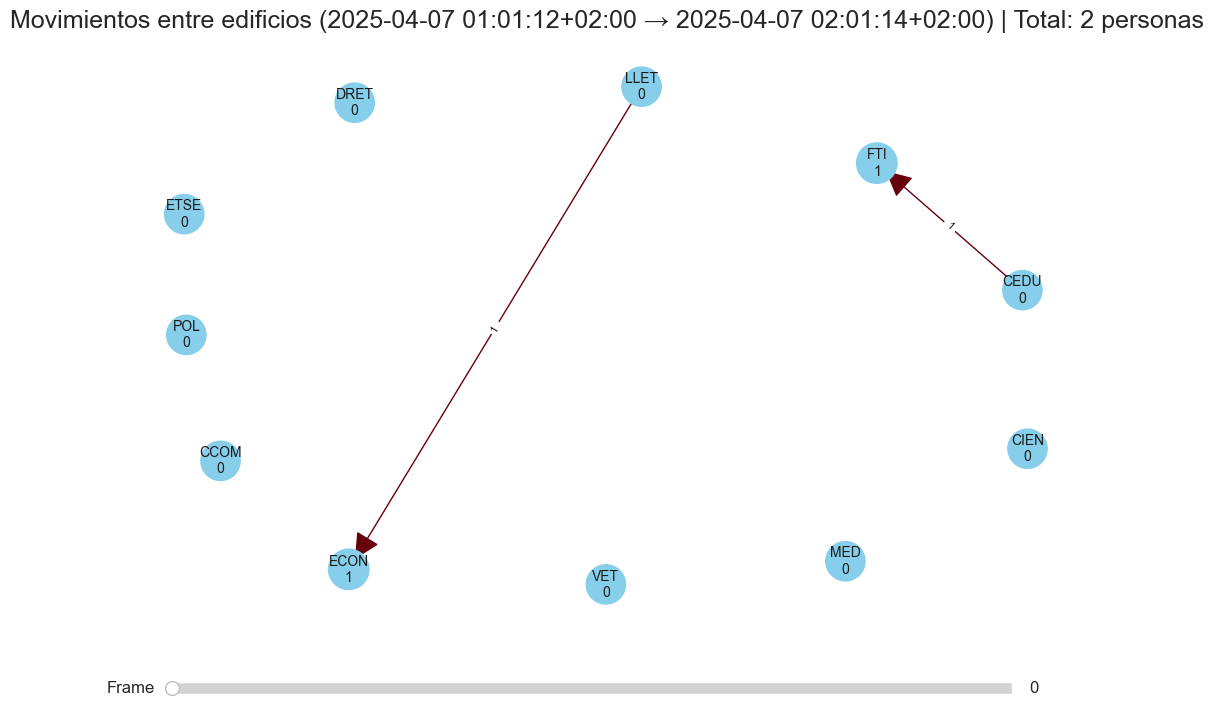

In [2]:
# =========================================================
# Función para mapear AP a edificio
# =========================================================
def ap_to_building(ap_name):
    match = re.match(r'AP-([A-Z]+)', ap_name)
    if match:
        return match.group(1)
    return ap_name

# =========================================================
# Funciones para cargar JSON
# =========================================================
def extract_timestamp_from_filename(filename):
    match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2}\+\d{2}_\d{2})', filename)
    if match:
        return match.group(1).replace('_', ':')
    return None

def load_all_json_files(directory, pattern):
    files = list(Path(directory).glob(pattern))
    print(f"Encontrados {len(files)} archivos")
    all_data = []
    for file in tqdm(files):
        try:
            with open(file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                timestamp = extract_timestamp_from_filename(file.name)
                for record in data:
                    record['_file_timestamp'] = timestamp
                all_data.extend(data)
        except Exception as e:
            print(f"Error cargando {file}: {e}")
    return pd.DataFrame(all_data)

# =========================================================
# Cargar datos
# =========================================================
base_dir = './anonymized_samples/clients'
df_clients_all = load_all_json_files(base_dir, 'client-info-*.json')

# =========================================================
# Preparar datos
# =========================================================
df_clients_all['_file_timestamp'] = pd.to_datetime(df_clients_all['_file_timestamp'])
df_clients_all = df_clients_all.sort_values('_file_timestamp')

df_clients_all['hour'] = df_clients_all['_file_timestamp'].dt.hour
df_clients_all['weekday'] = df_clients_all['_file_timestamp'].dt.weekday

timestamps = sorted(df_clients_all['_file_timestamp'].unique())
all_movements = []

for i in range(len(timestamps)-1):
    t1, t2 = timestamps[i], timestamps[i+1]
    t1_clients = df_clients_all[df_clients_all['_file_timestamp'] == t1]
    t2_clients = df_clients_all[df_clients_all['_file_timestamp'] == t2]

    movements = t1_clients.merge(
        t2_clients,
        on='macaddr',
        suffixes=('_t1', '_t2')
    )

    moved = movements[movements['associated_device_name_t1'] != movements['associated_device_name_t2']]

    for _, row in moved.iterrows():
        all_movements.append({
            'macaddr': row['macaddr'],
            'timestamp_origen': t1,
            'ap_origen': row['associated_device_name_t1'],
            'timestamp_destino': t2,
            'ap_destino': row['associated_device_name_t2']
        })

df_movements = pd.DataFrame(all_movements)

# =========================================================
# Agrupar APs por edificio
# =========================================================
df_movements['ap_origen_group'] = df_movements['ap_origen'].apply(ap_to_building)
df_movements['ap_destino_group'] = df_movements['ap_destino'].apply(ap_to_building)

# =========================================================
# Filtrar edificios relevantes
# =========================================================
top_buildings = ['CIEN', 'VET', 'ETSE', 'LLET', 'POL',
                 'ECON', 'MED', 'CEDU', 'CCOM', 'FTI', 'DRET']

df_movements_subset = df_movements[
    df_movements['ap_origen_group'].isin(top_buildings) &
    df_movements['ap_destino_group'].isin(top_buildings) &
    (df_movements['ap_origen_group'] != df_movements['ap_destino_group'])
    ]

# =========================================================
# Precalcular datos por timestamp
# =========================================================
timestamps_subset = sorted(df_movements_subset['timestamp_destino'].unique())
nodes = list(set(df_movements_subset['ap_origen_group']) | set(df_movements_subset['ap_destino_group']))

edge_data_dict = {}
node_counts_dict = {}

for t_idx in range(len(timestamps_subset)-1):
    t1, t2 = timestamps_subset[t_idx], timestamps_subset[t_idx+1]
    df_frame = df_movements_subset[
        (df_movements_subset['timestamp_origen'] == t1) &
        (df_movements_subset['timestamp_destino'] == t2)
        ]

    edge_costs = df_frame.groupby(['ap_origen_group', 'ap_destino_group'])['macaddr'].nunique().to_dict()
    edge_data_dict[(t1, t2)] = edge_costs

    df_t2 = df_movements_subset[df_movements_subset['timestamp_destino'] == t2]
    node_counts_dict[t2] = df_t2.groupby('ap_destino_group')['macaddr'].nunique().to_dict()

# =========================================================
# Visualización
# =========================================================
pos = nx.spring_layout(nodes, seed=42)
fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(bottom=0.15)

ax_slider = plt.axes([0.15, 0.05, 0.7, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Frame', 0, len(timestamps_subset)-2, valinit=0, valstep=1)

def update(frame):
    ax.clear()
    if frame >= len(timestamps_subset) - 1:
        return

    t1, t2 = timestamps_subset[frame], timestamps_subset[frame+1]
    edge_costs = edge_data_dict.get((t1, t2), {})
    node_counts = node_counts_dict.get(t2, {})
    total_personas = sum(node_counts.values())

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for (u, v), cost in edge_costs.items():
        G.add_edge(u, v, cost=cost)

    node_sizes = [800 + node_counts.get(n, 0) * 50 for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=node_sizes)

    if G.edges():
        max_cost = max(d['cost'] for _, _, d in G.edges(data=True))
    else:
        max_cost = 1

    for u, v, d in G.edges(data=True):
        rad = 0.2 if (v, u) in G.edges() else 0.0
        width = max(1, d['cost'] / 3.5)
        color = cm.Reds(d['cost'] / max_cost)
        if width >= 13:
            width = 13
            color = 'black'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], ax=ax,
            width=width, edge_color=color,
            arrowstyle='-|>', arrowsize=40,
            connectionstyle=f'arc3,rad={rad}'
        )

    nx.draw_networkx_labels(
        G, pos, ax=ax,
        labels={n: f"{n}\n{node_counts.get(n, 0)}" for n in G.nodes()},
        font_size=10
    )

    for u, v, d in G.edges(data=True):
        label_pos = 0.6 if (v, u) in G.edges() else 0.5
        nx.draw_networkx_edge_labels(
            G, pos, ax=ax,
            edge_labels={(u, v): f"{d['cost']}"},
            font_size=8, label_pos=label_pos
        )

    ax.set_title(f"Movimientos entre edificios ({t1} → {t2}) | Total: {total_personas} personas")
    ax.axis('off')
    fig.canvas.draw_idle()

slider.on_changed(update)
update(0)
plt.show()


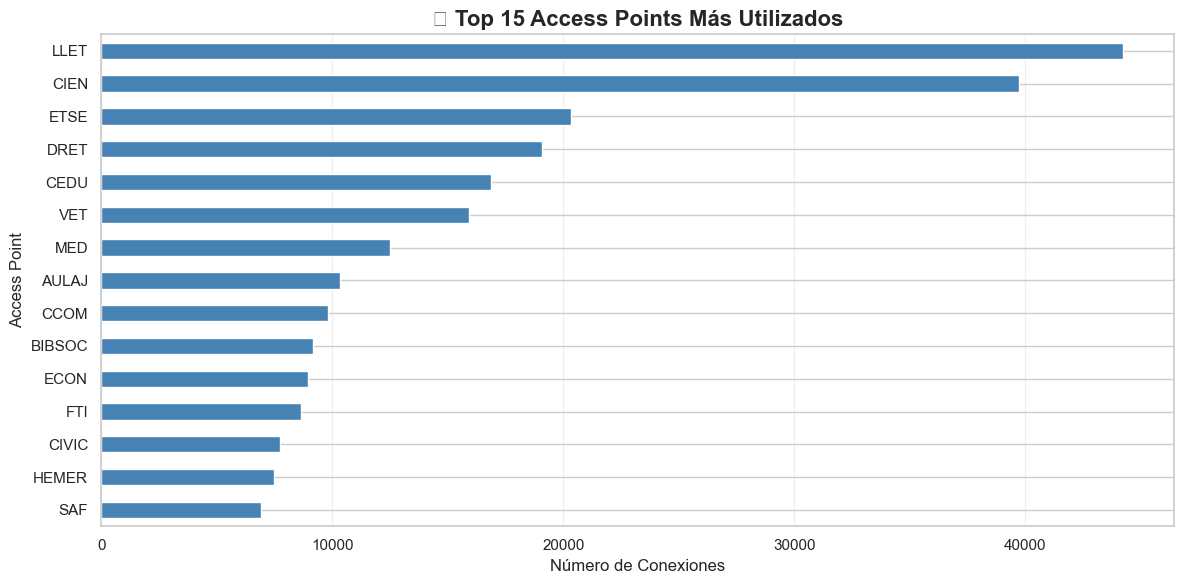


🔥 El AP más usado es: LLET con 44,226 conexiones


In [3]:
# Top 15 APs más utilizados
top_aps_usage = df_movements['ap_origen_group'].value_counts().head(15)

plt.figure(figsize=(12, 6))
top_aps_usage.plot(kind='barh', color='steelblue')
plt.title('📡 Top 15 Access Points Más Utilizados', fontsize=16, fontweight='bold')
plt.xlabel('Número de Conexiones', fontsize=12)
plt.ylabel('Access Point', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔥 El AP más usado es: {top_aps_usage.index[0]} con {top_aps_usage.values[0]:,} conexiones")

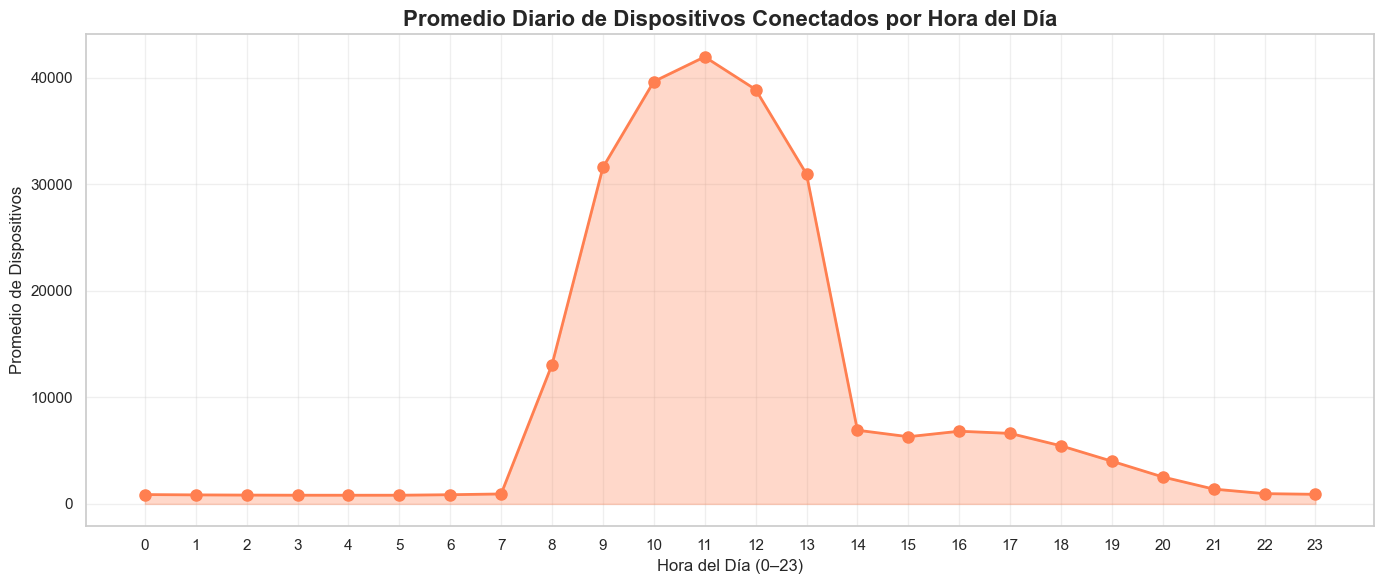


🕐 Hora pico promedio: 11:00 con 41952.7 dispositivos conectados en promedio


In [6]:
# Agrupar por fecha y hora primero
df_clients_all['date'] = df_clients_all['_file_timestamp'].dt.date
hourly_daily_activity = df_clients_all.groupby(['date', 'hour']).size().reset_index(name='count')

# Promedio de dispositivos conectados por hora del día
hourly_mean_activity = hourly_daily_activity.groupby('hour')['count'].mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(hourly_mean_activity.index, hourly_mean_activity.values, marker='o', linewidth=2, markersize=8, color='coral')
plt.fill_between(hourly_mean_activity.index, hourly_mean_activity.values, alpha=0.3, color='coral')
plt.title('Promedio Diario de Dispositivos Conectados por Hora del Día', fontsize=16, fontweight='bold')
plt.xlabel('Hora del Día (0–23)', fontsize=12)
plt.ylabel('Promedio de Dispositivos', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Hora pico promedio
peak_hour = hourly_mean_activity.idxmax()
peak_devices = hourly_mean_activity.max()
print(f"\n🕐 Hora pico promedio: {peak_hour}:00 con {peak_devices:.1f} dispositivos conectados en promedio")


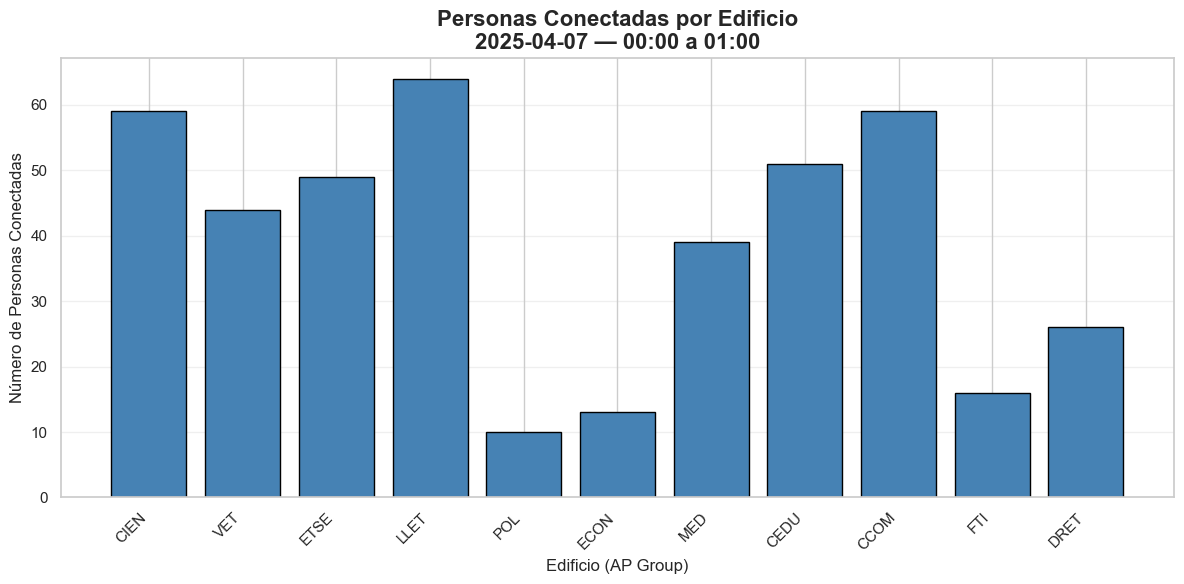

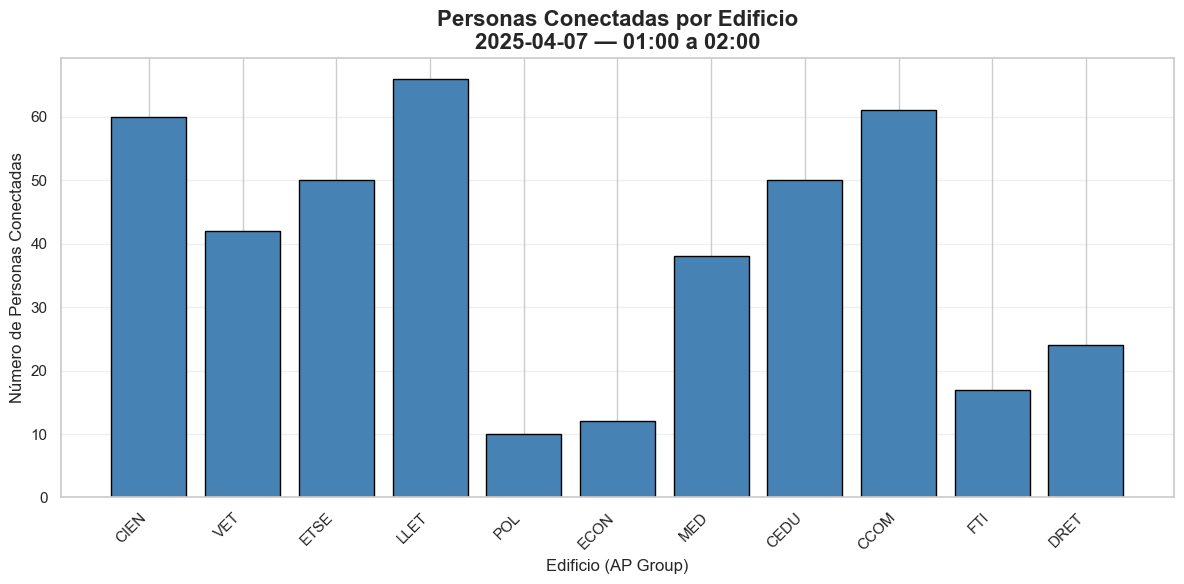

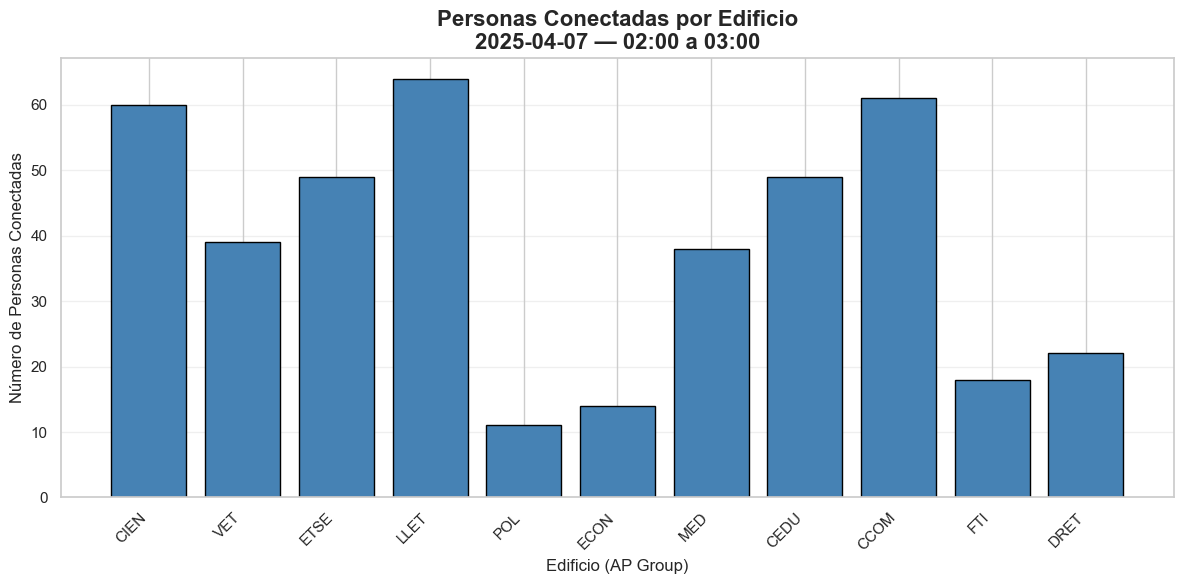

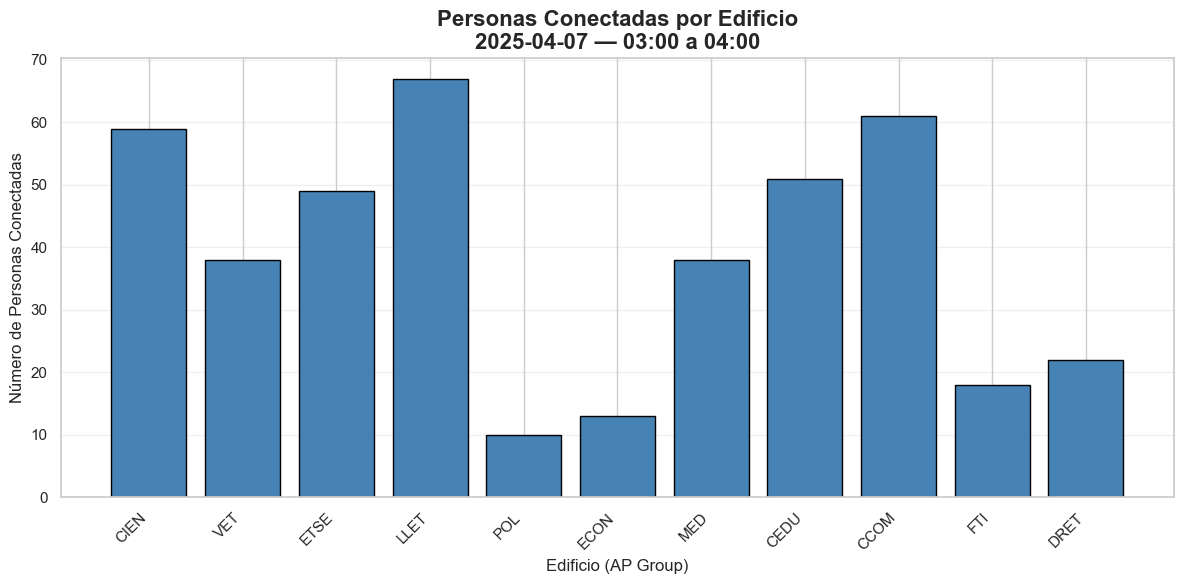

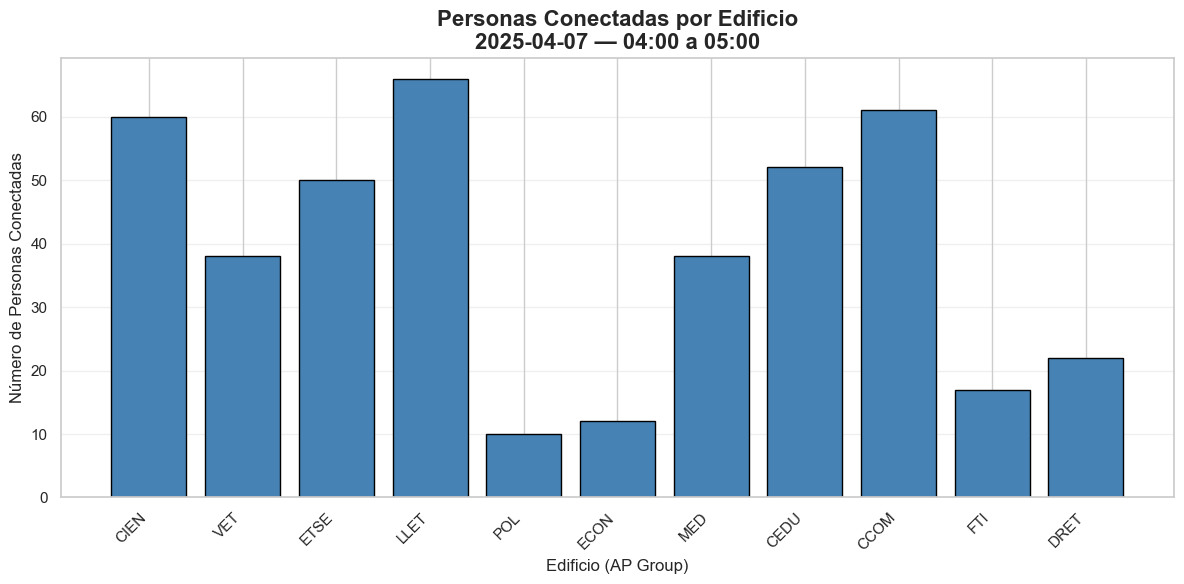

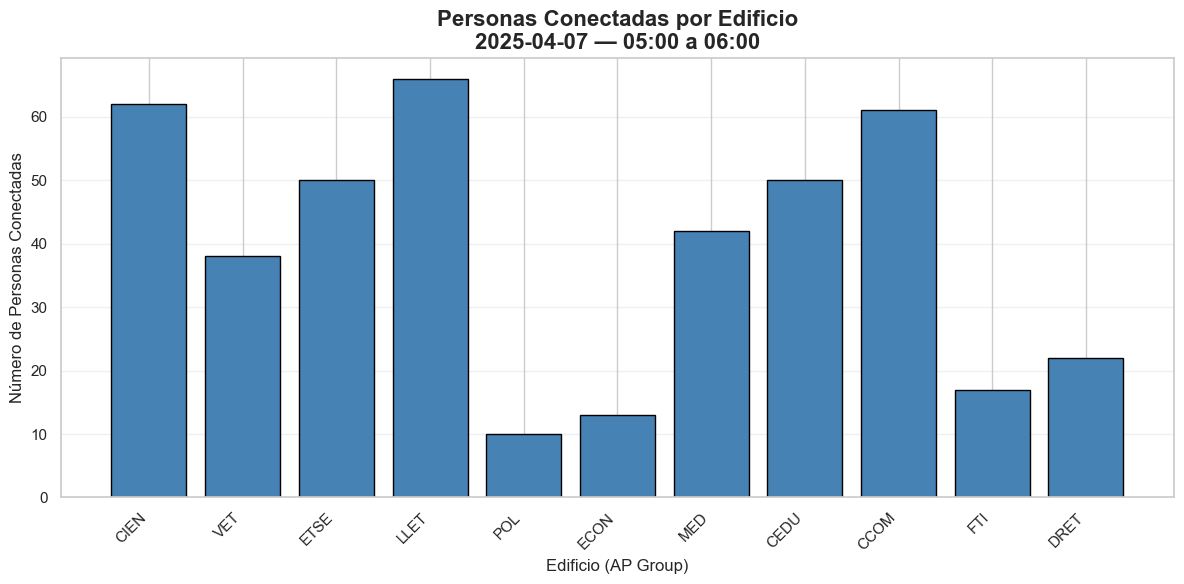

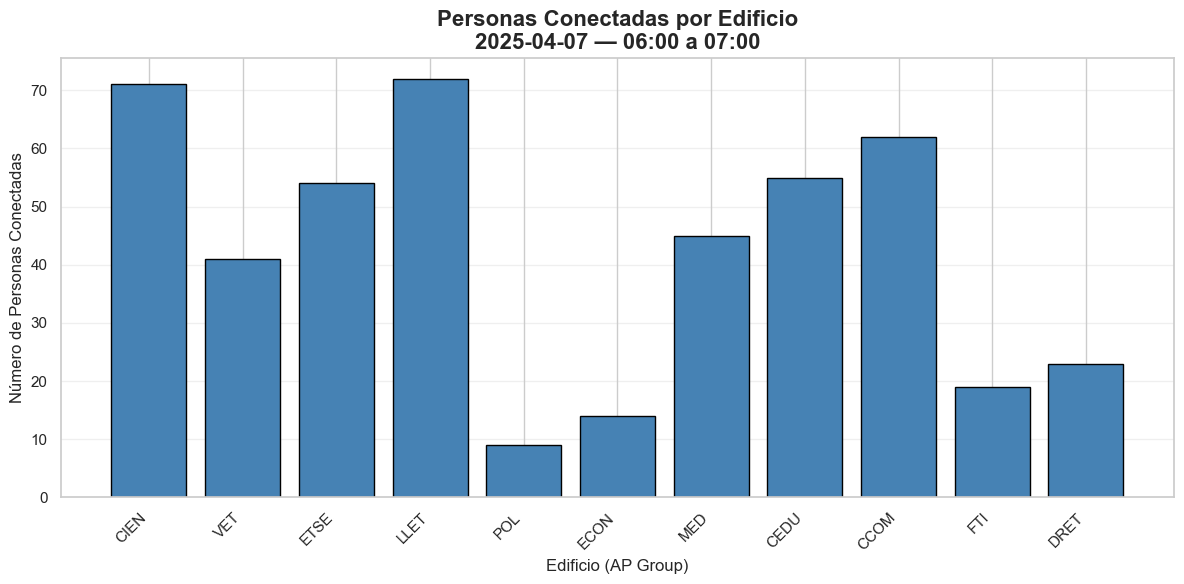

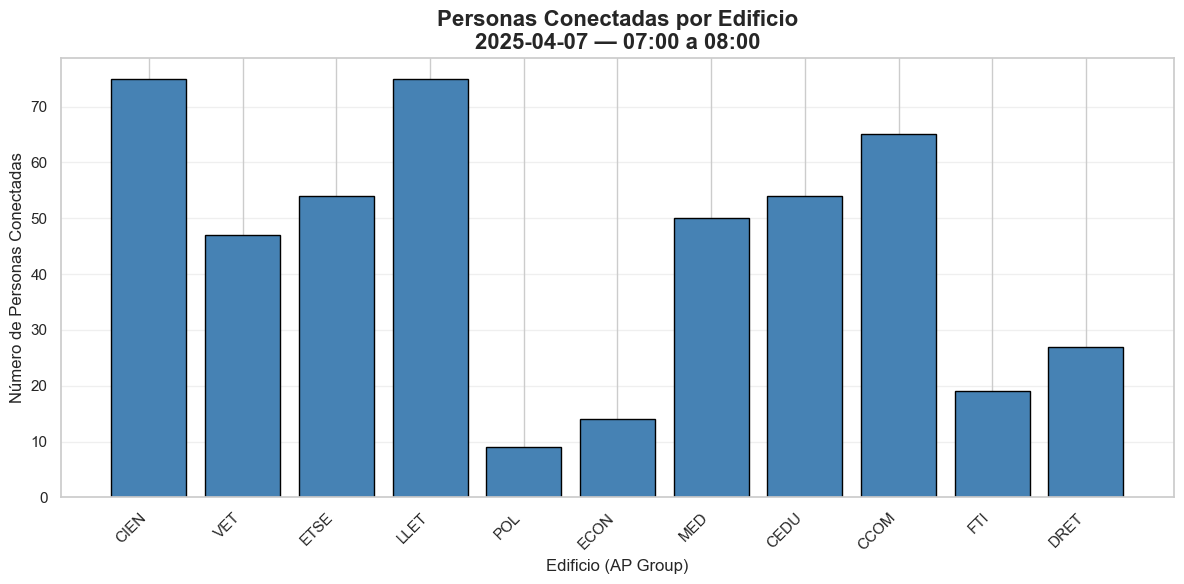

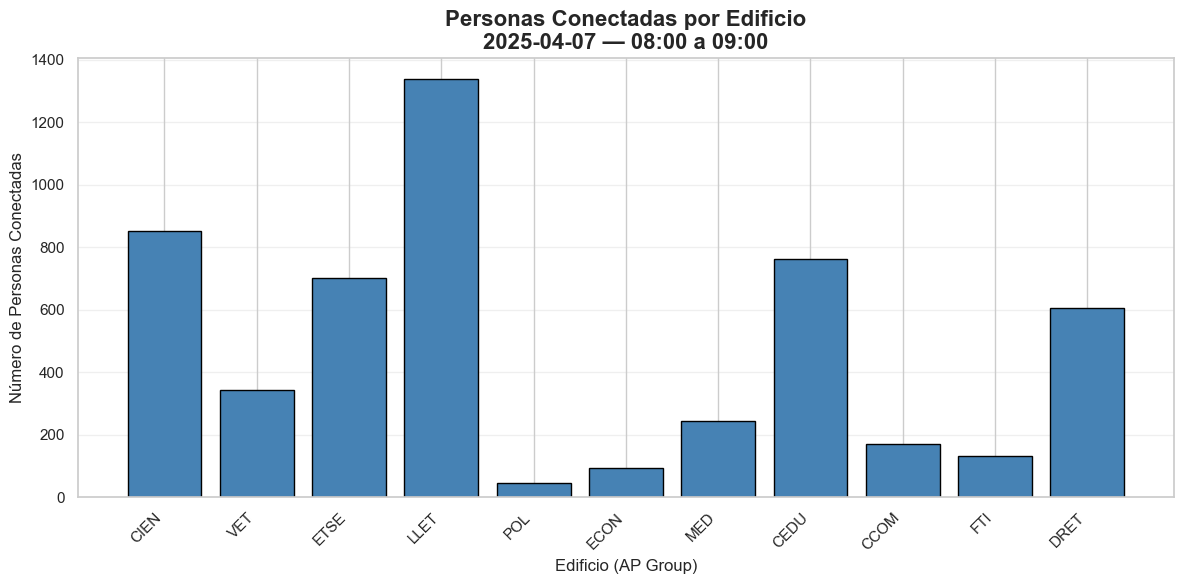

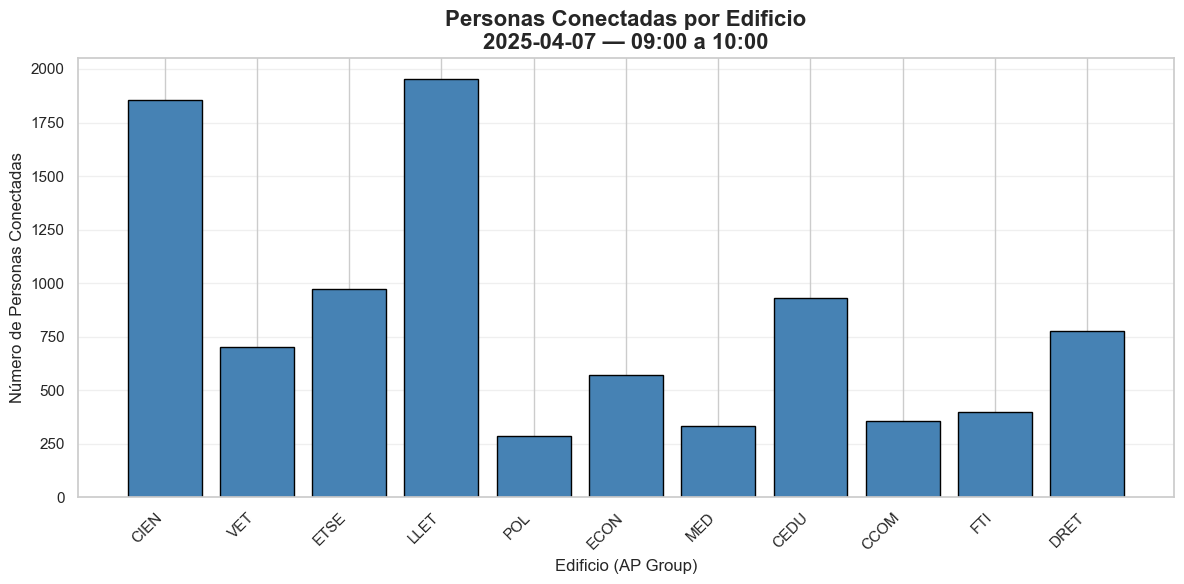

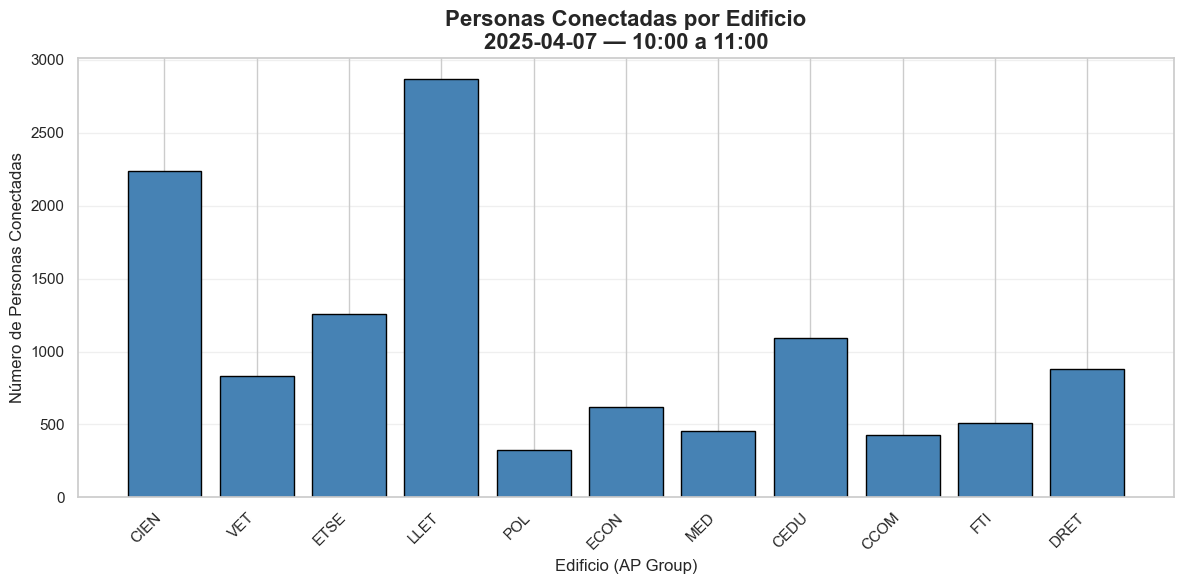

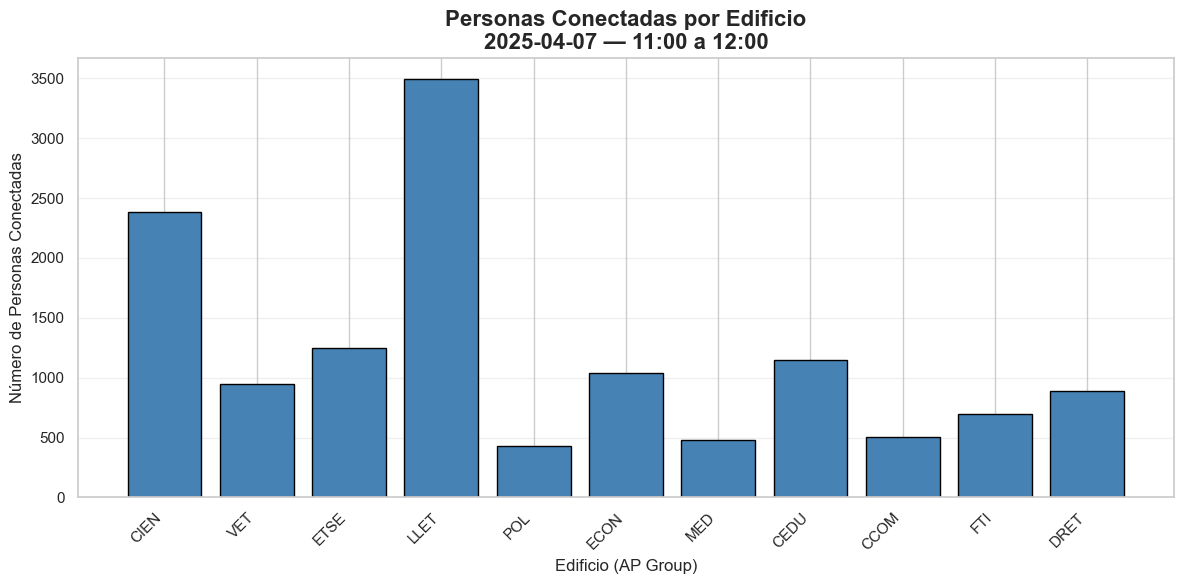

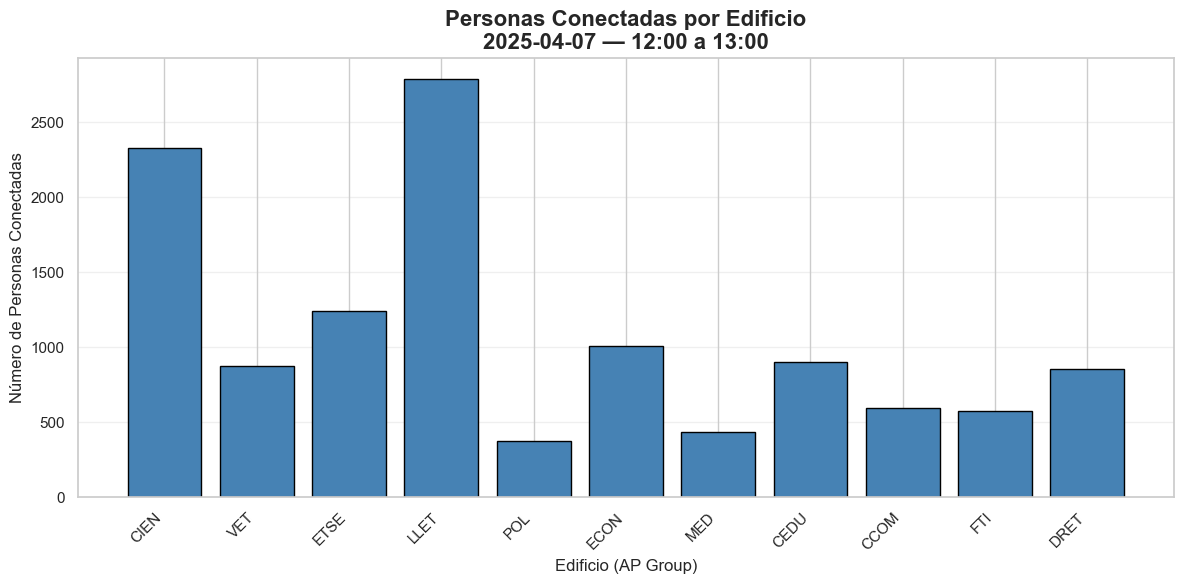

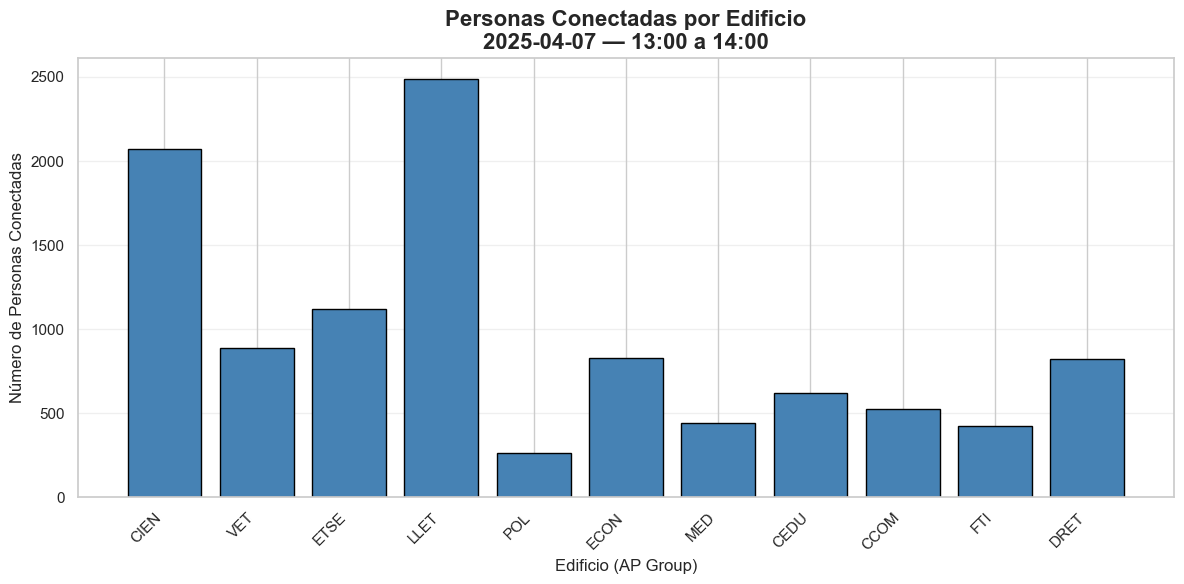

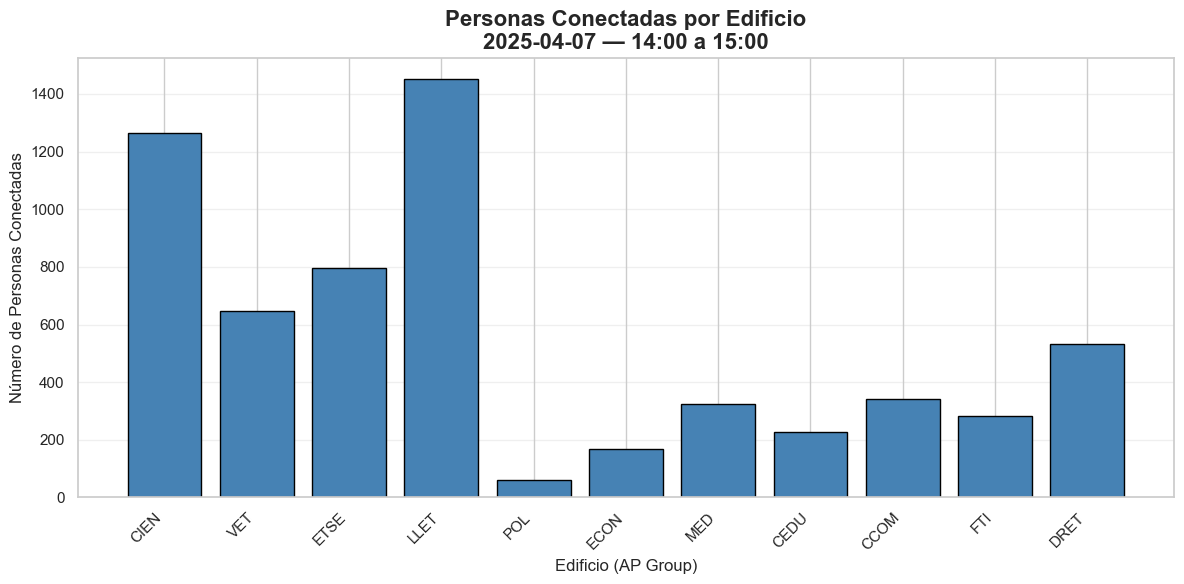

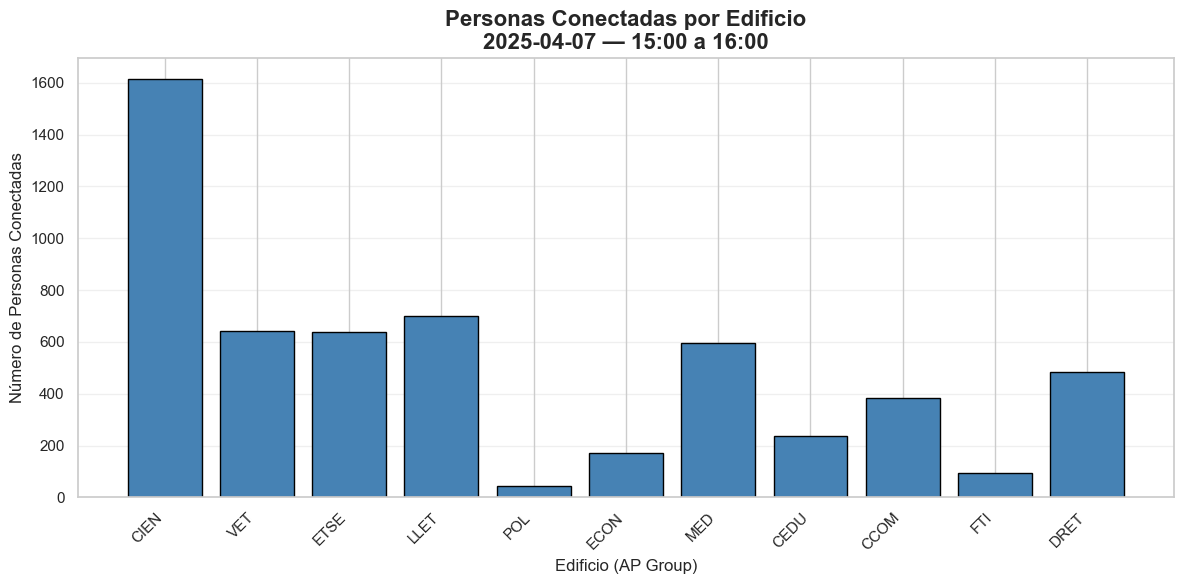

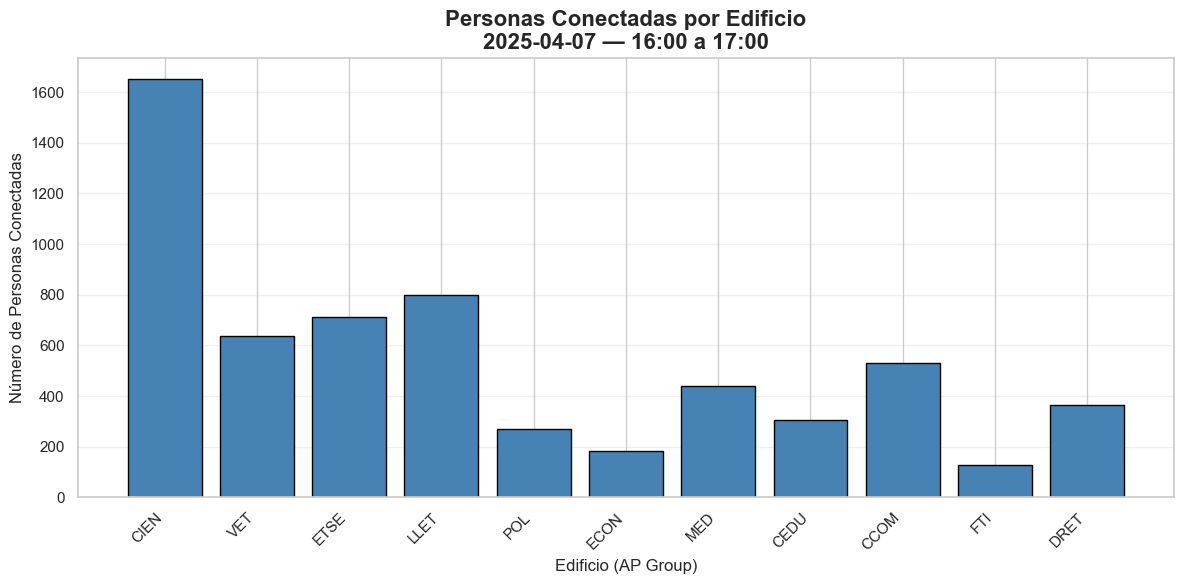

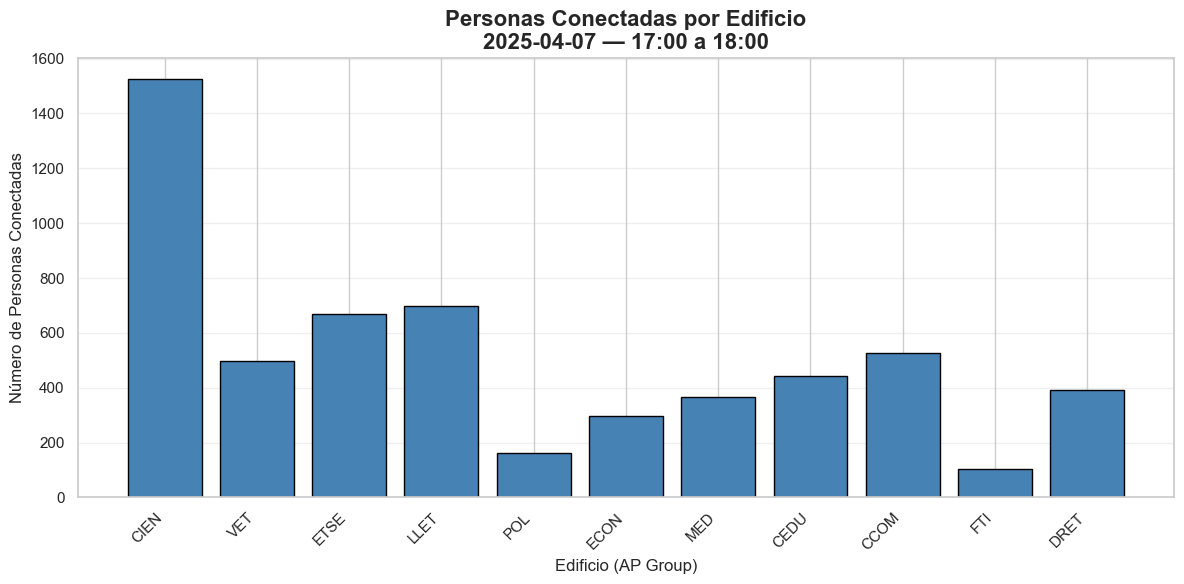

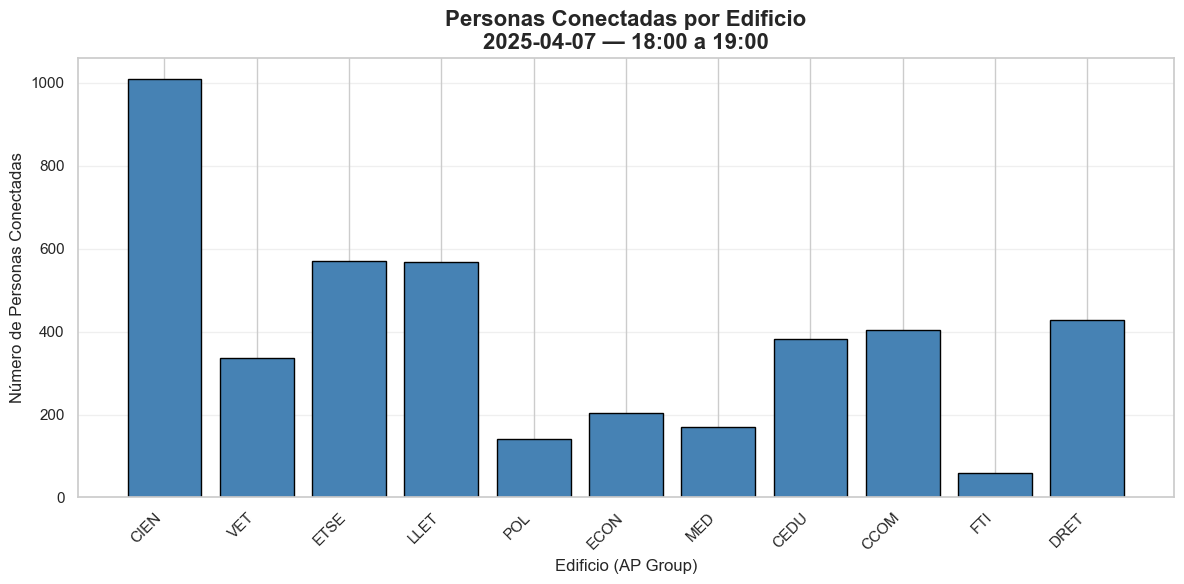

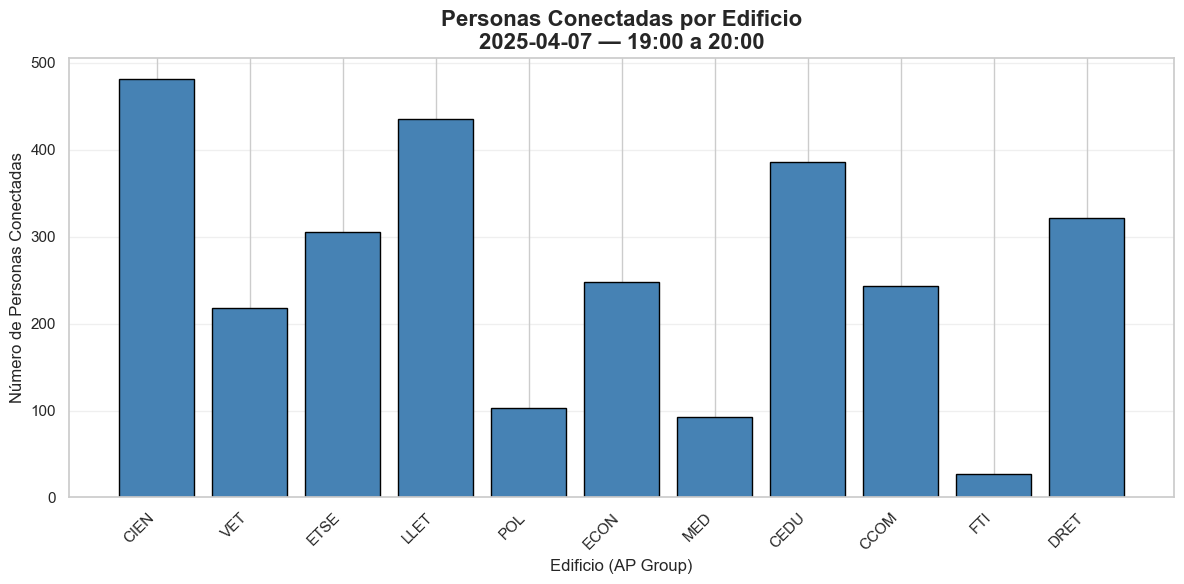

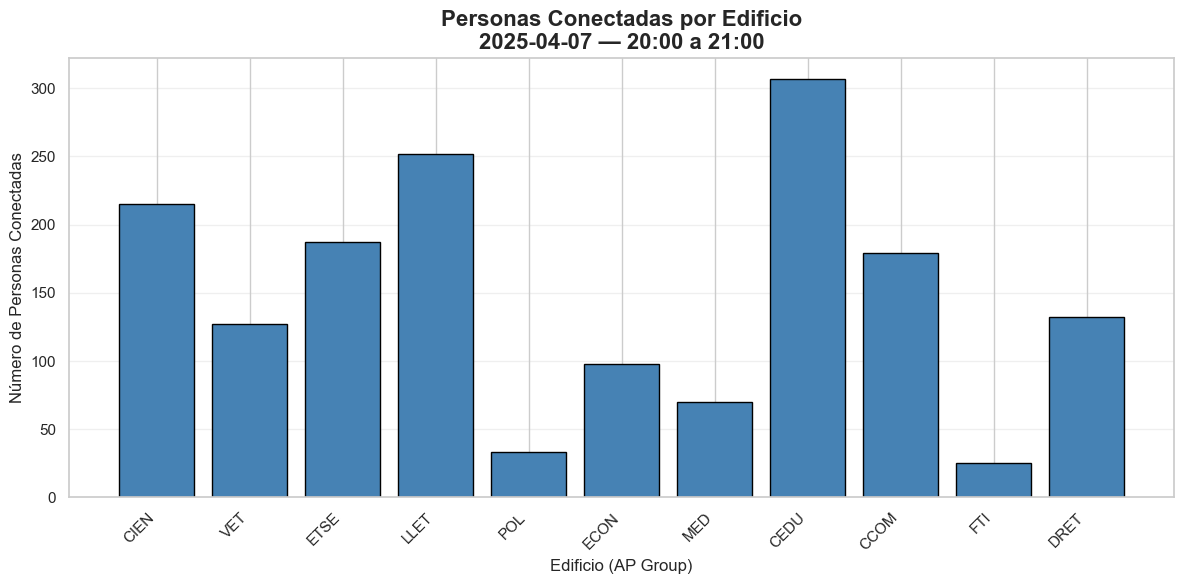

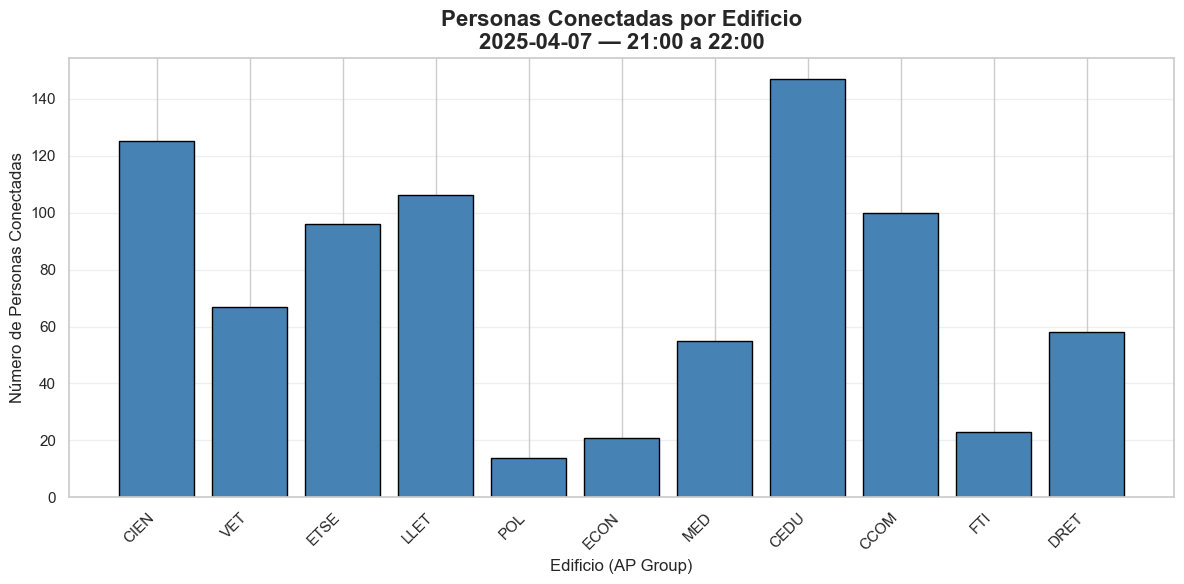

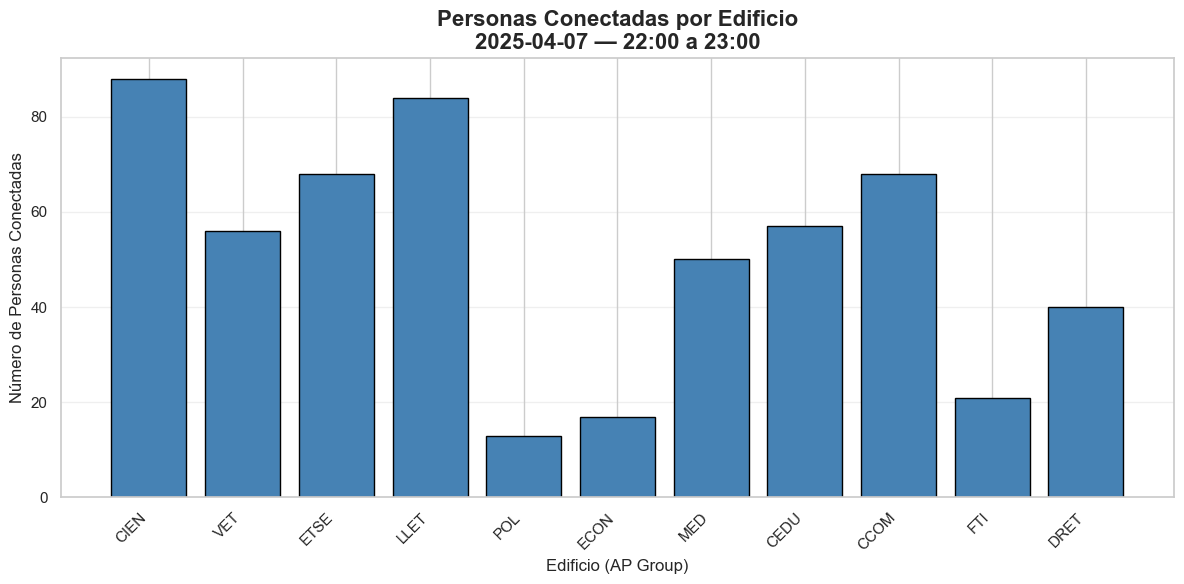

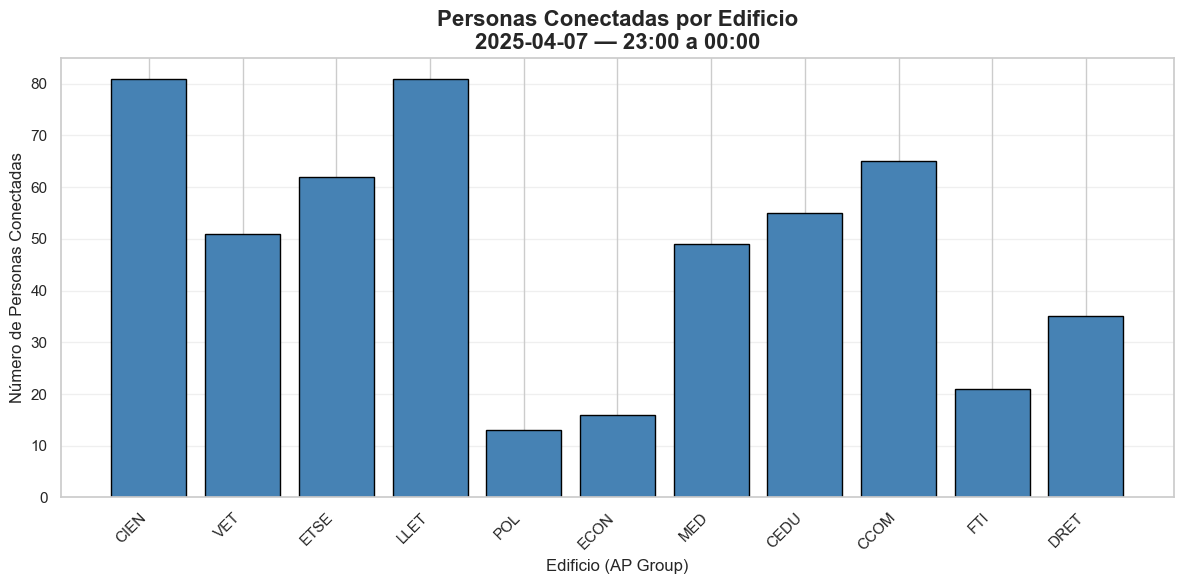

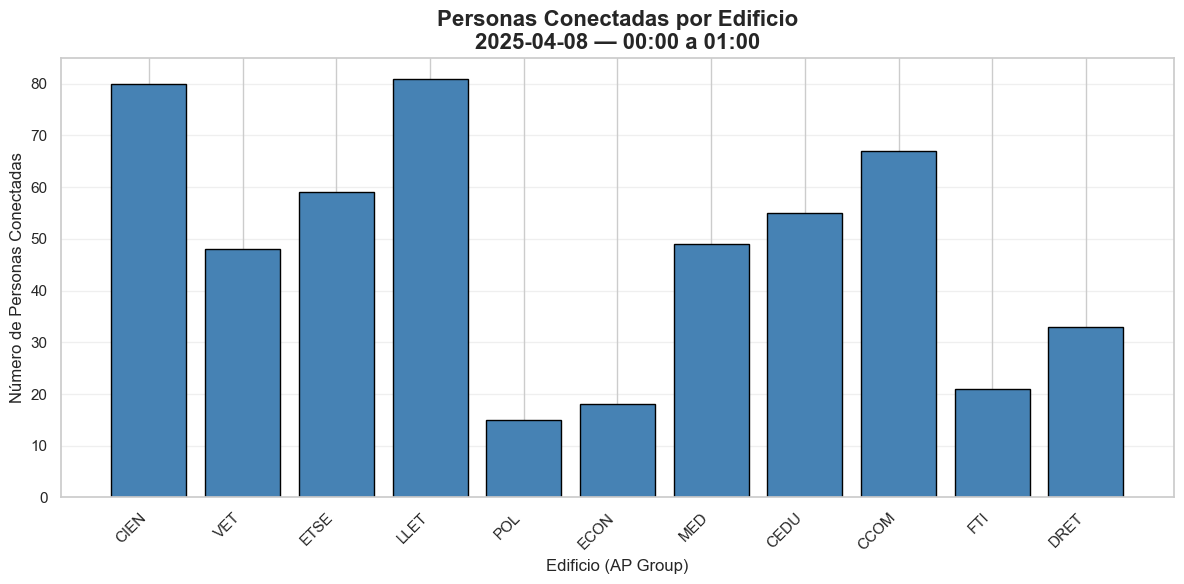

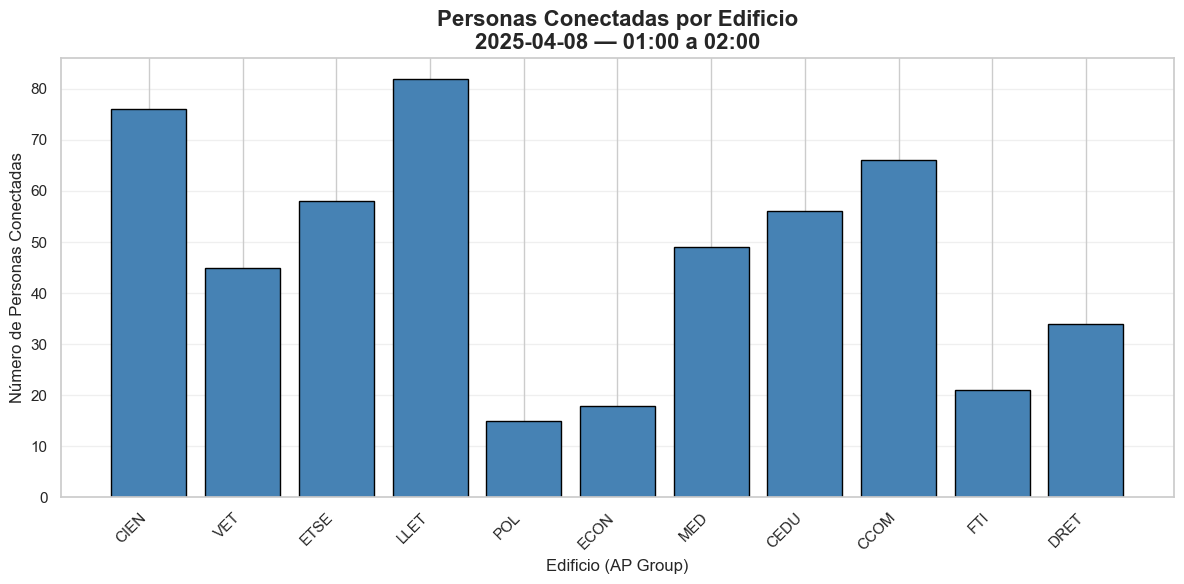

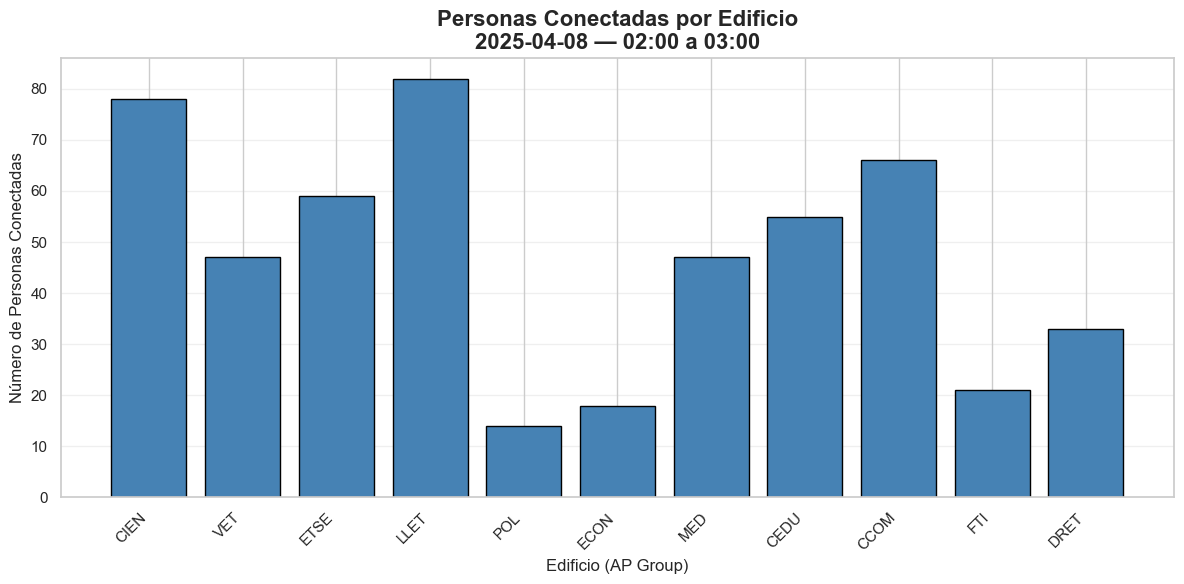

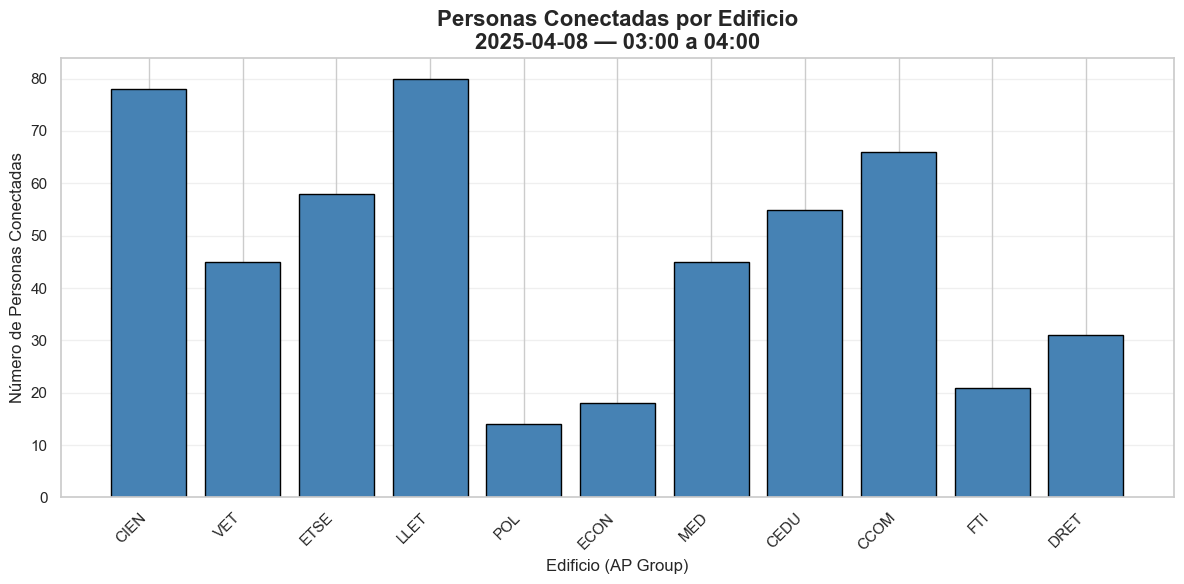

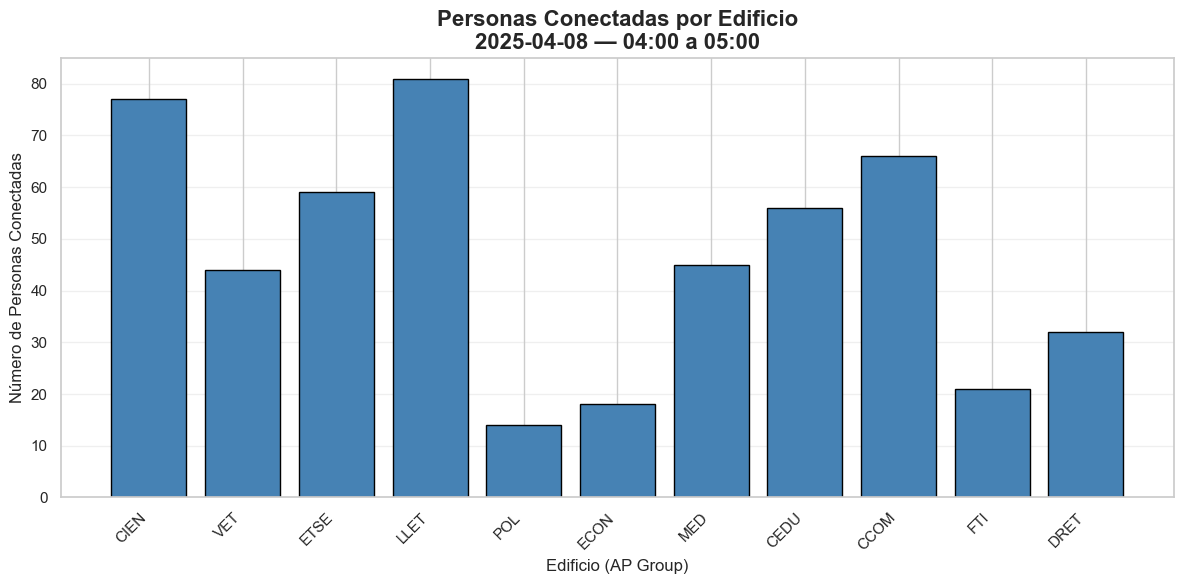

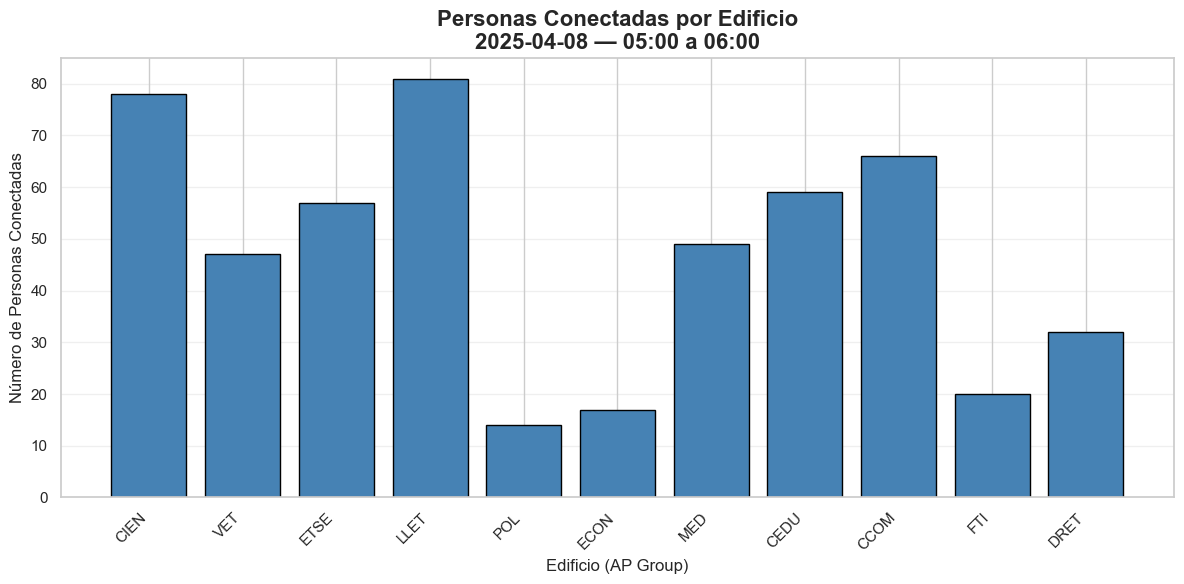

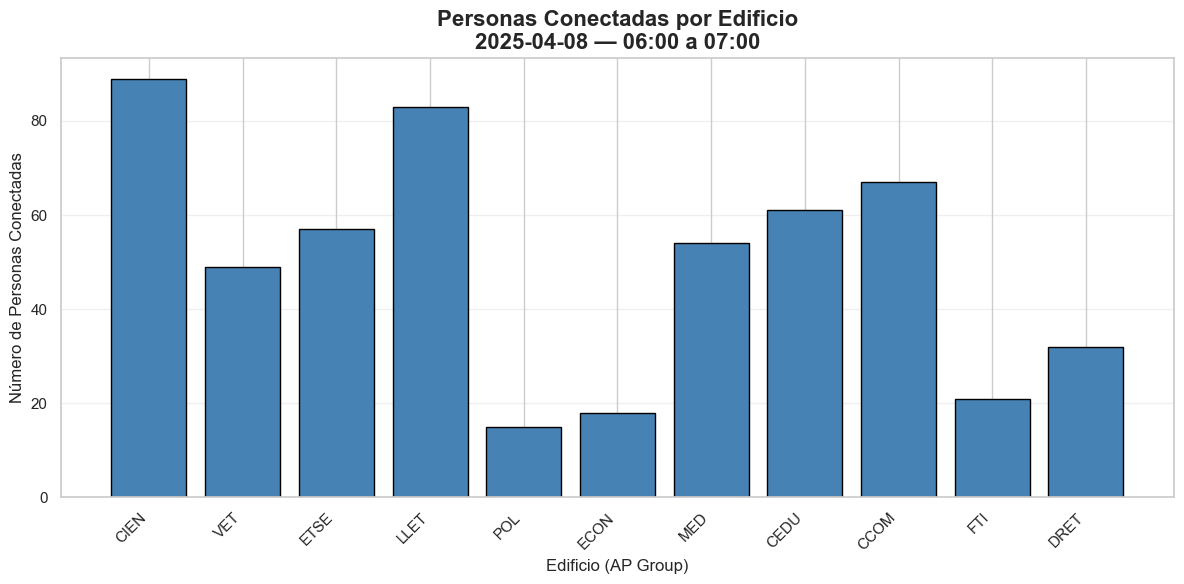

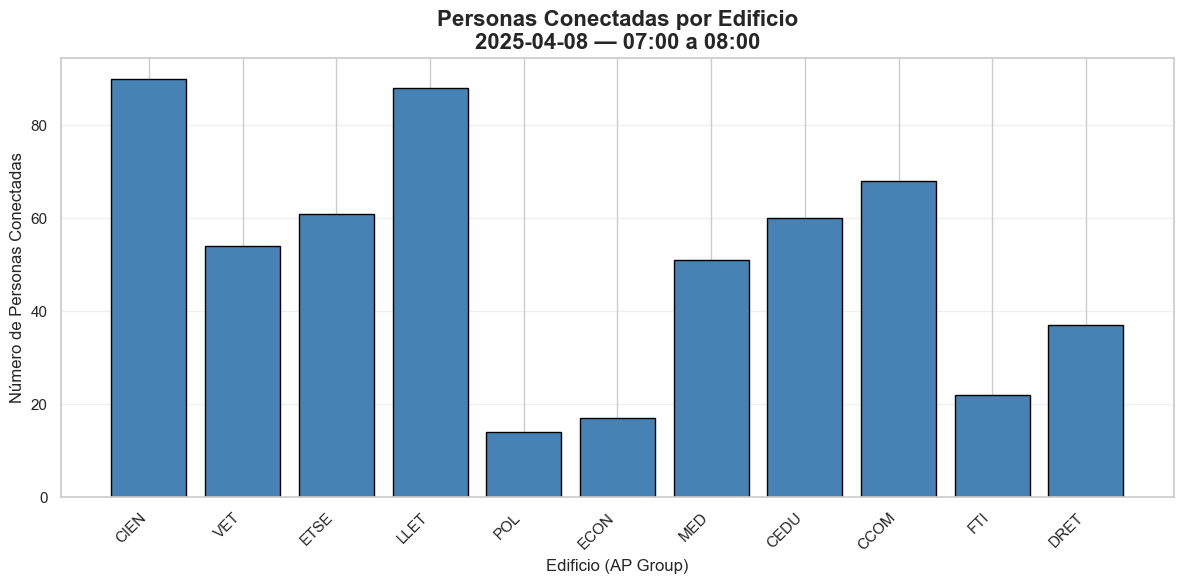

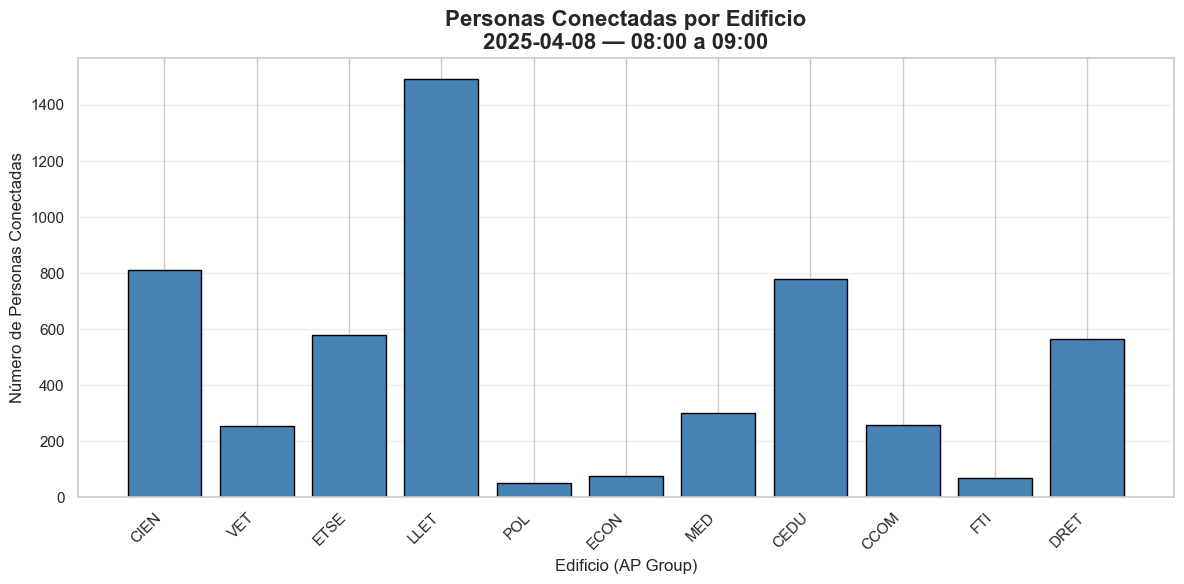

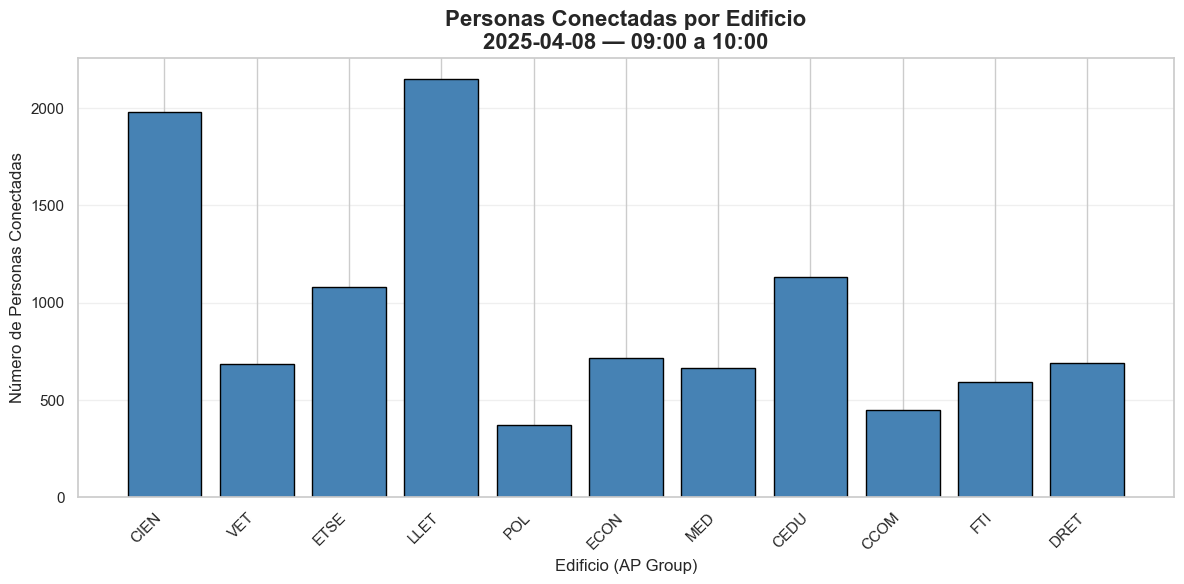

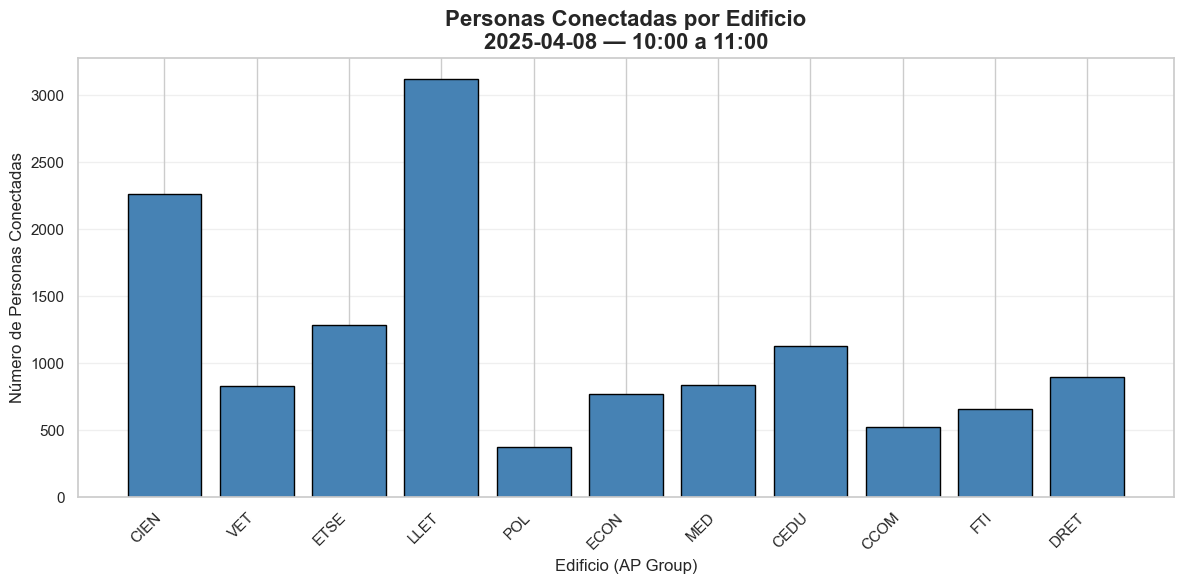

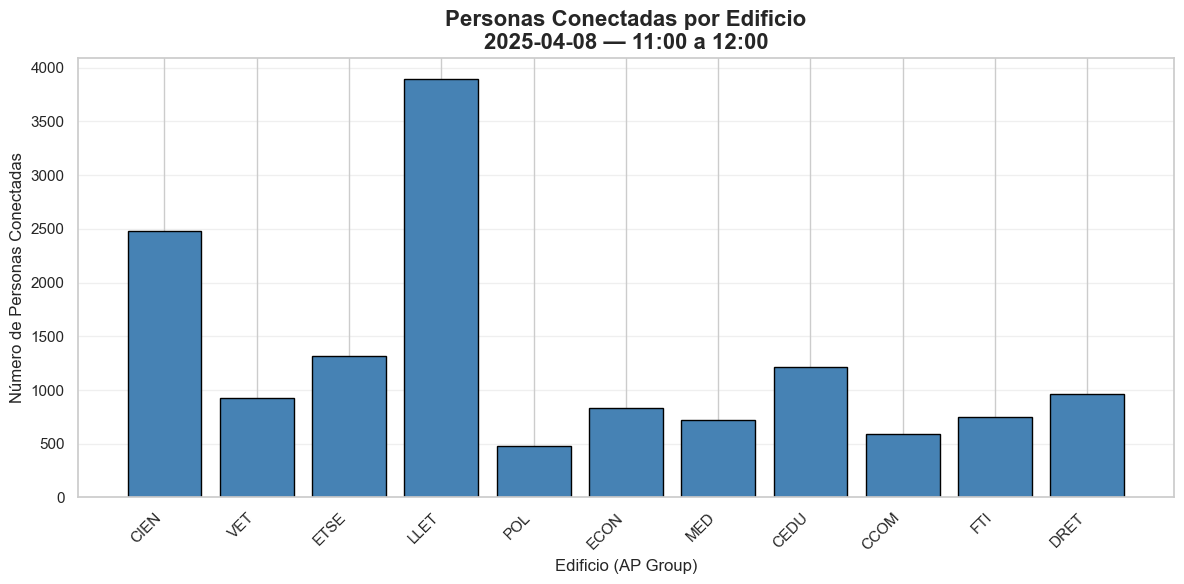

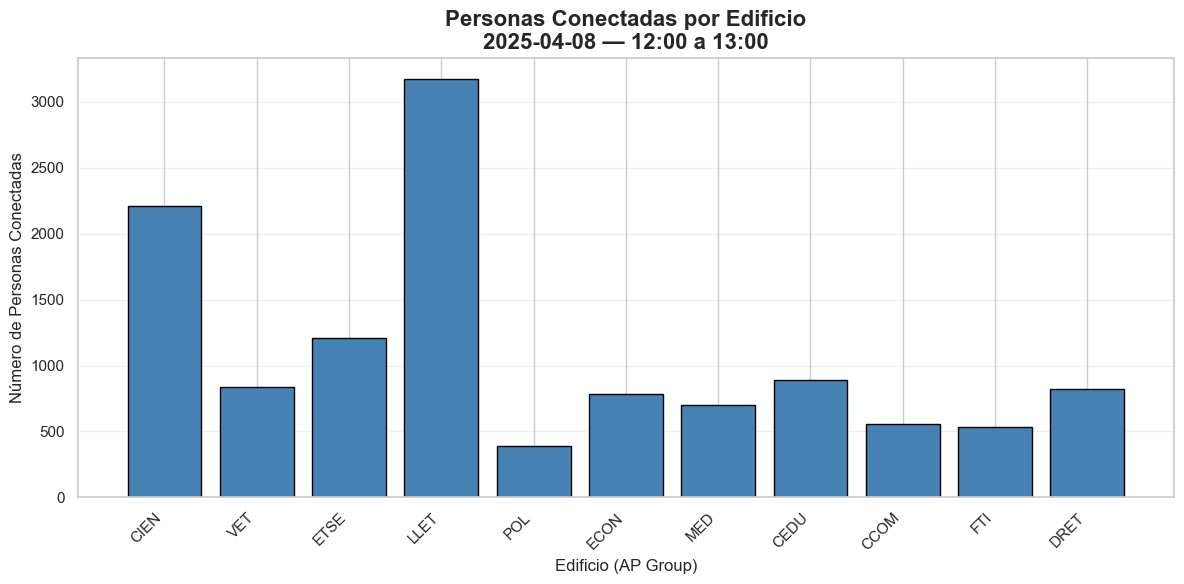

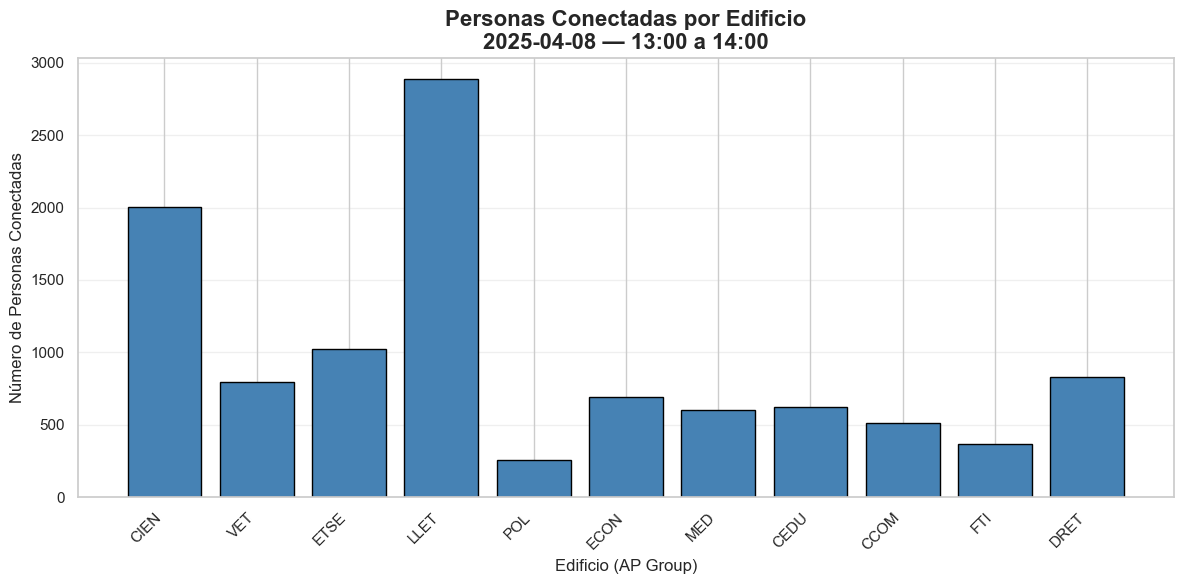

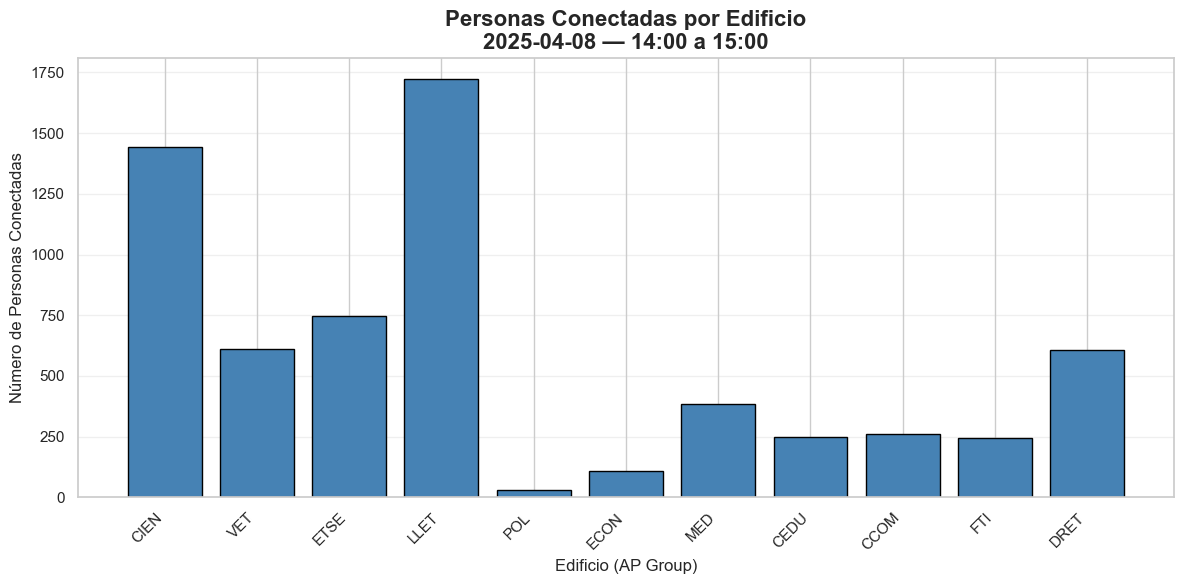

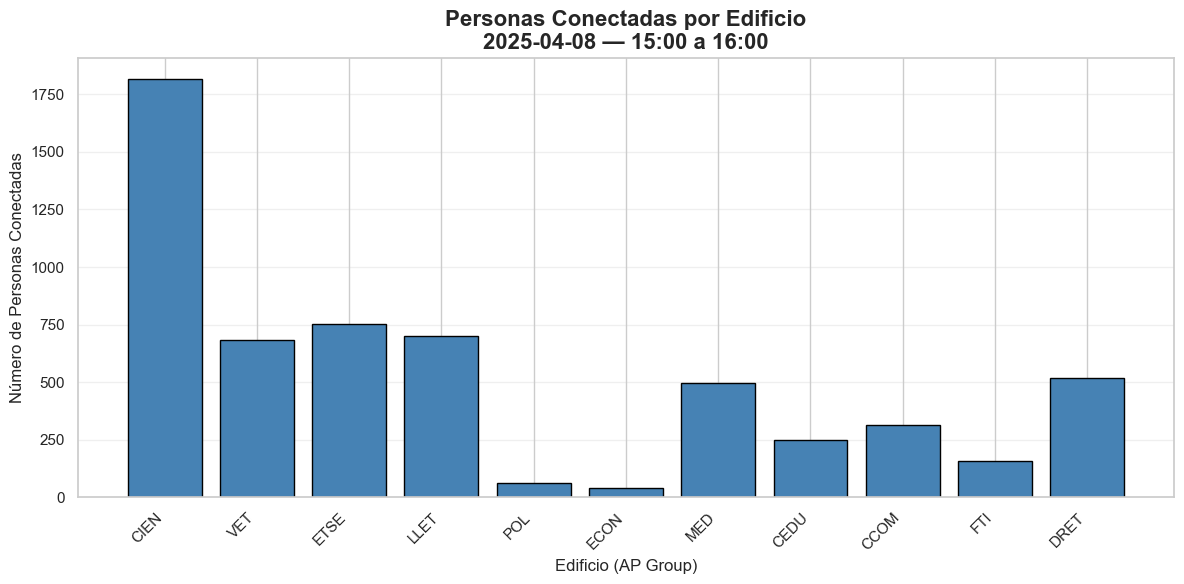

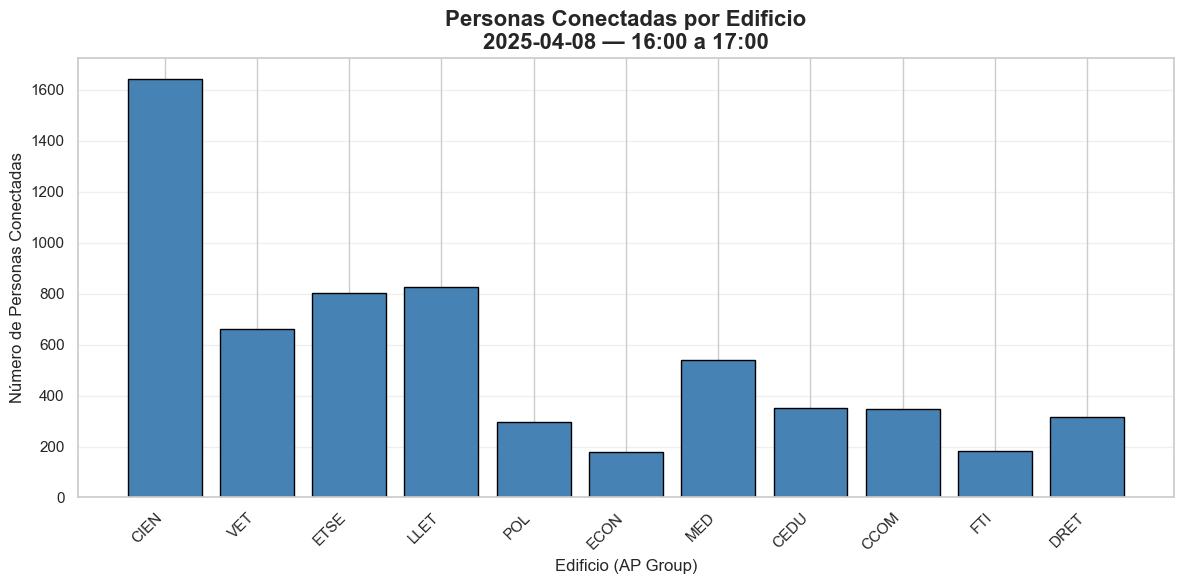

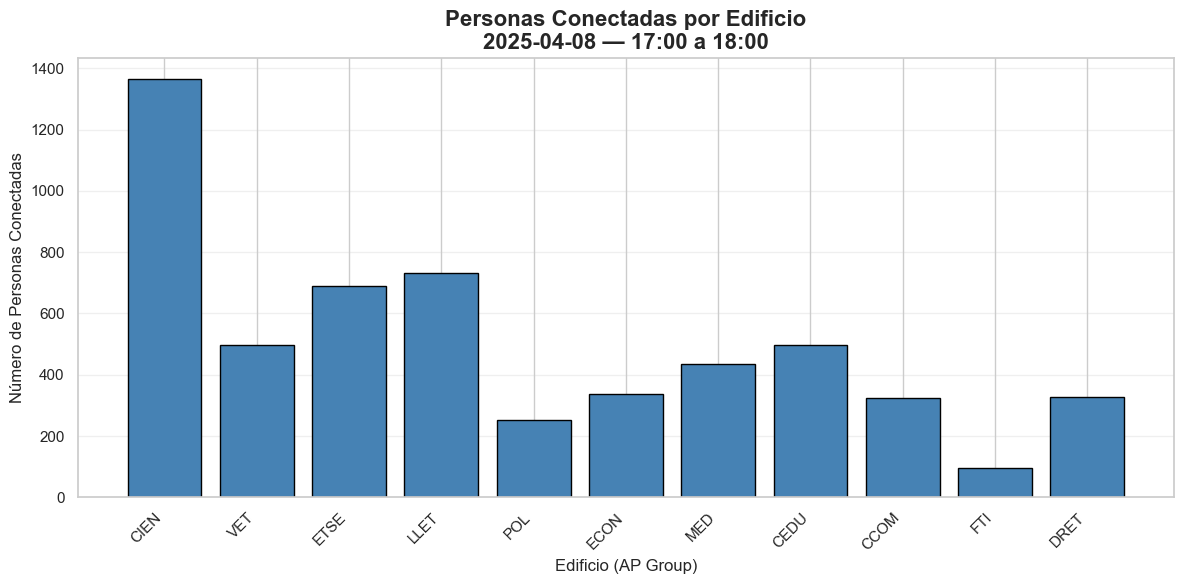

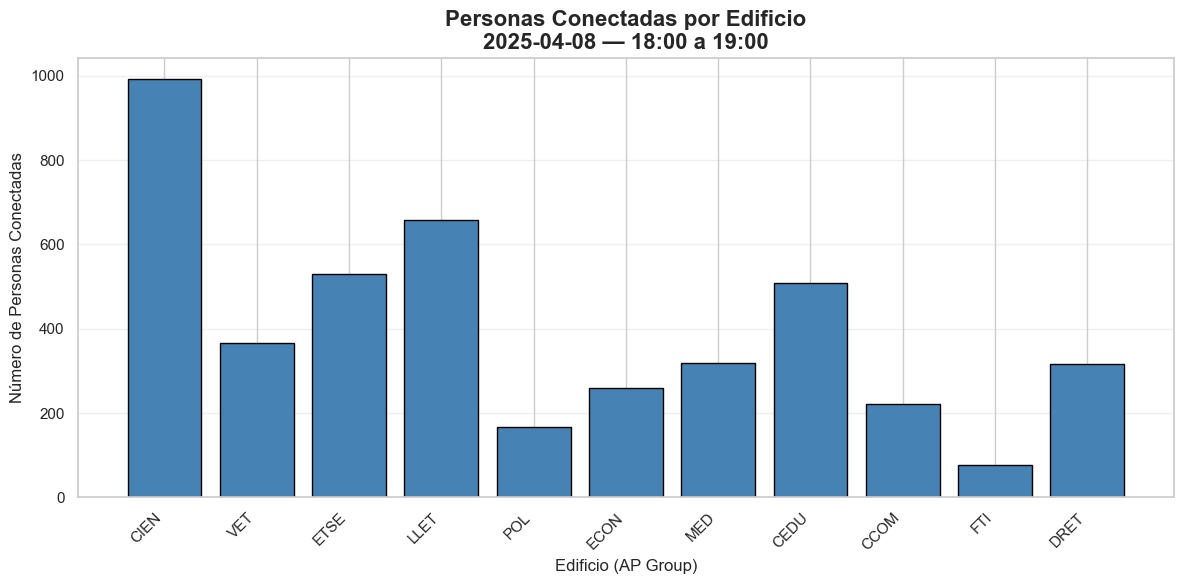

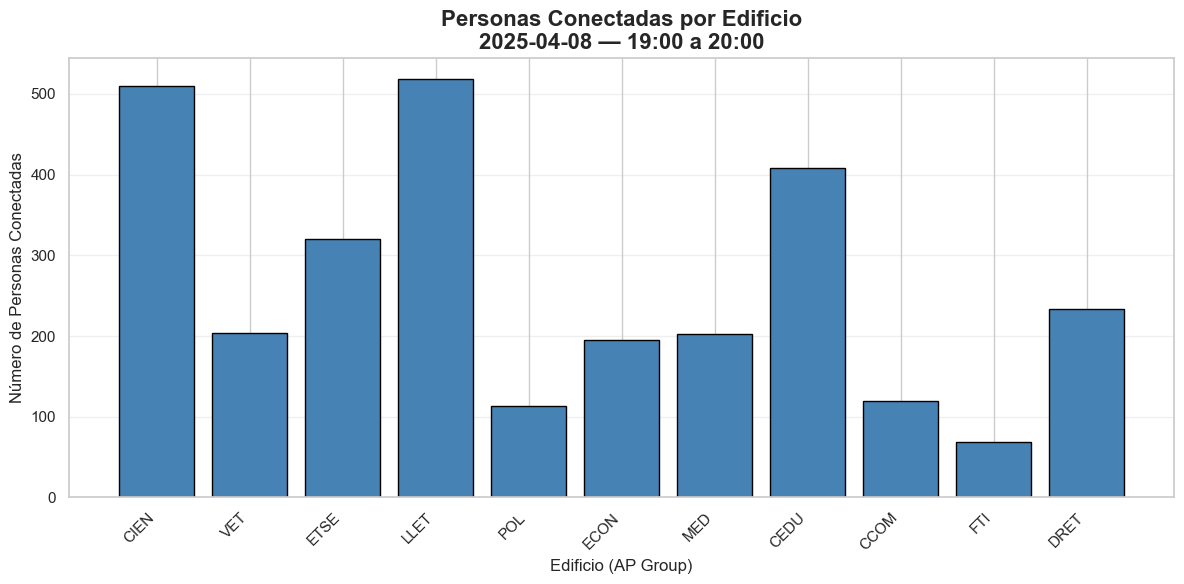

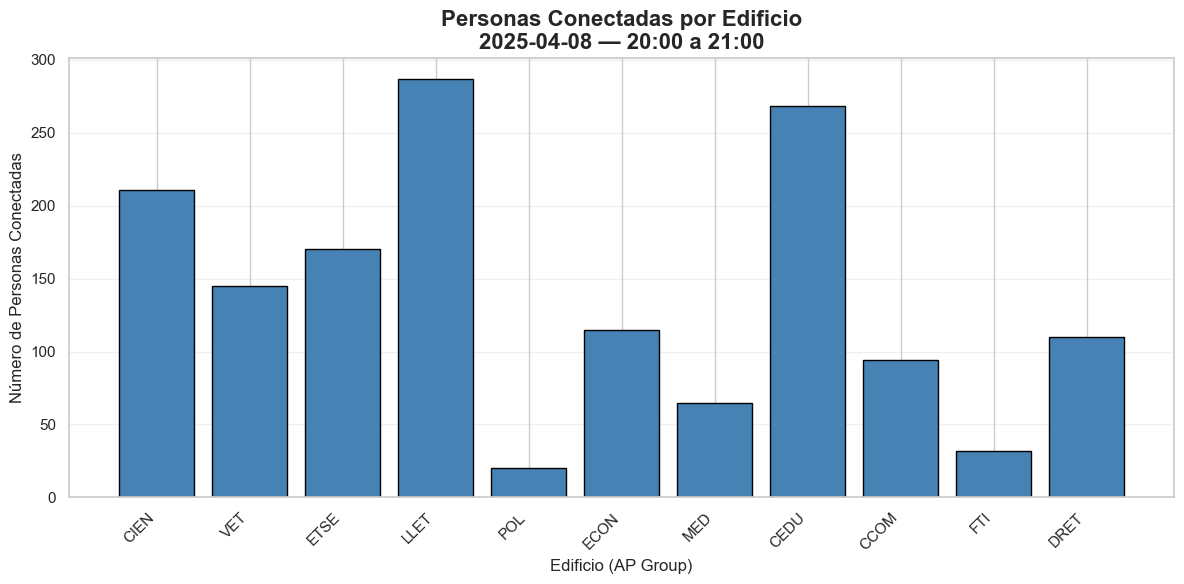

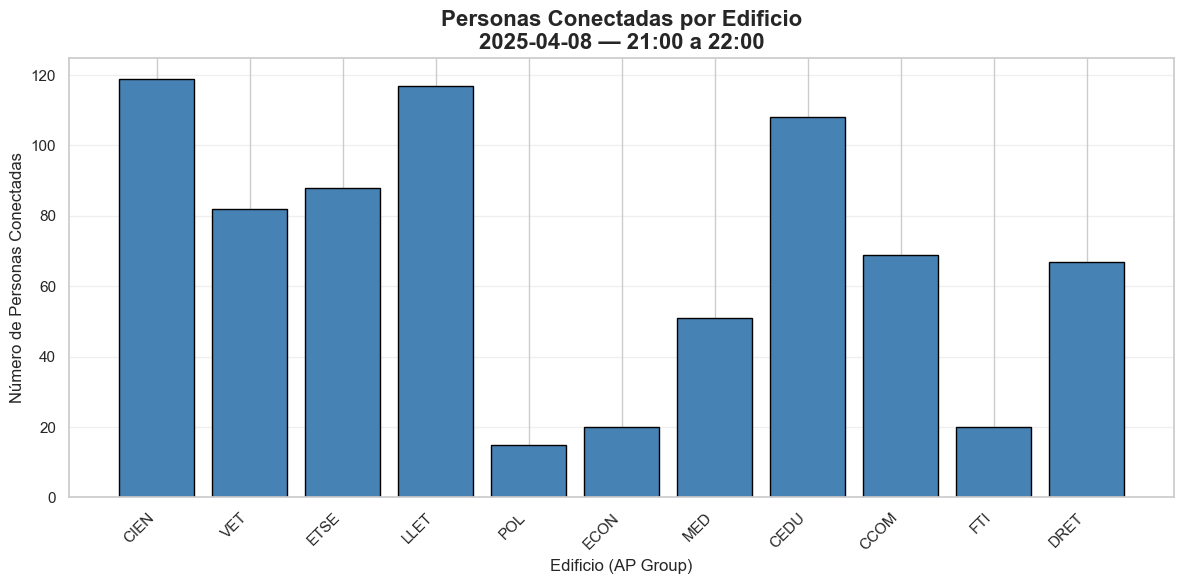

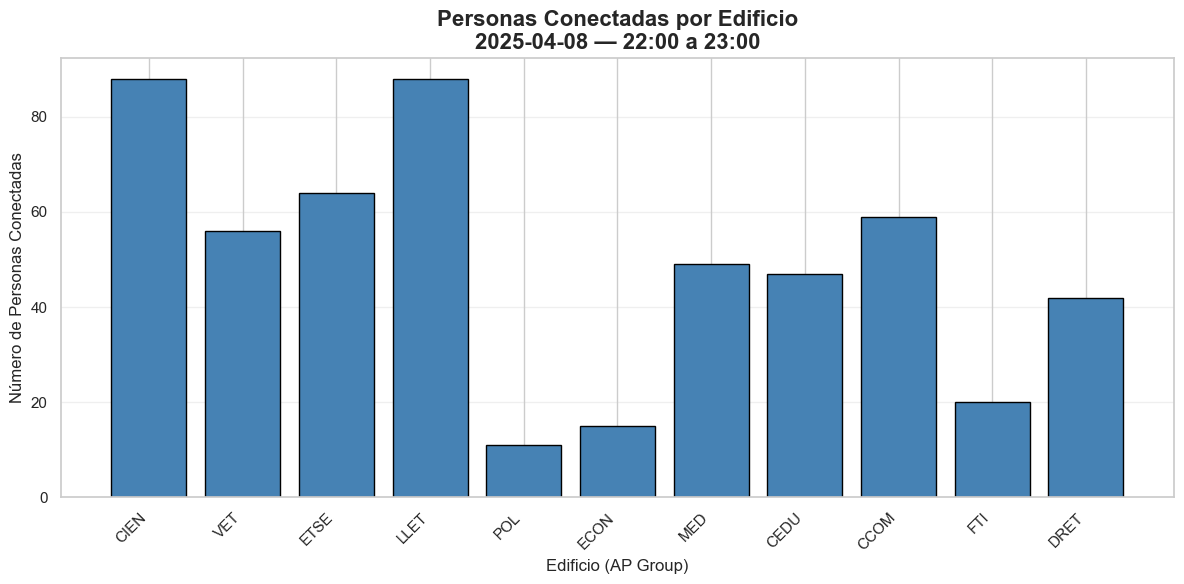

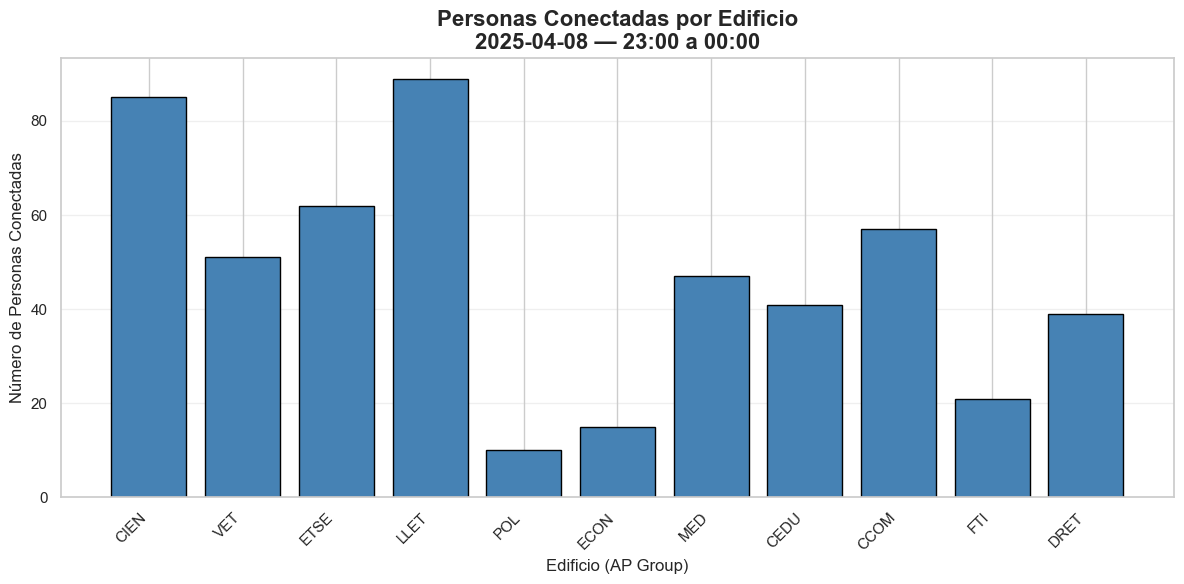

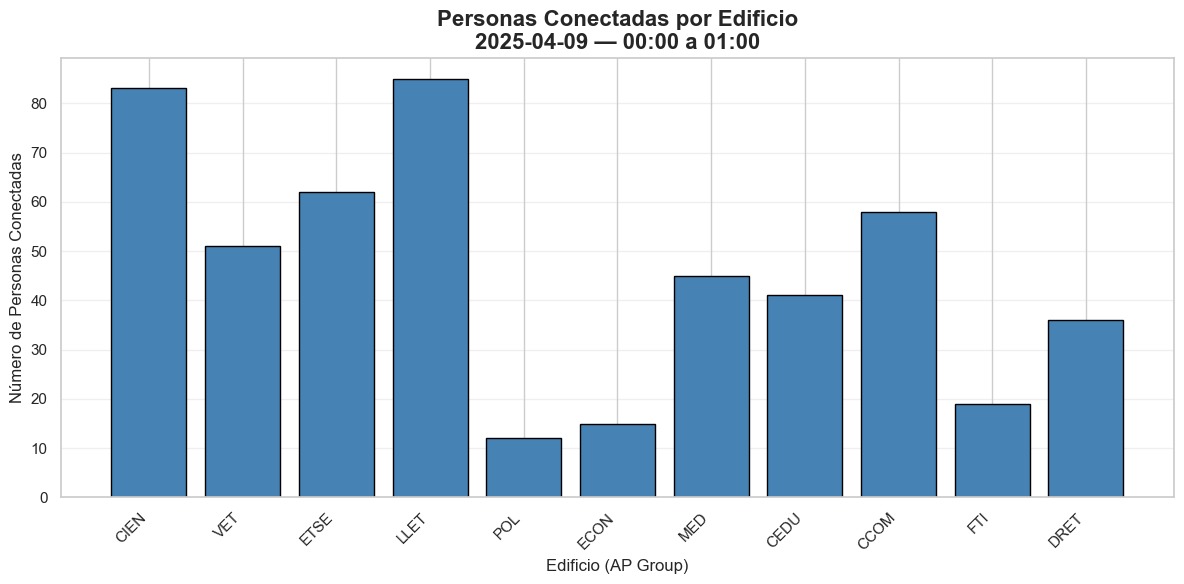

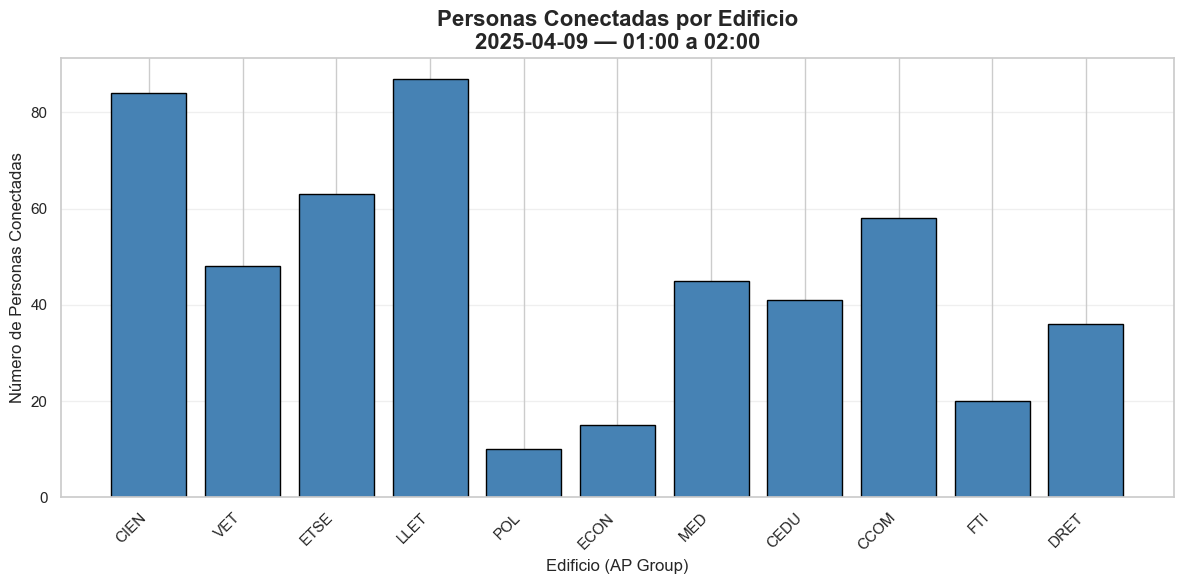

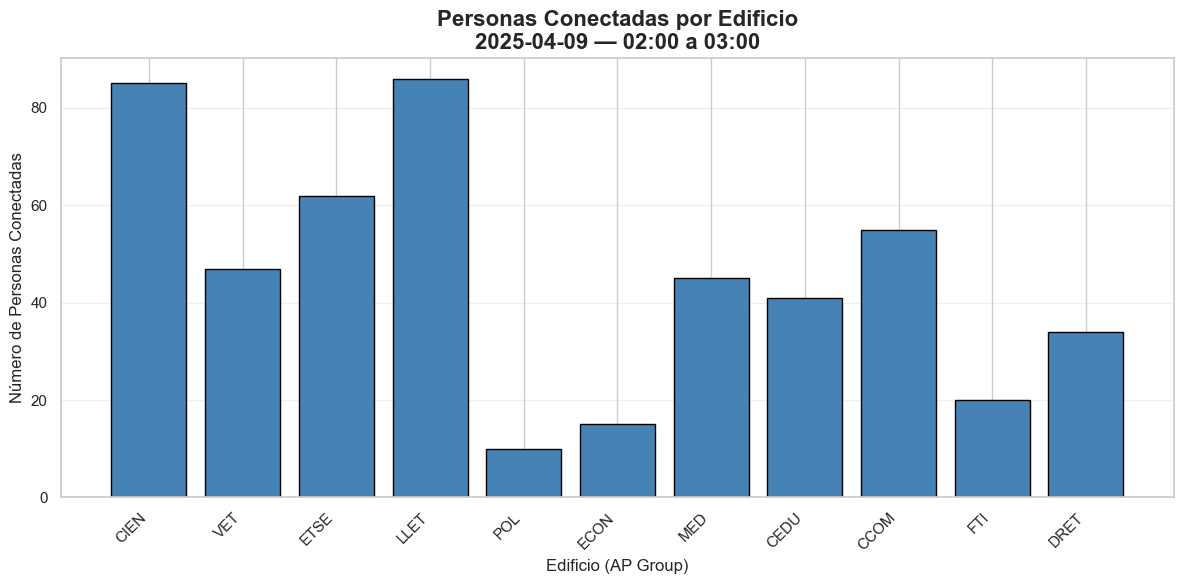

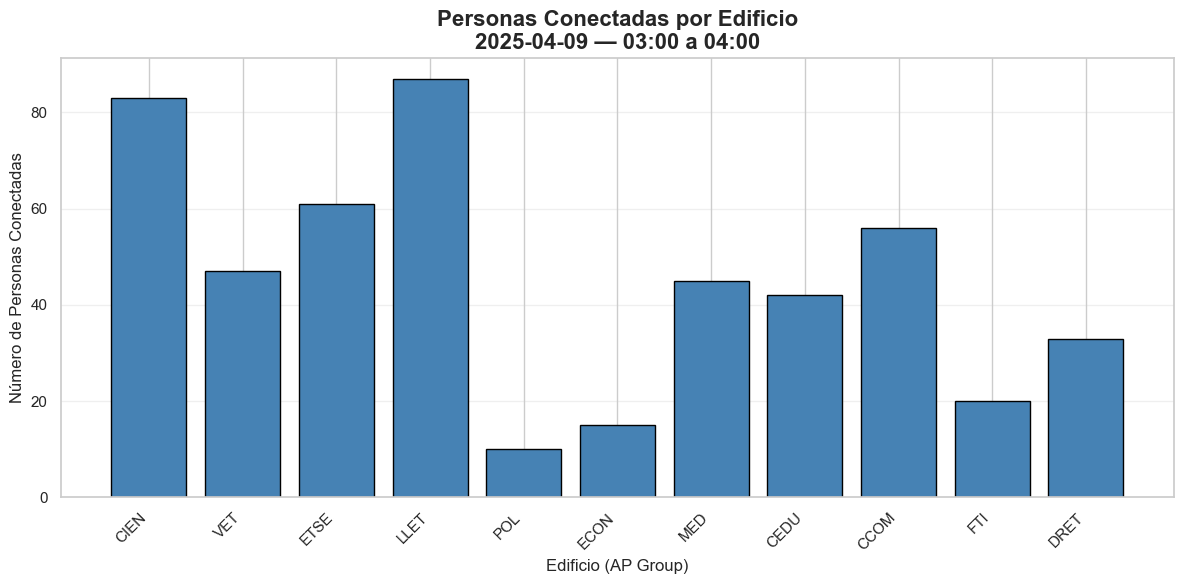

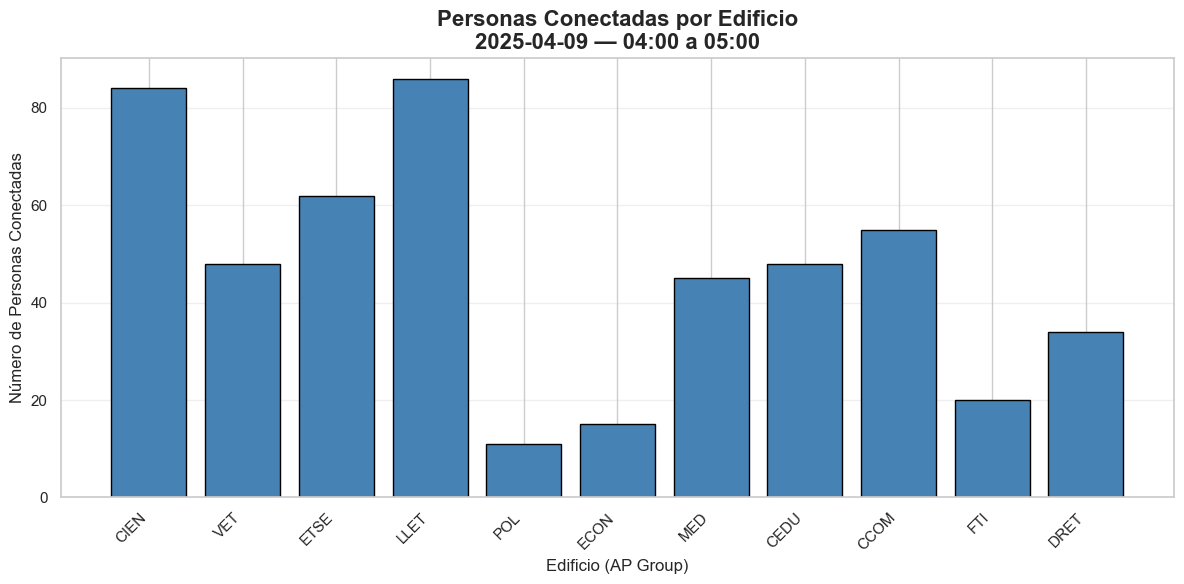

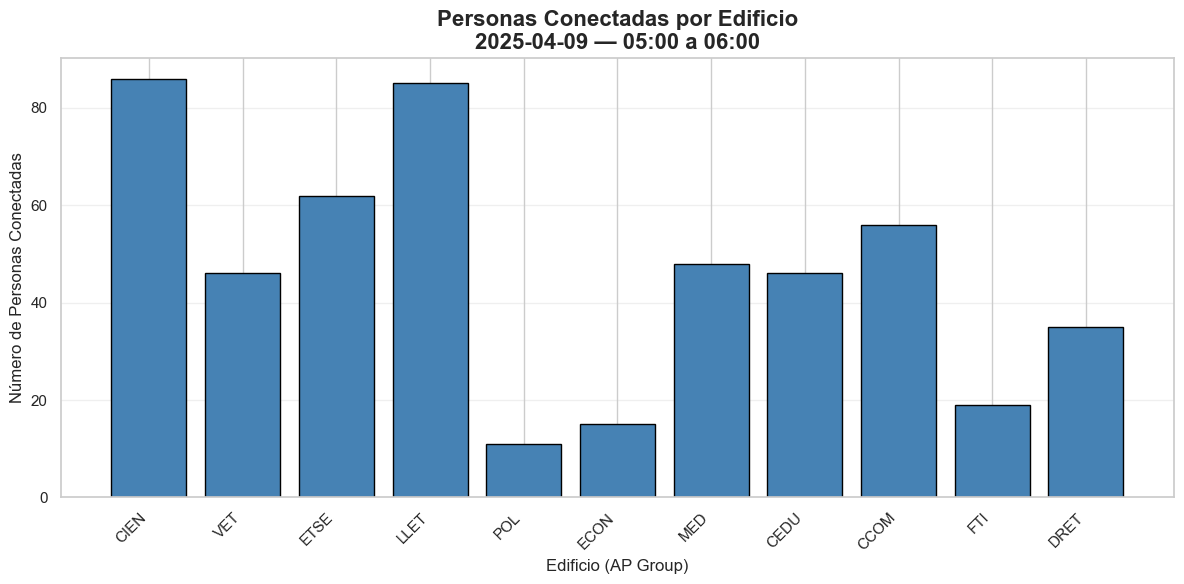

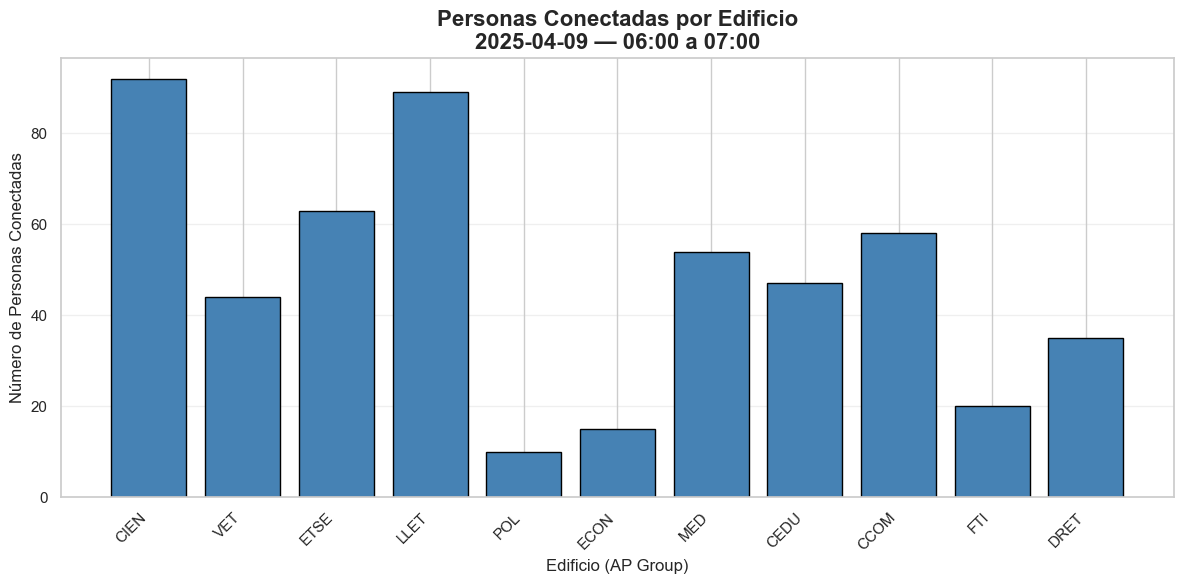

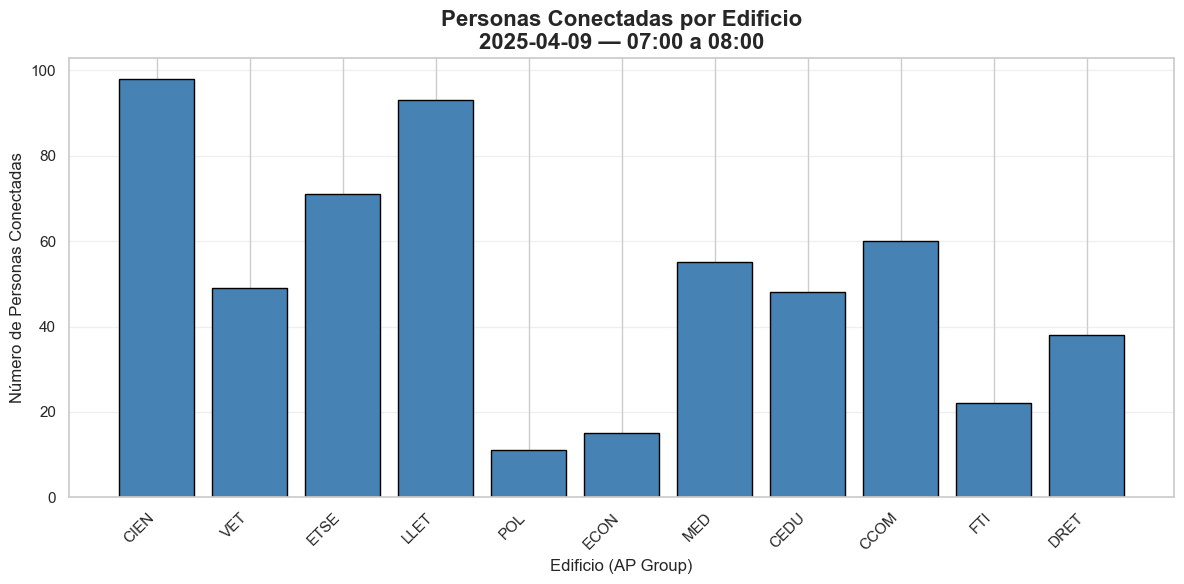

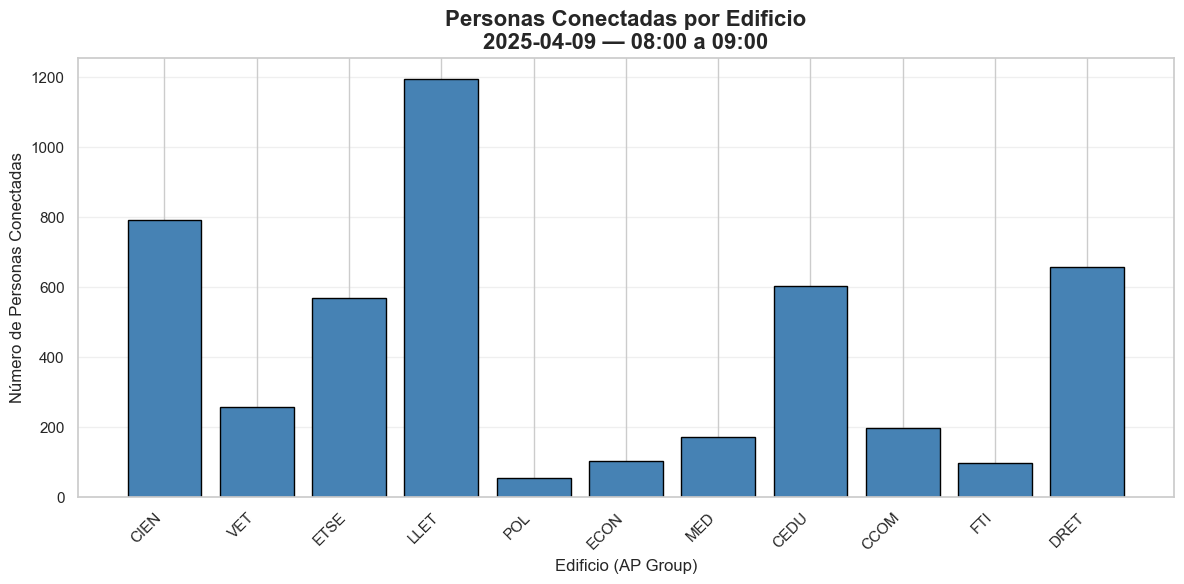

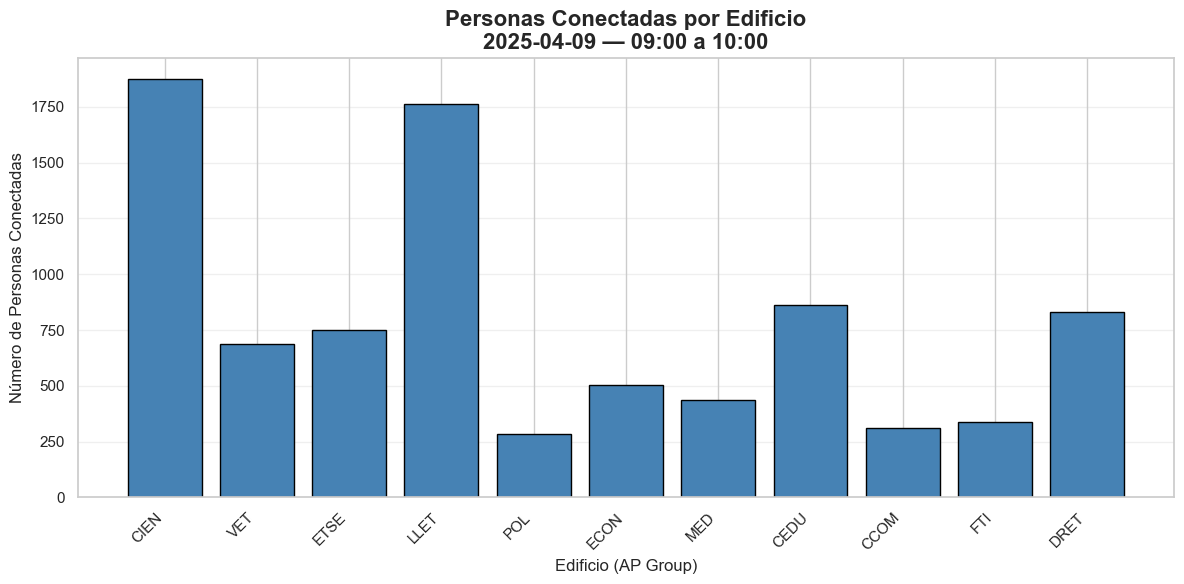

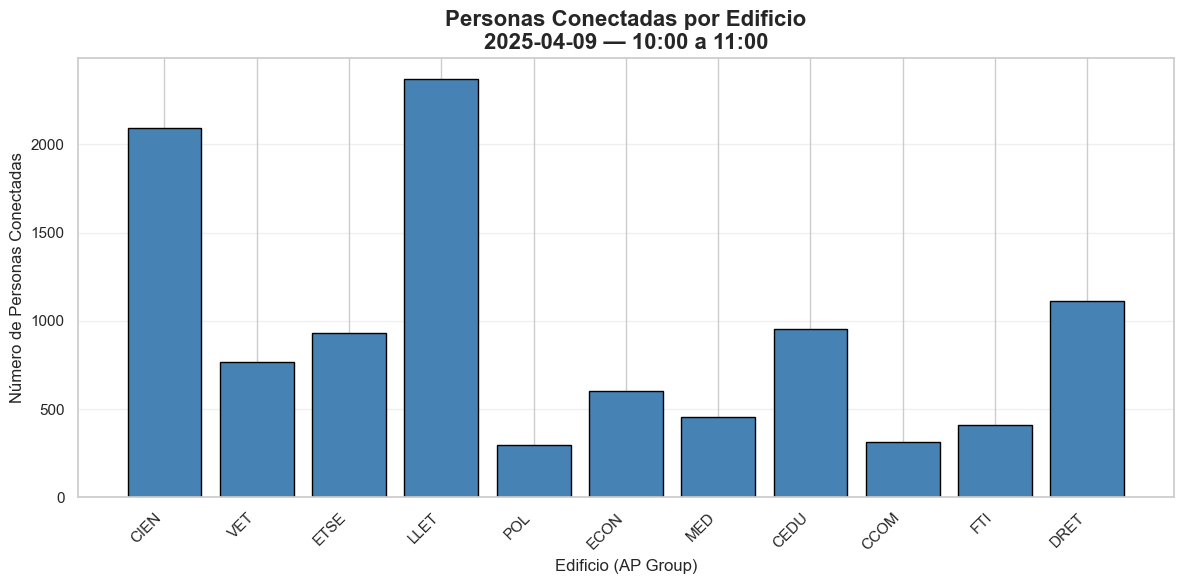

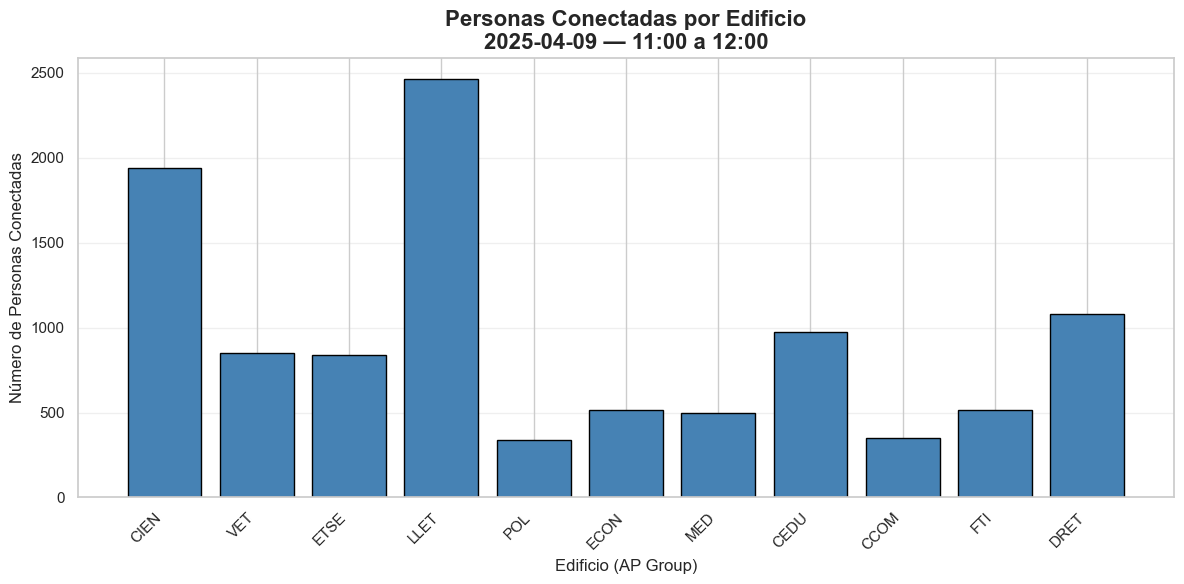

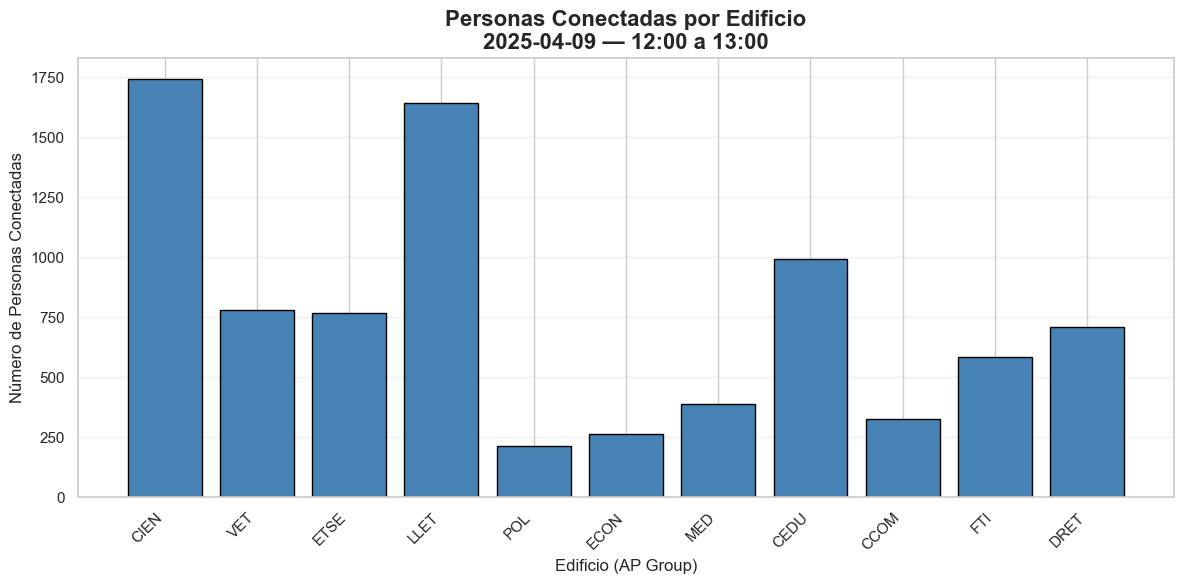

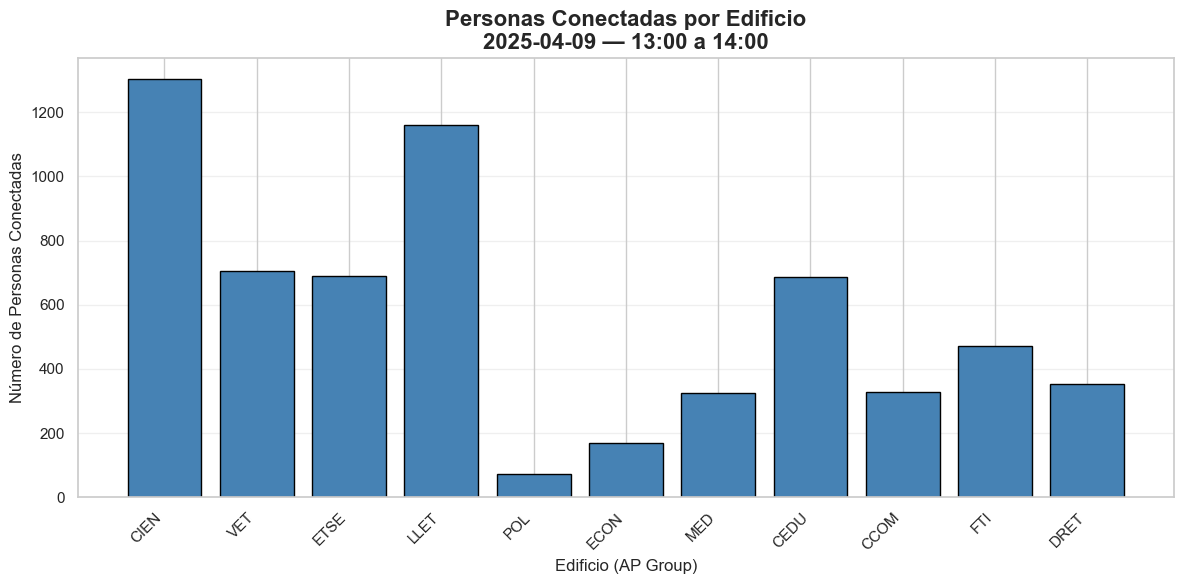

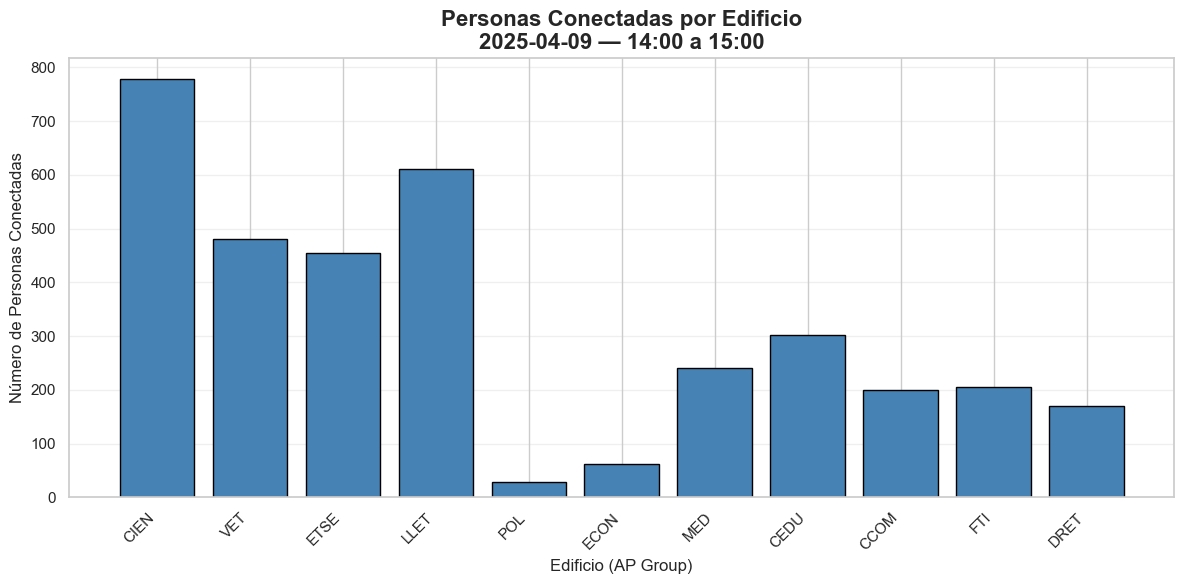

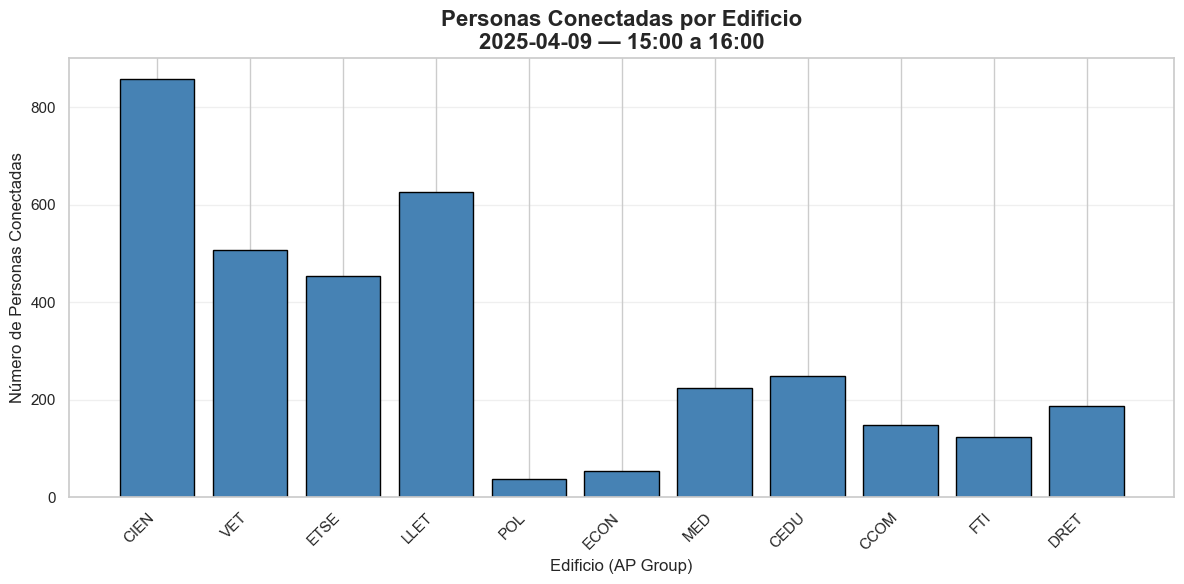

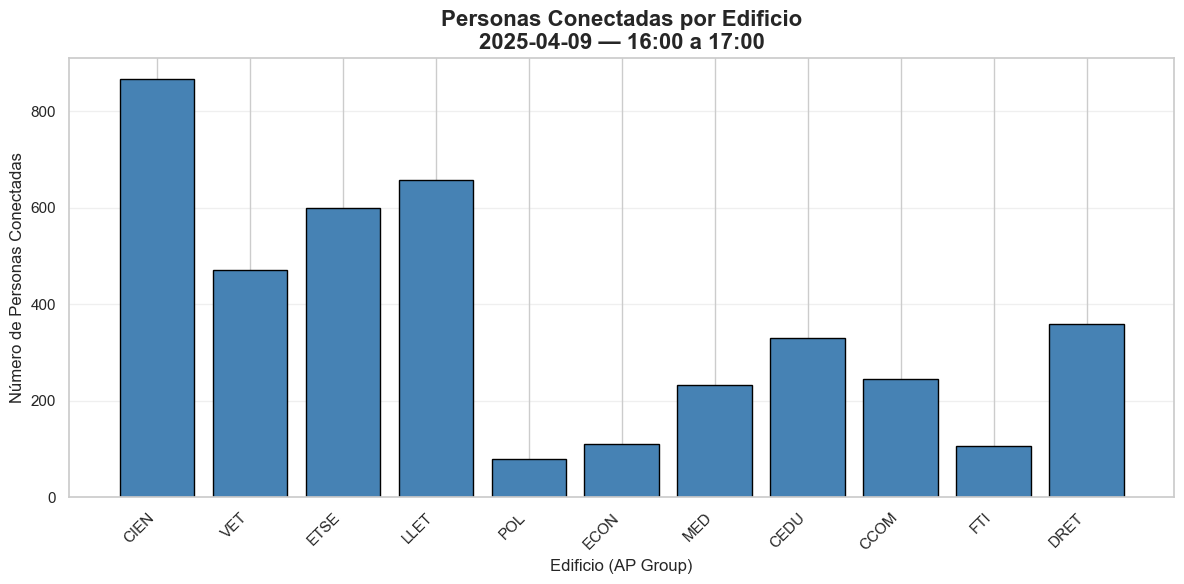

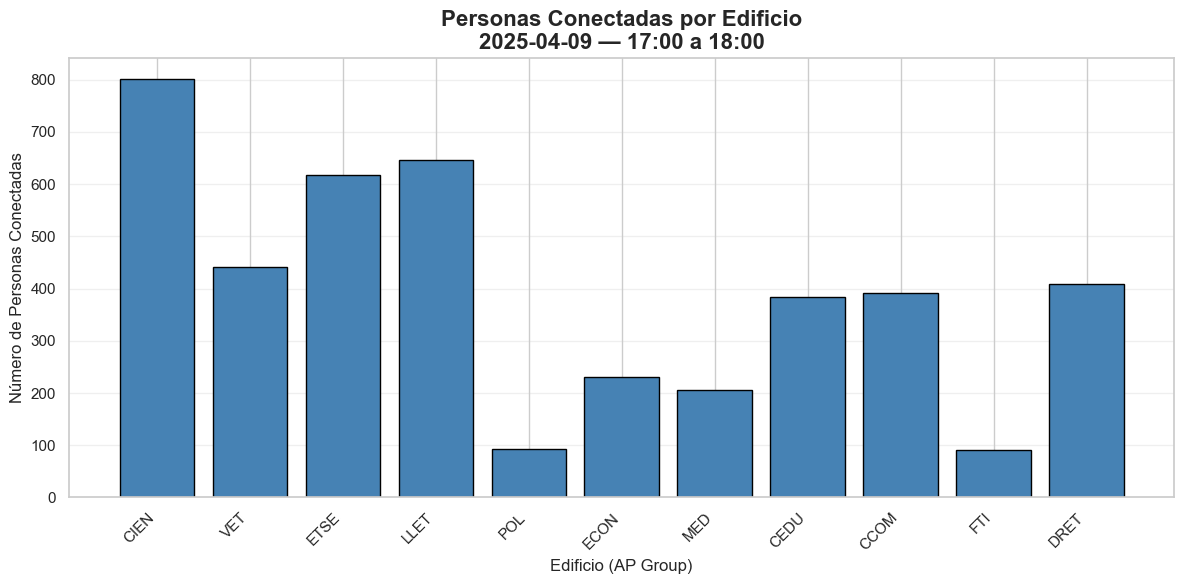

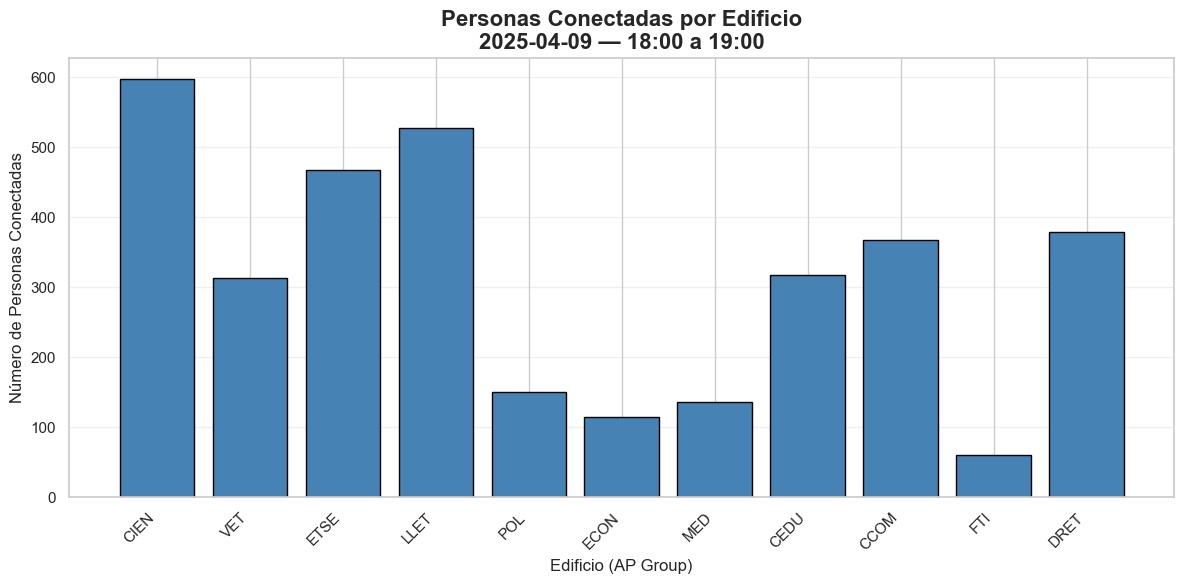

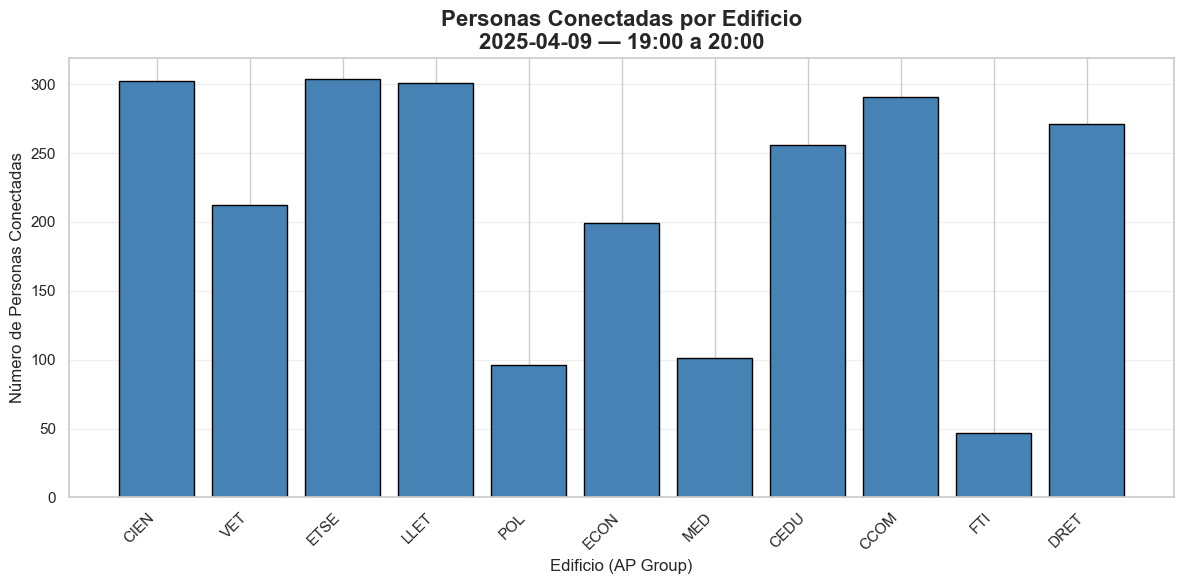

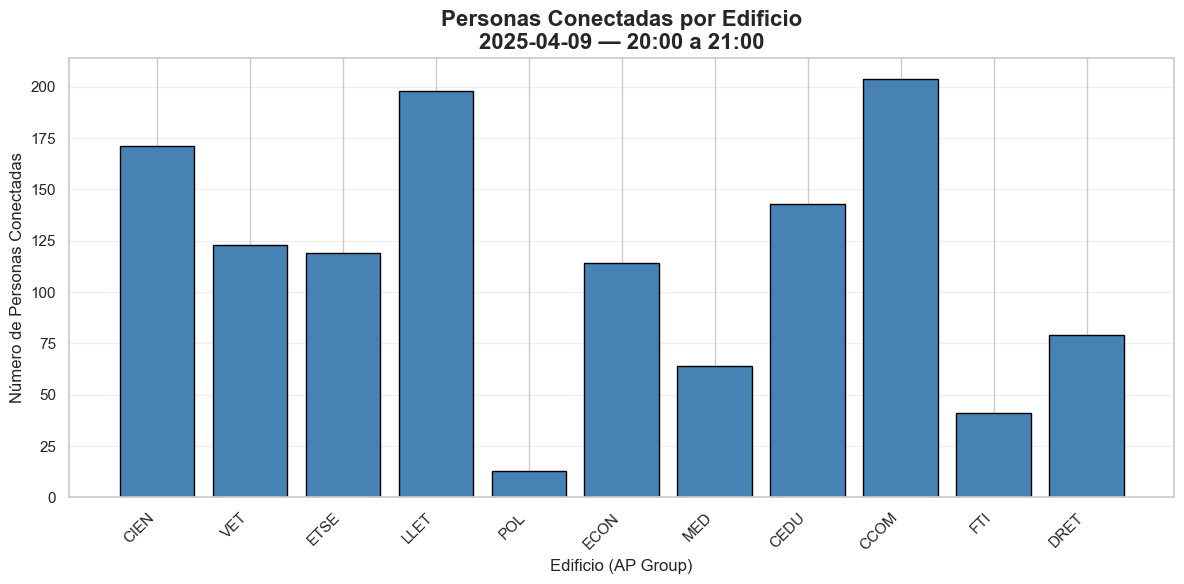

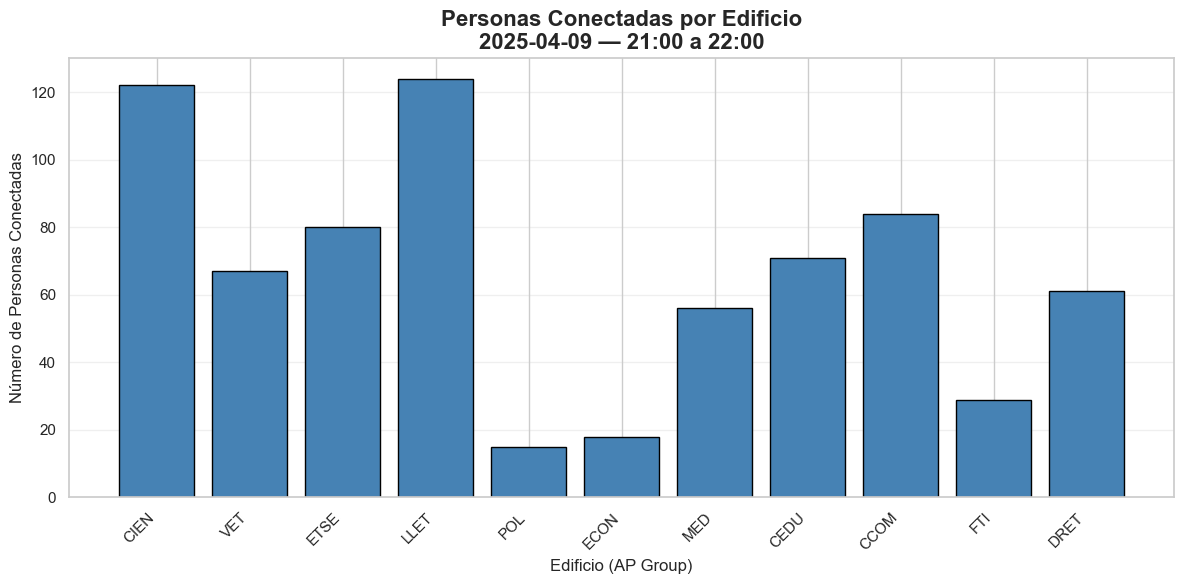

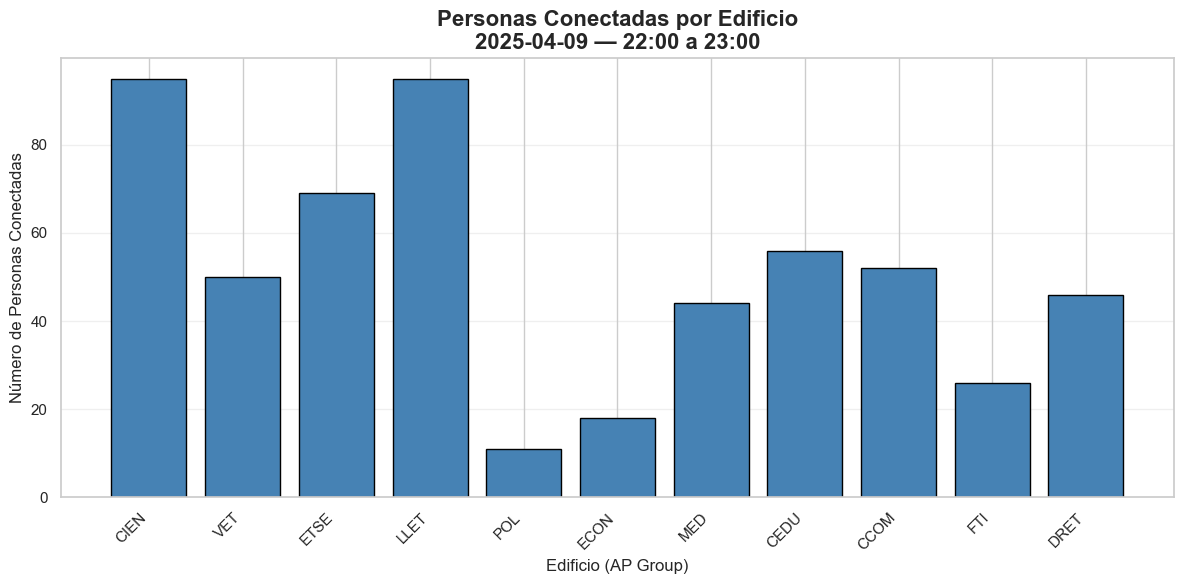

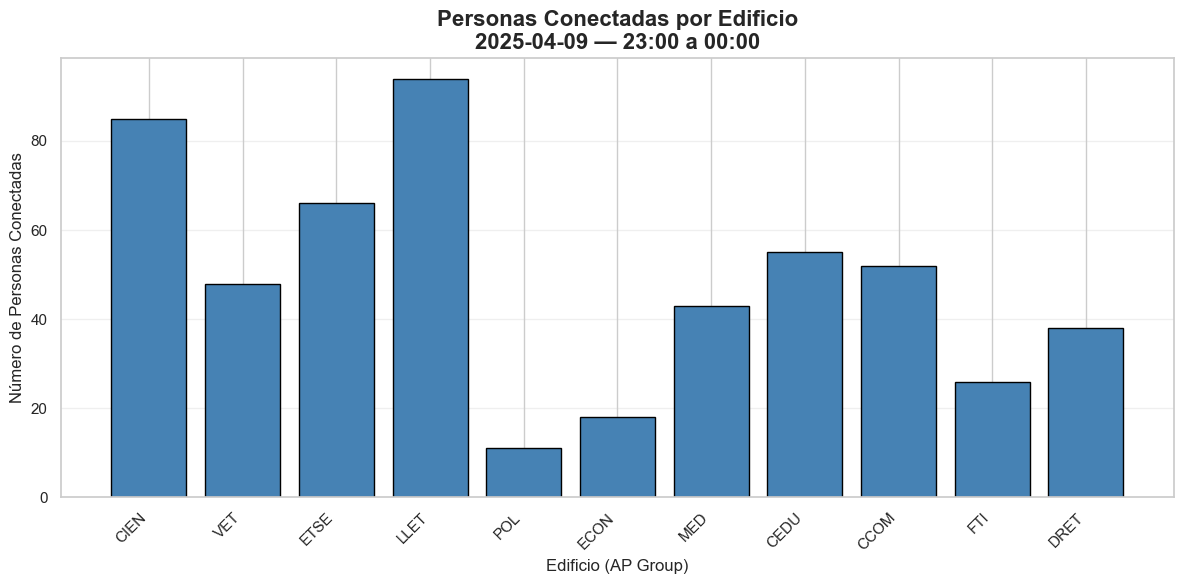

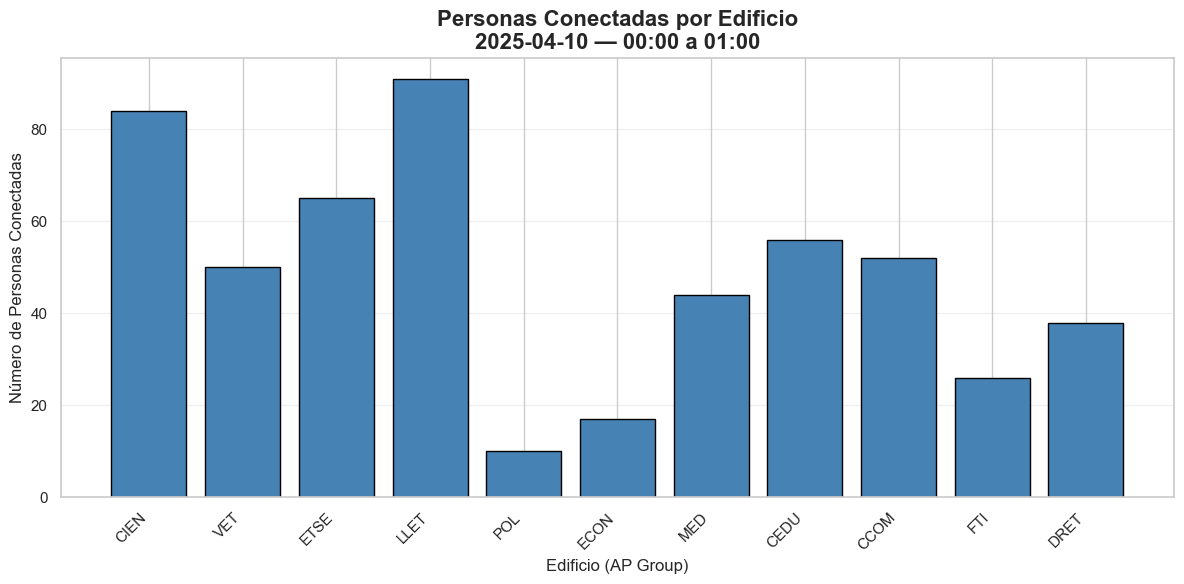

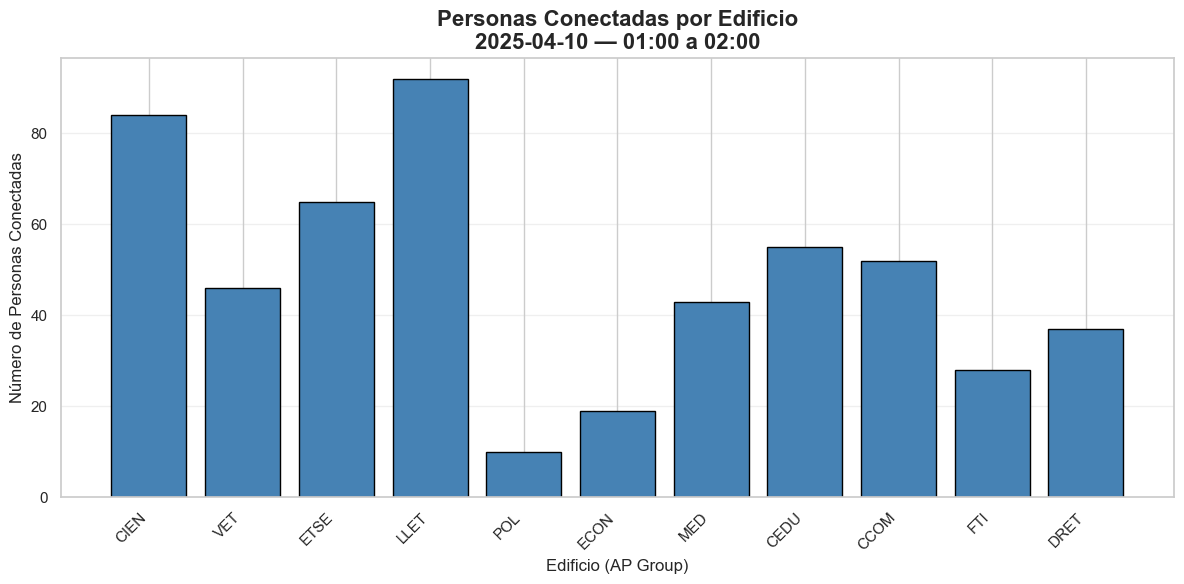

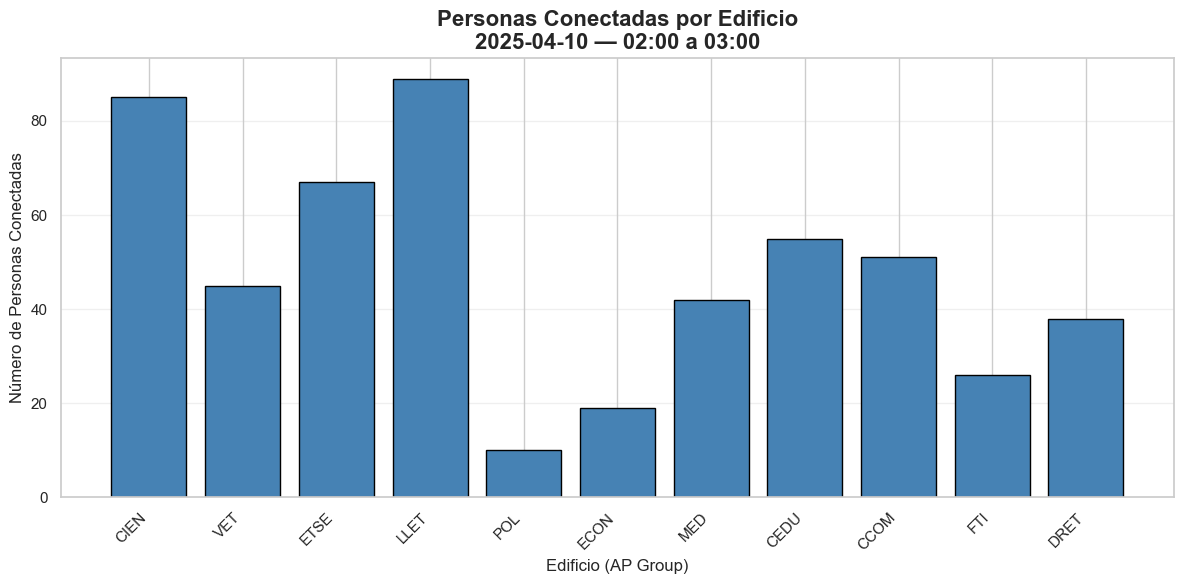

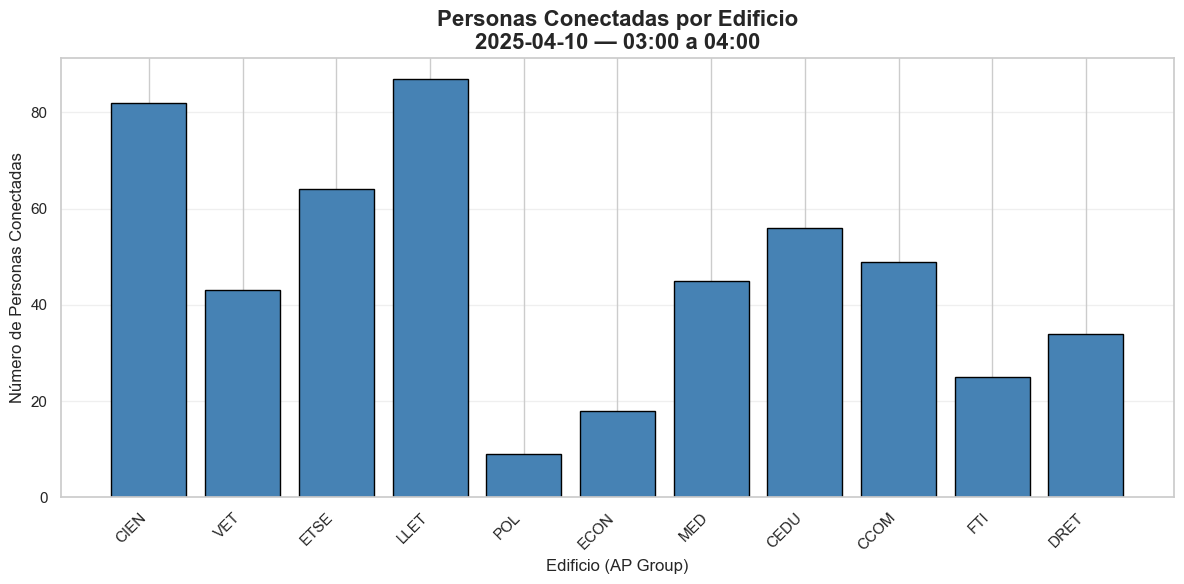

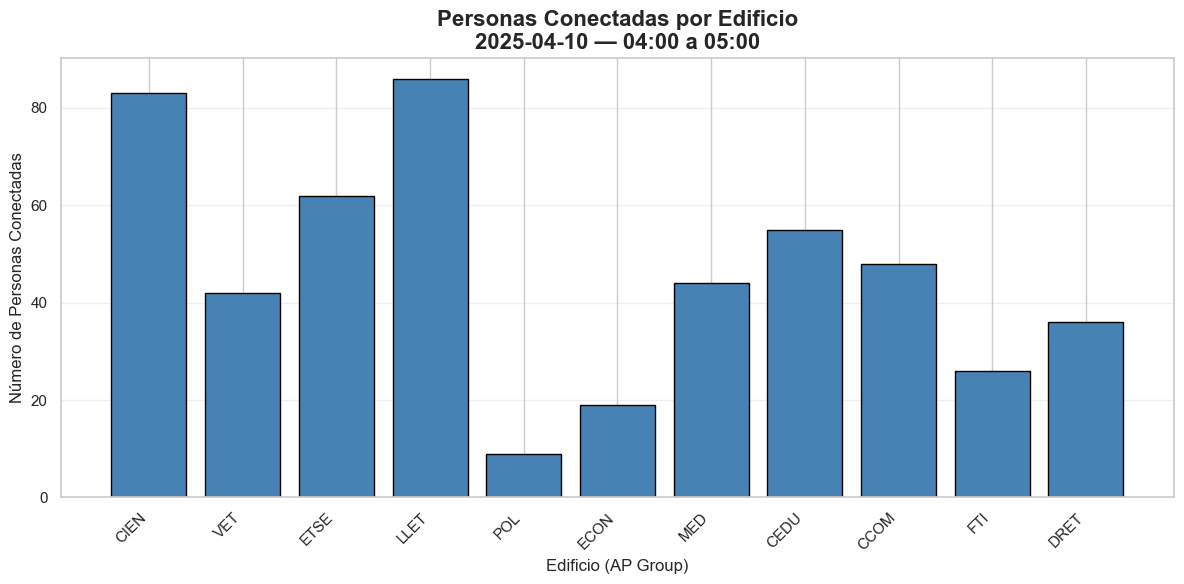

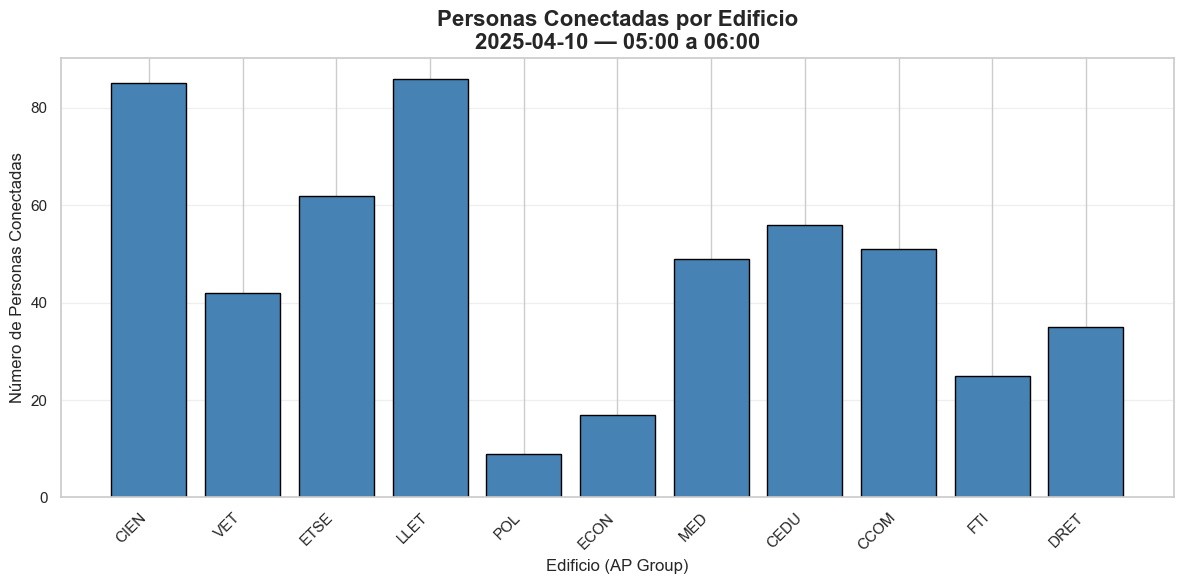

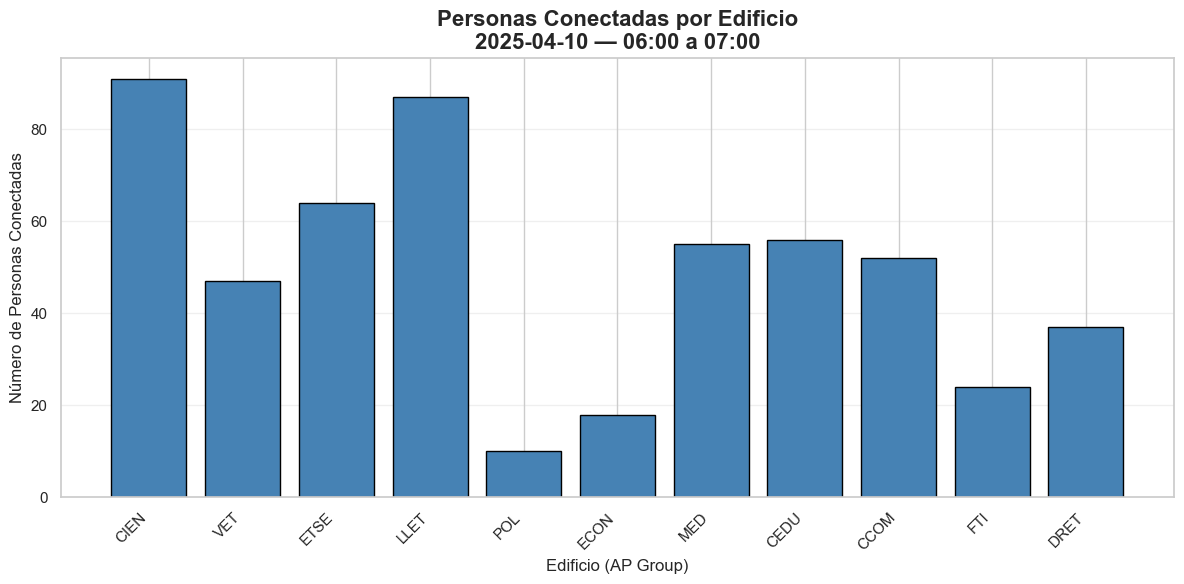

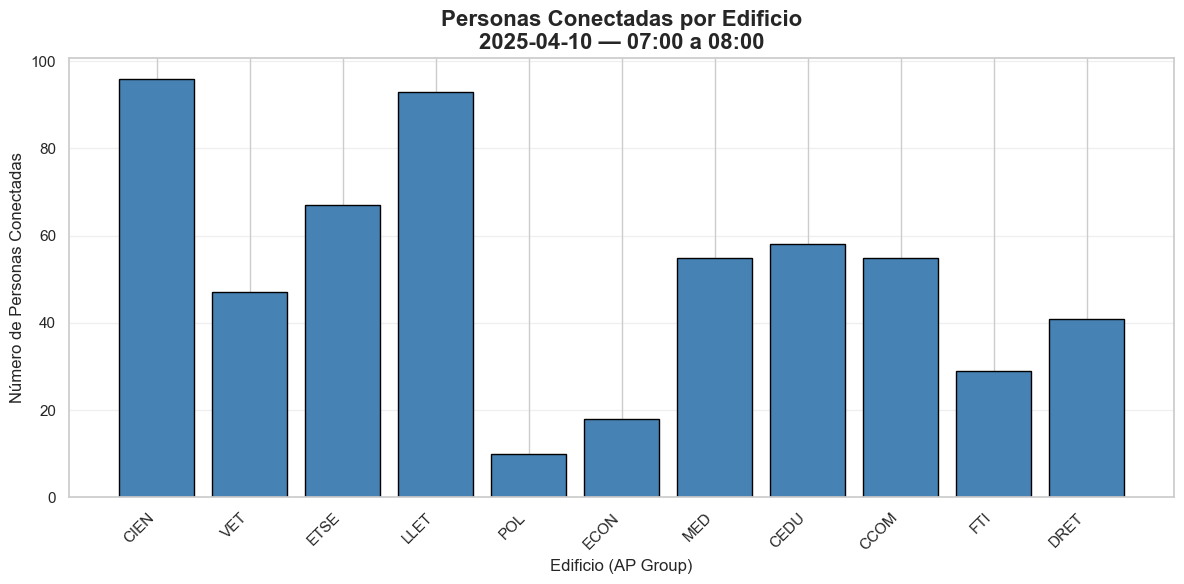

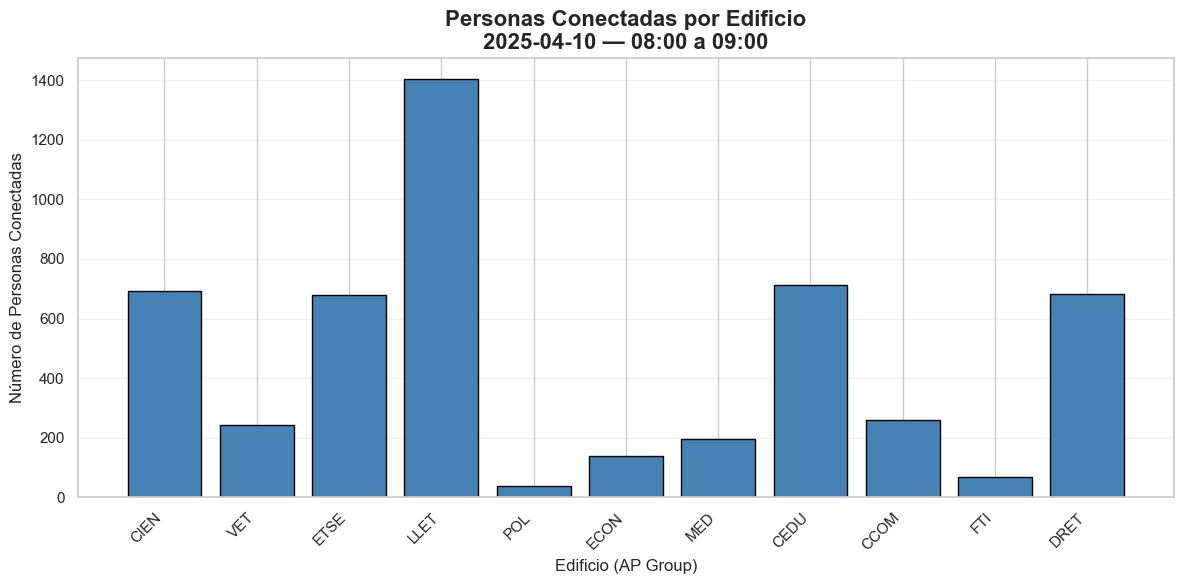

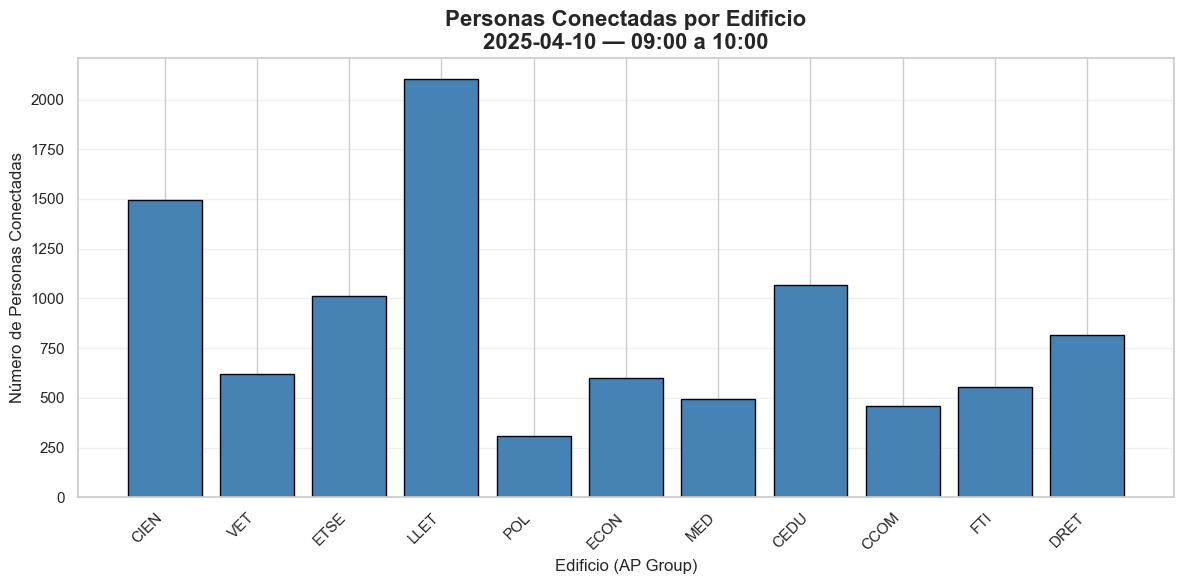

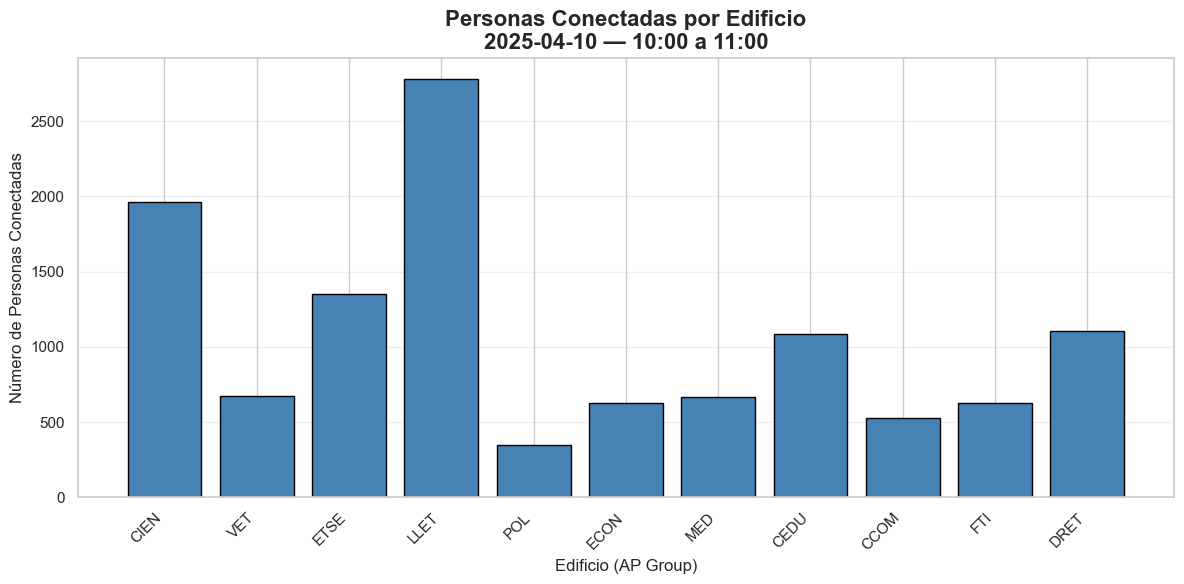

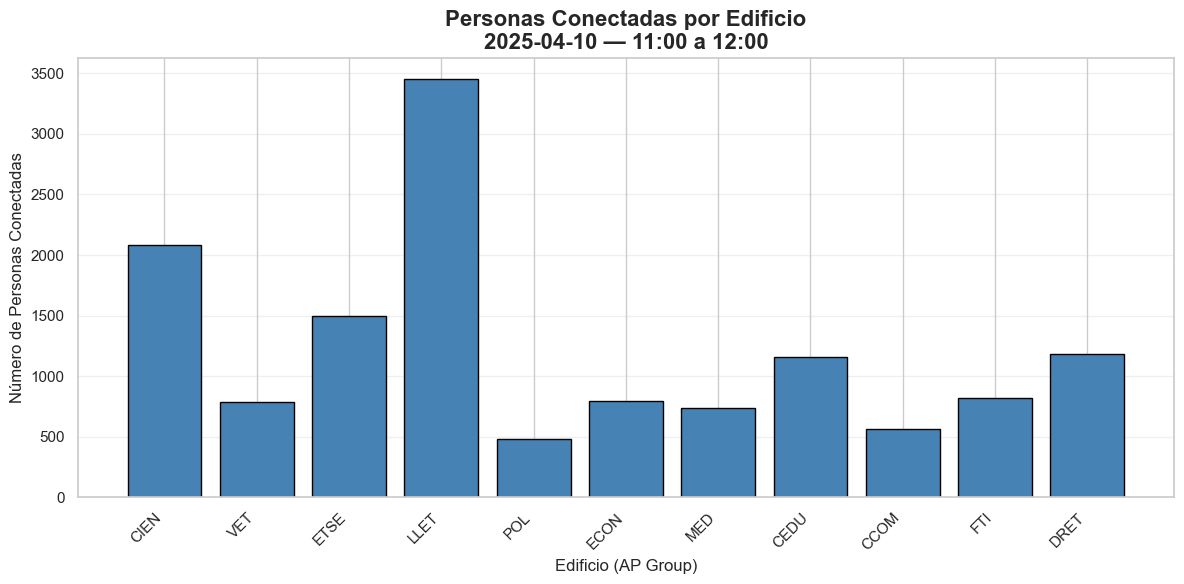

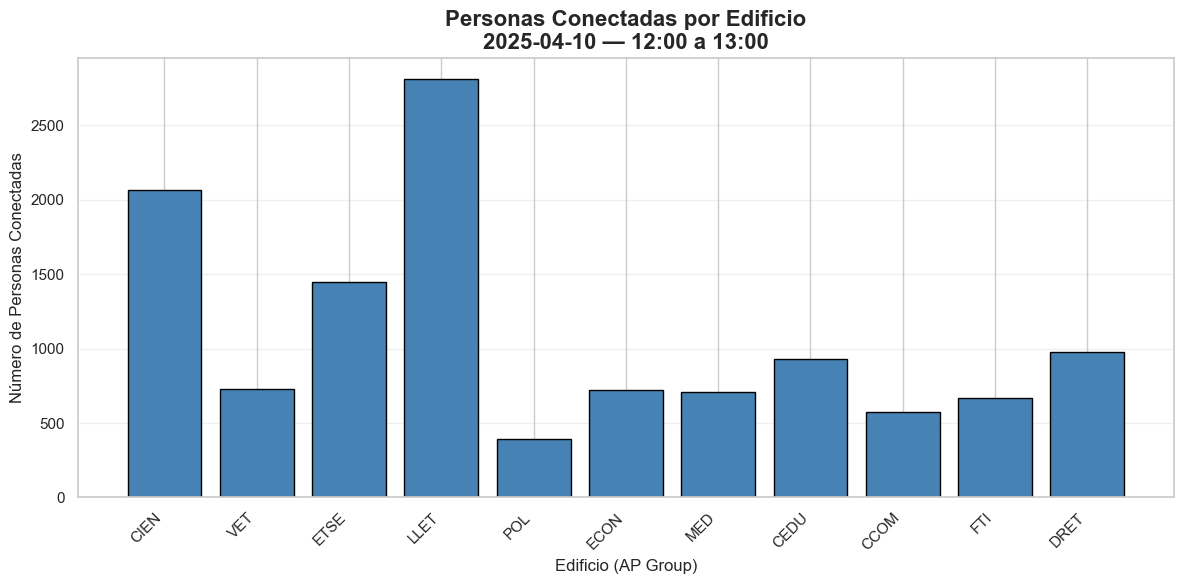

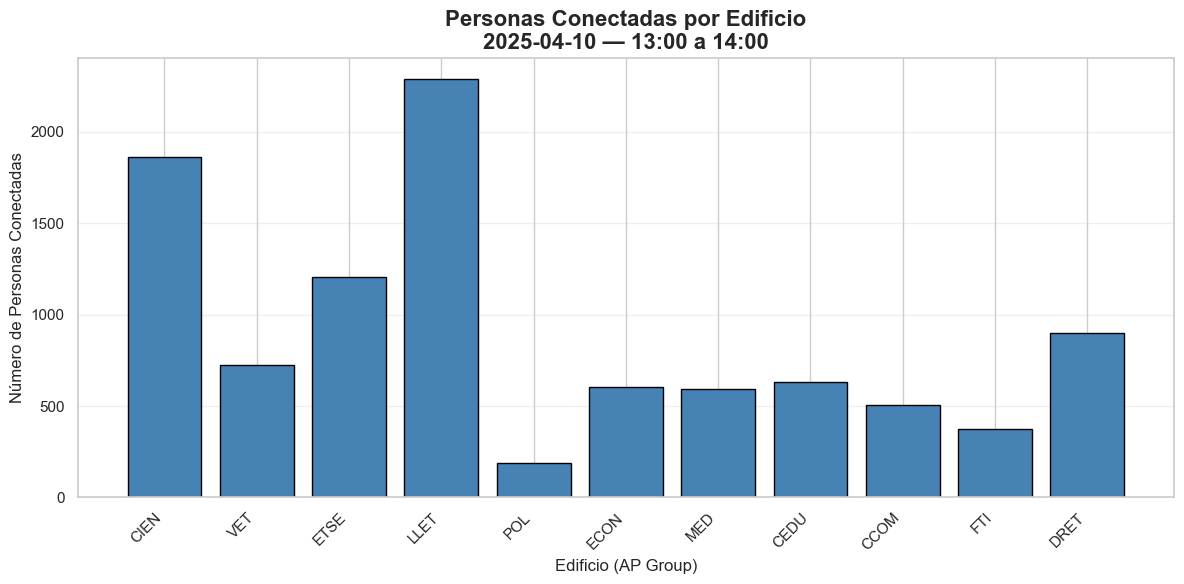

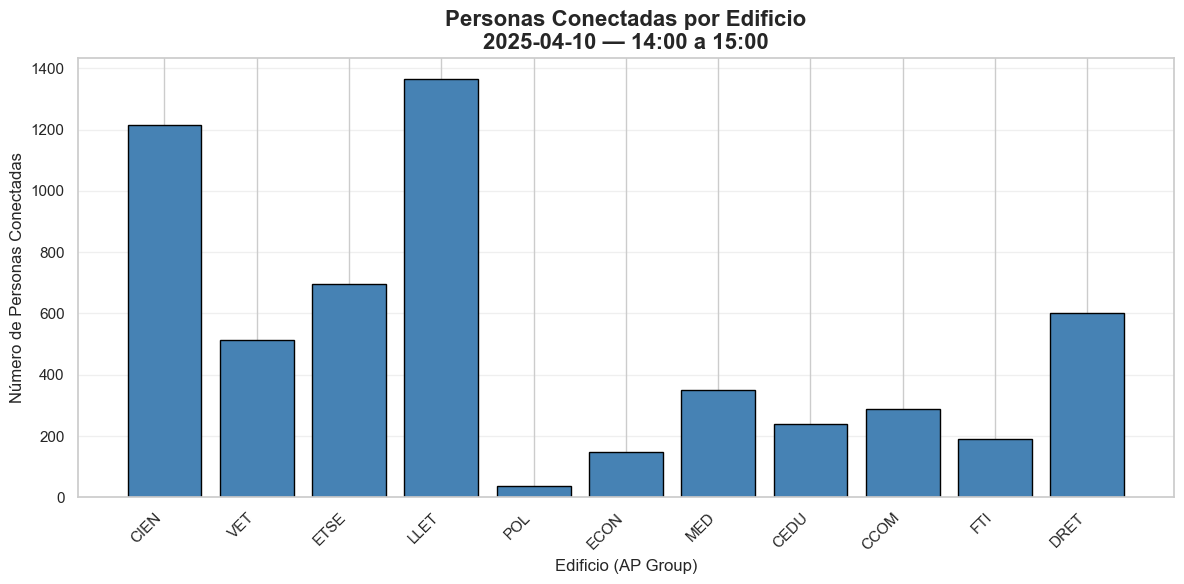

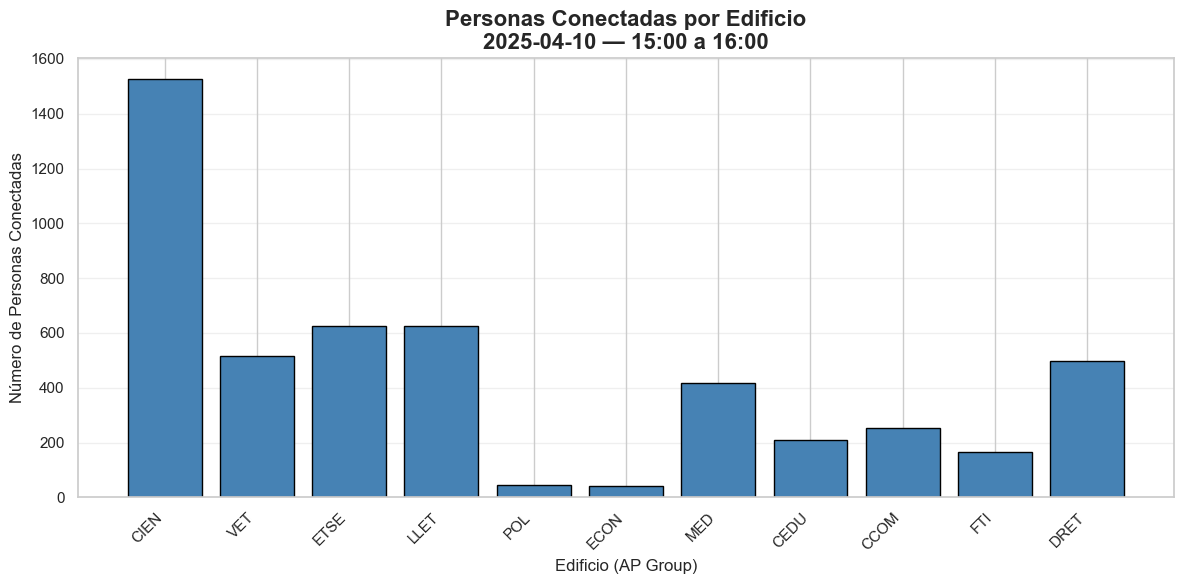

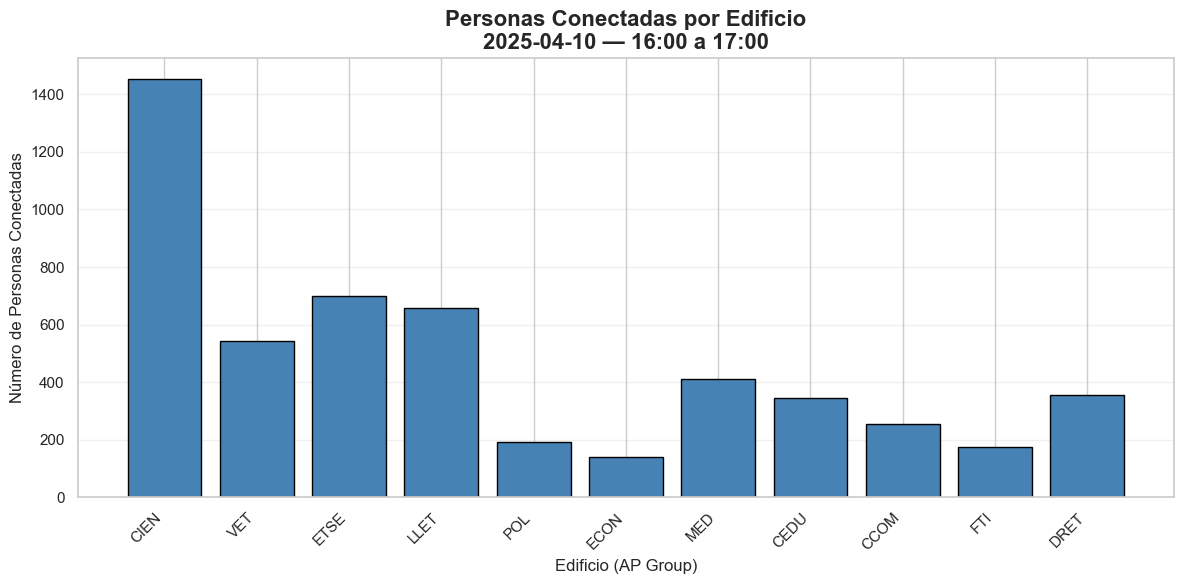

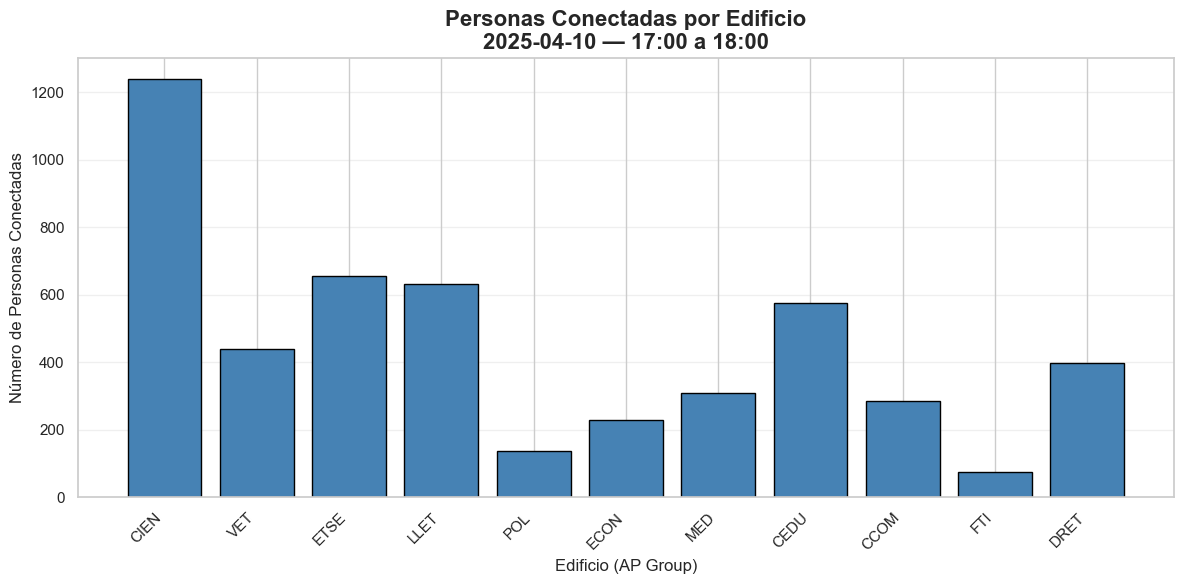

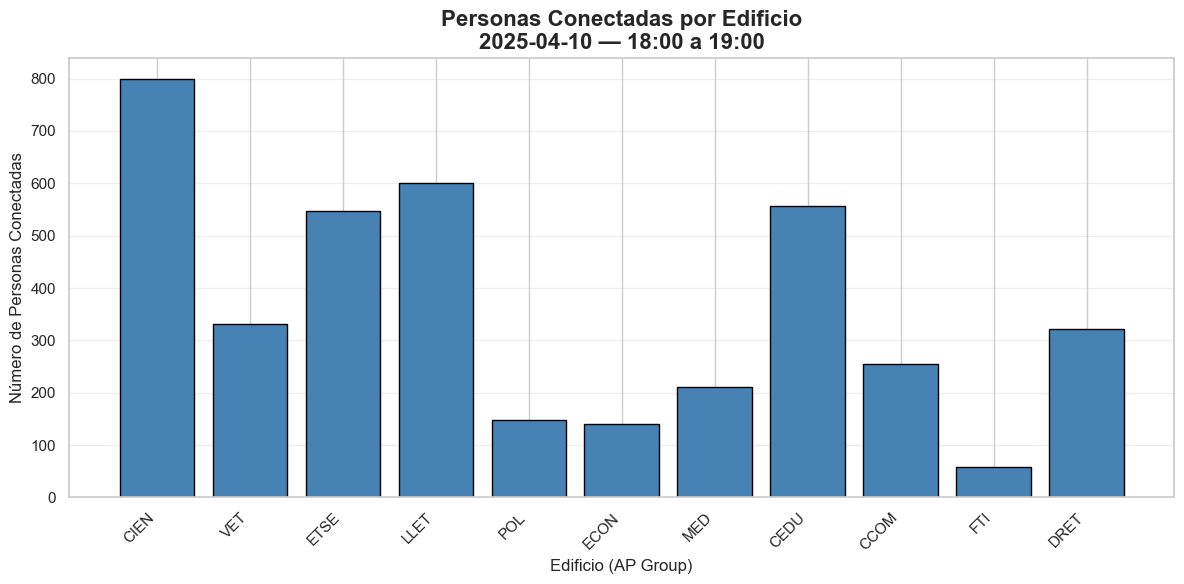

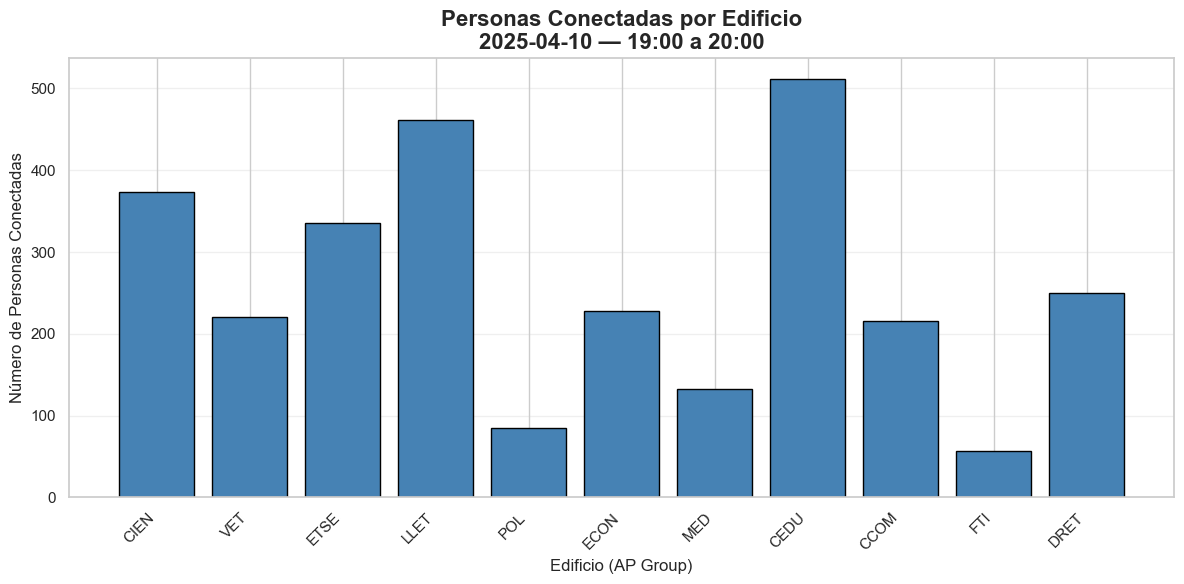

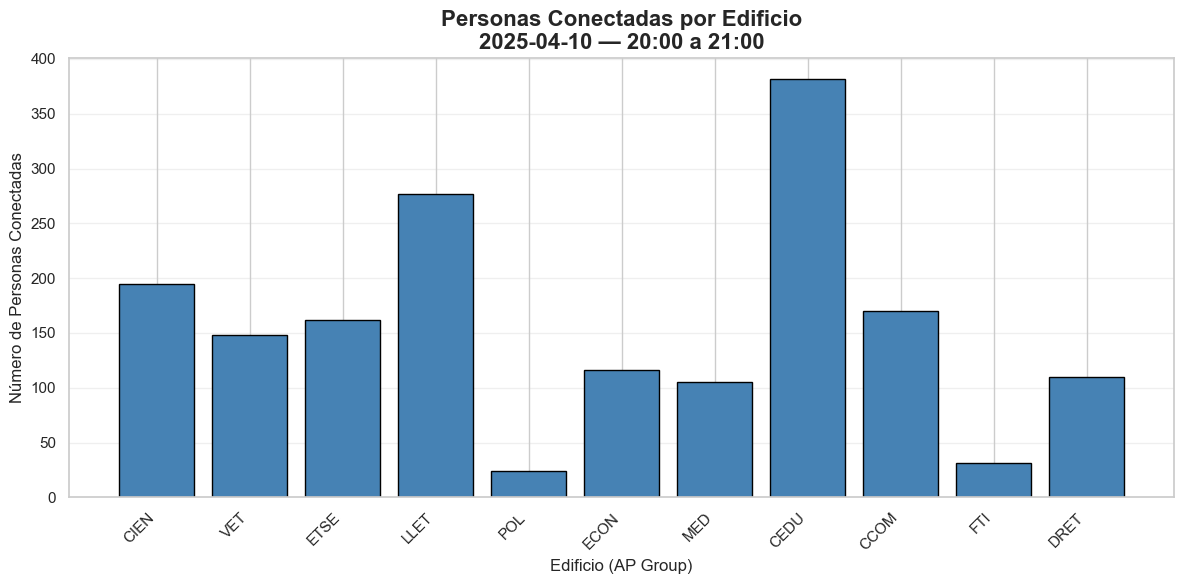

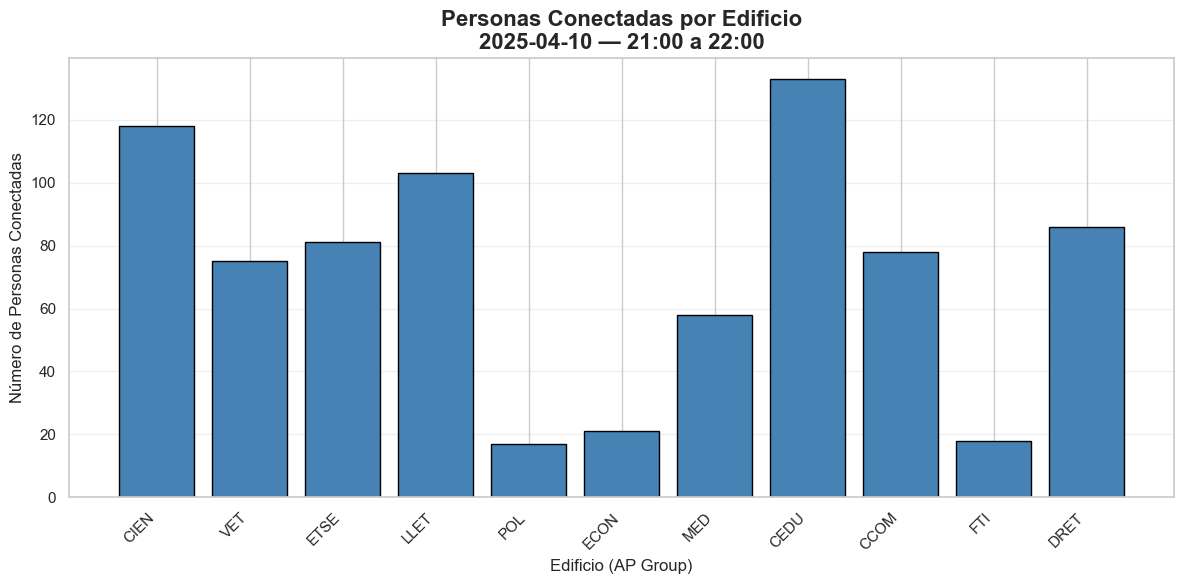

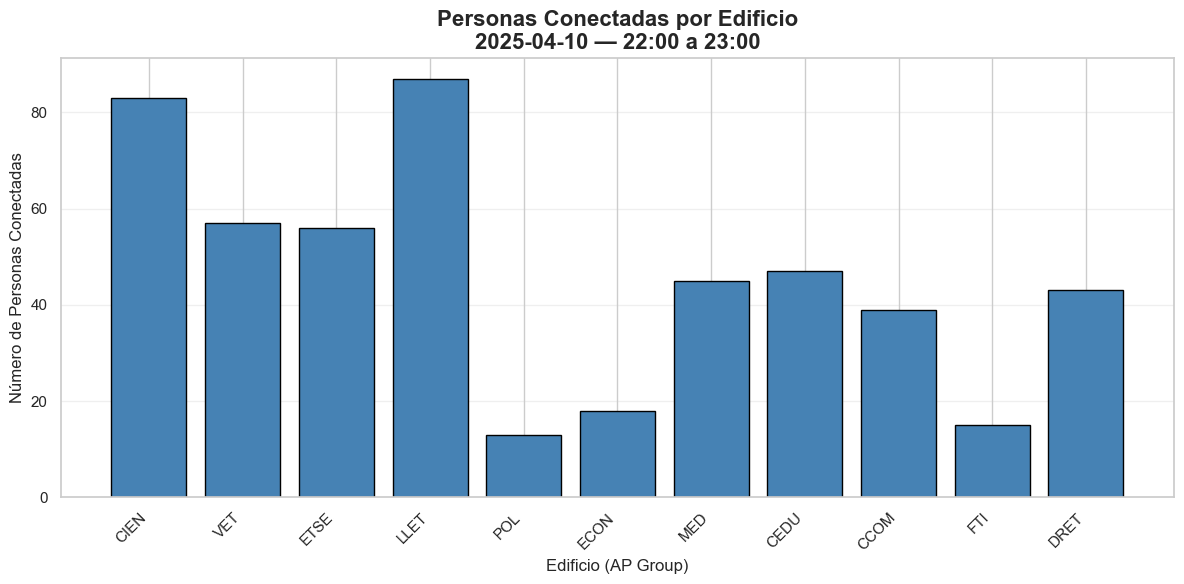

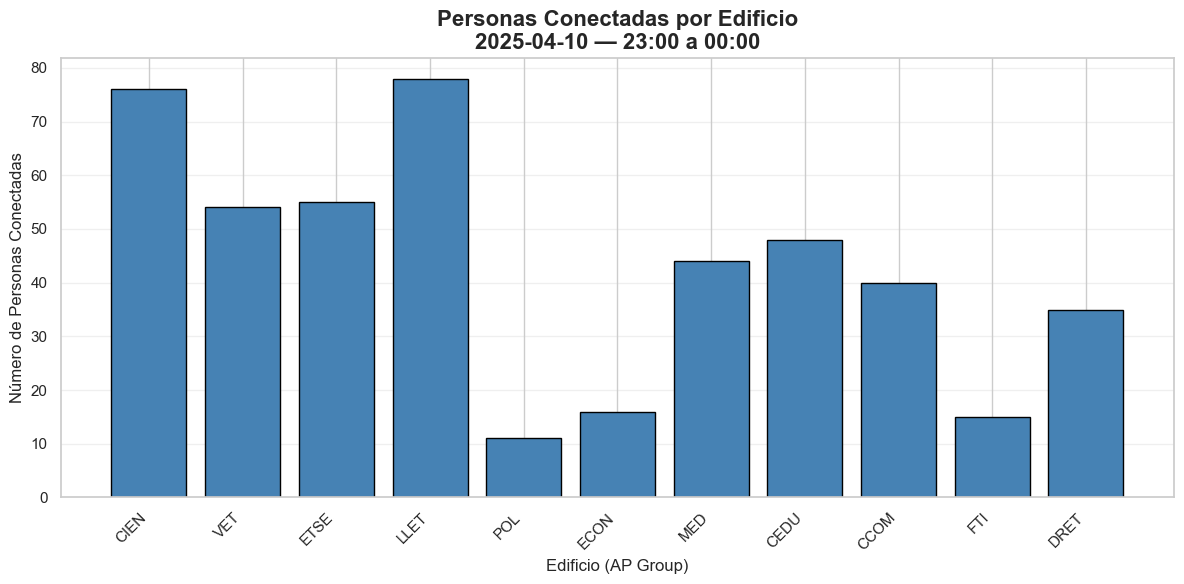

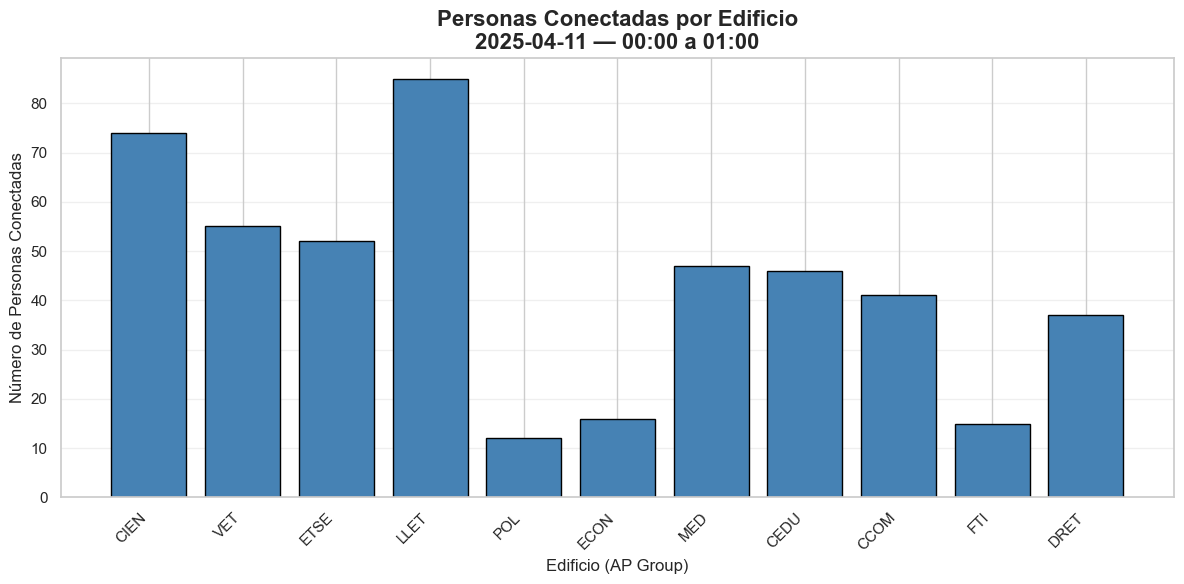

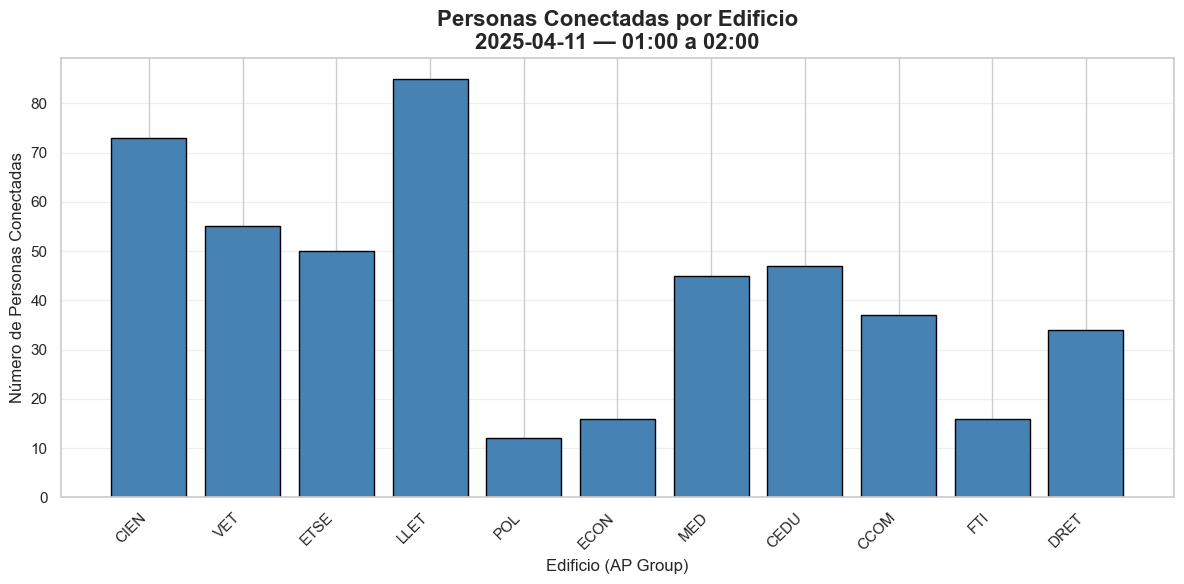

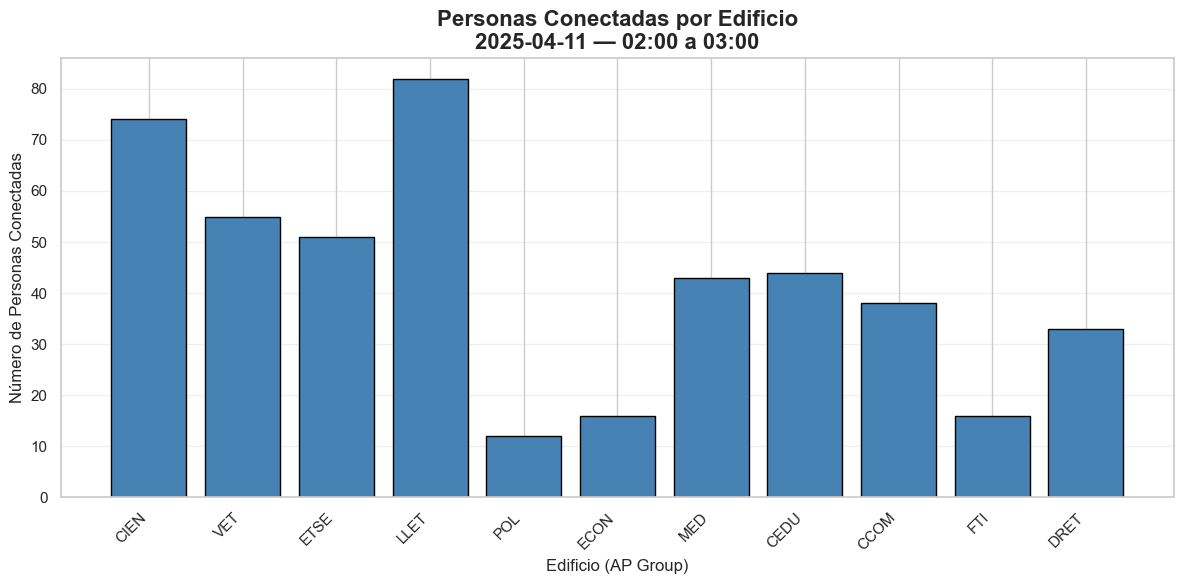

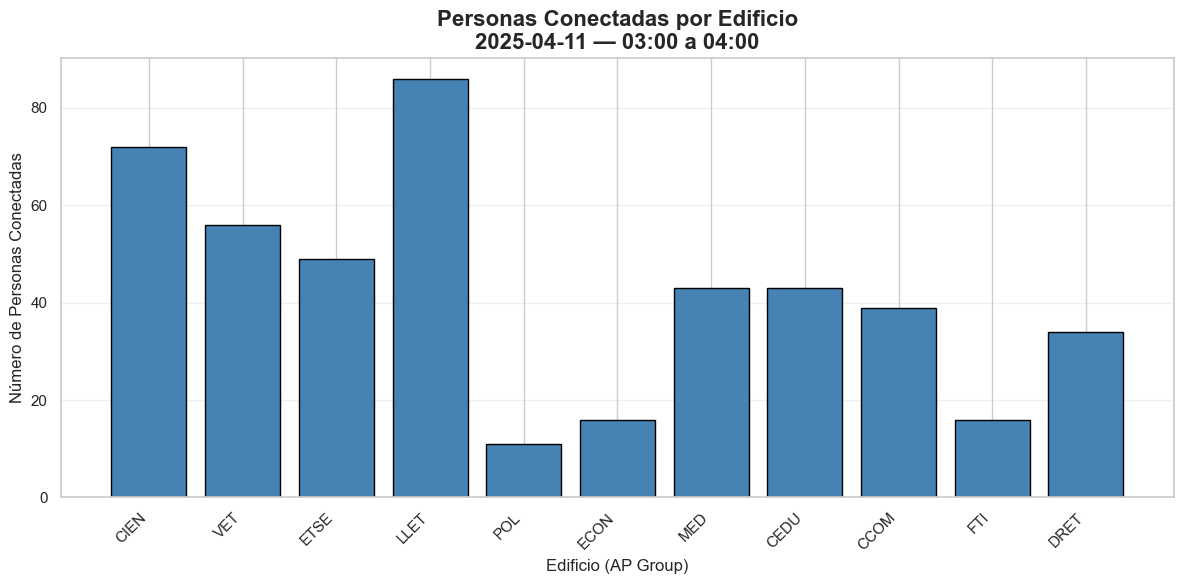

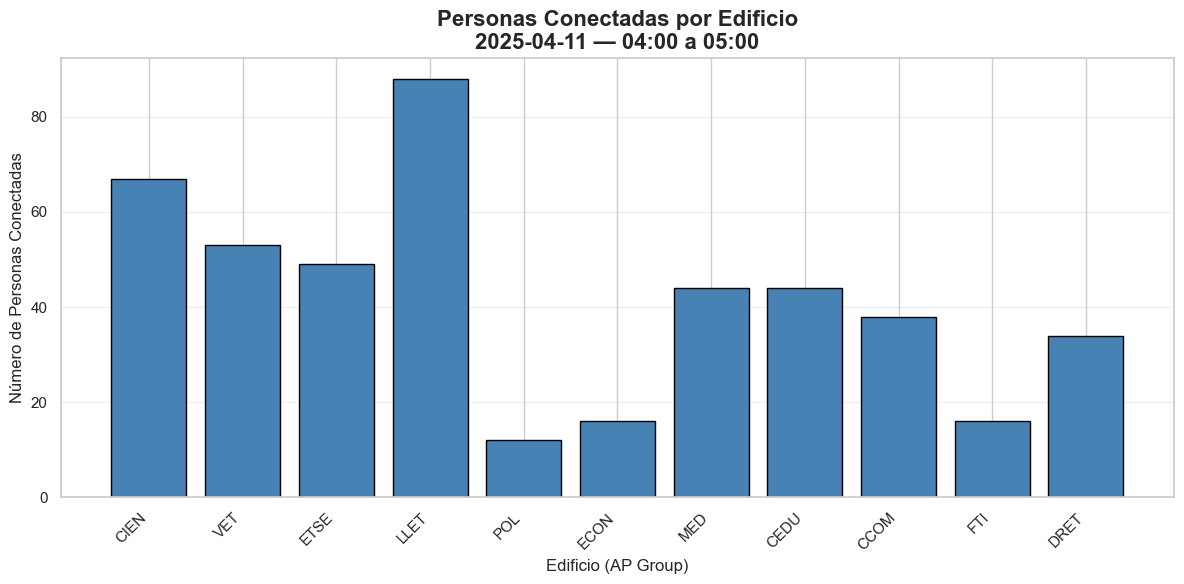

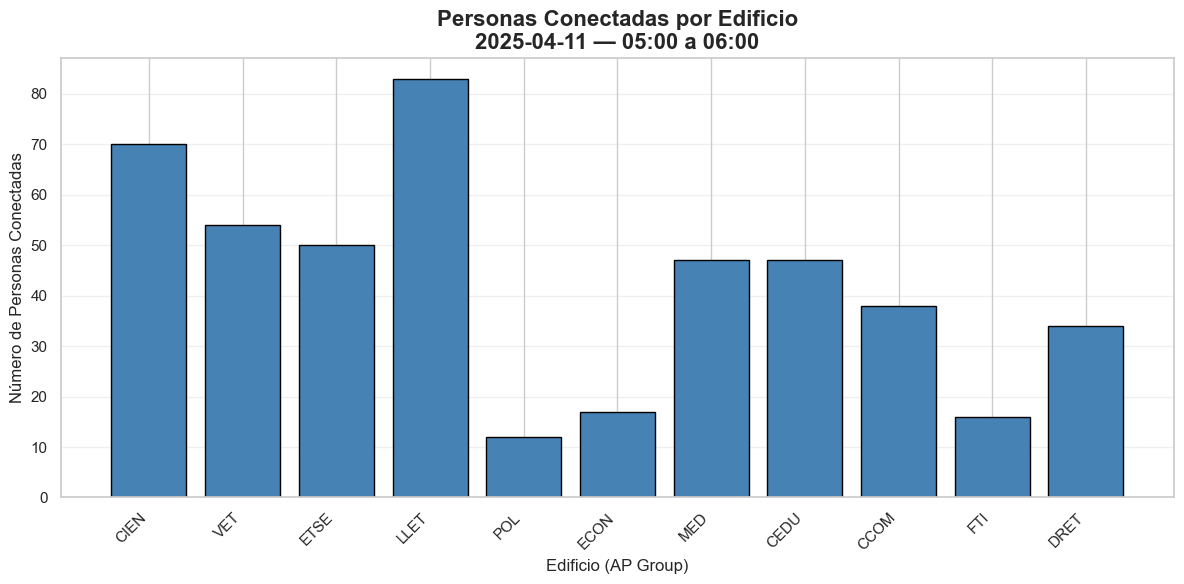

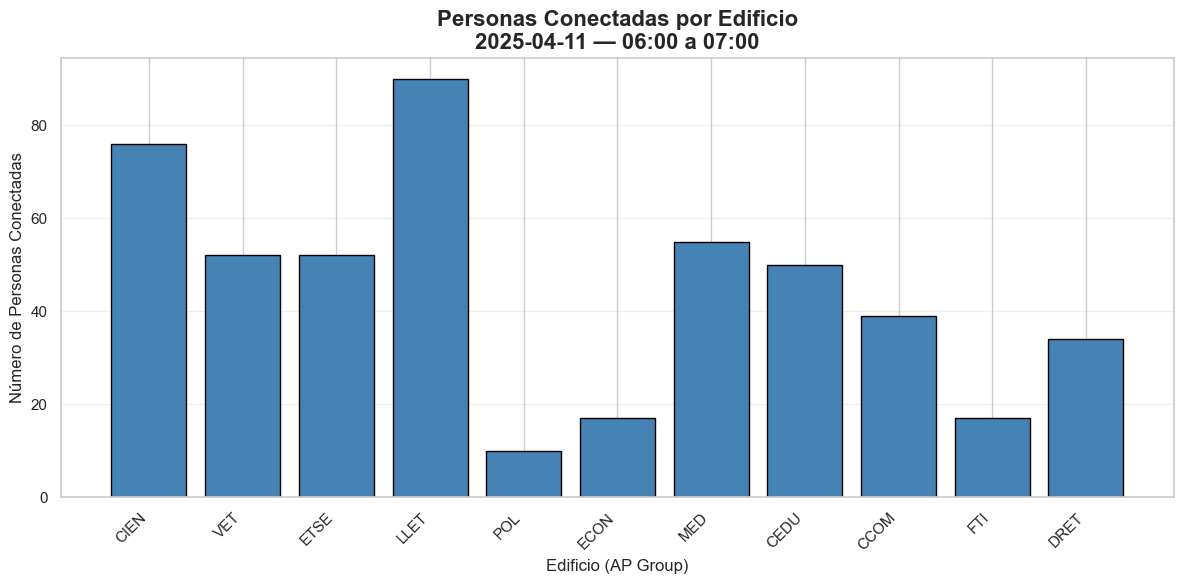

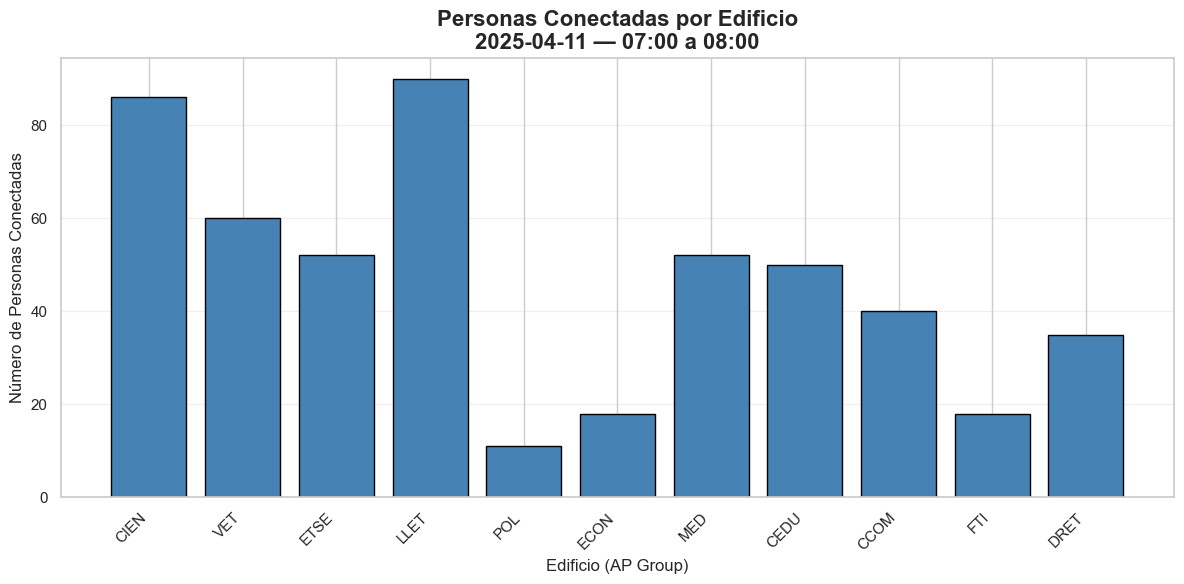

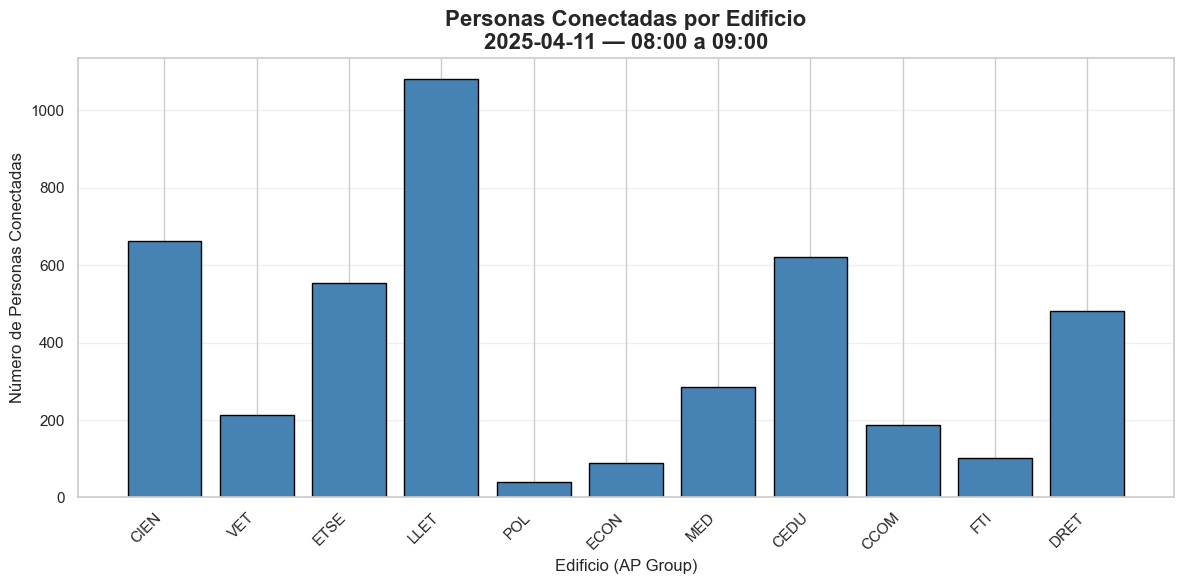

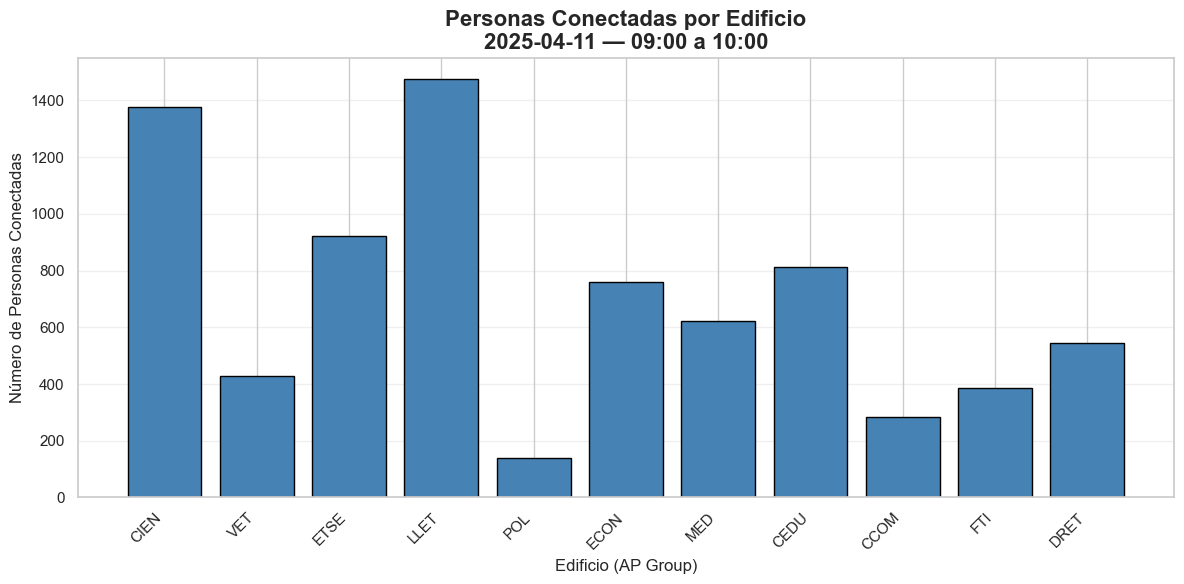

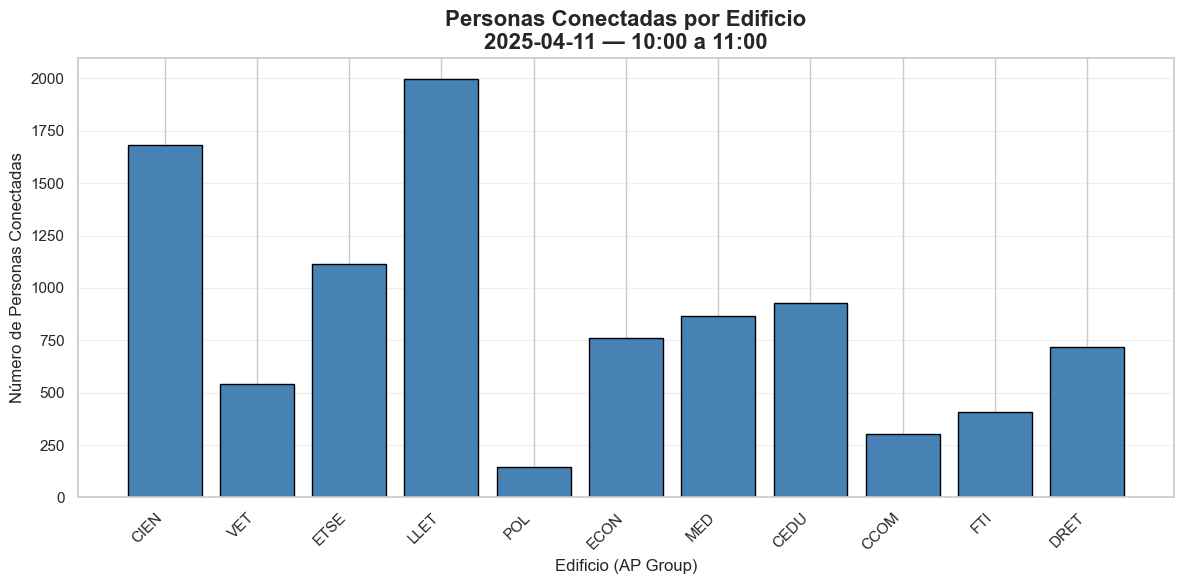

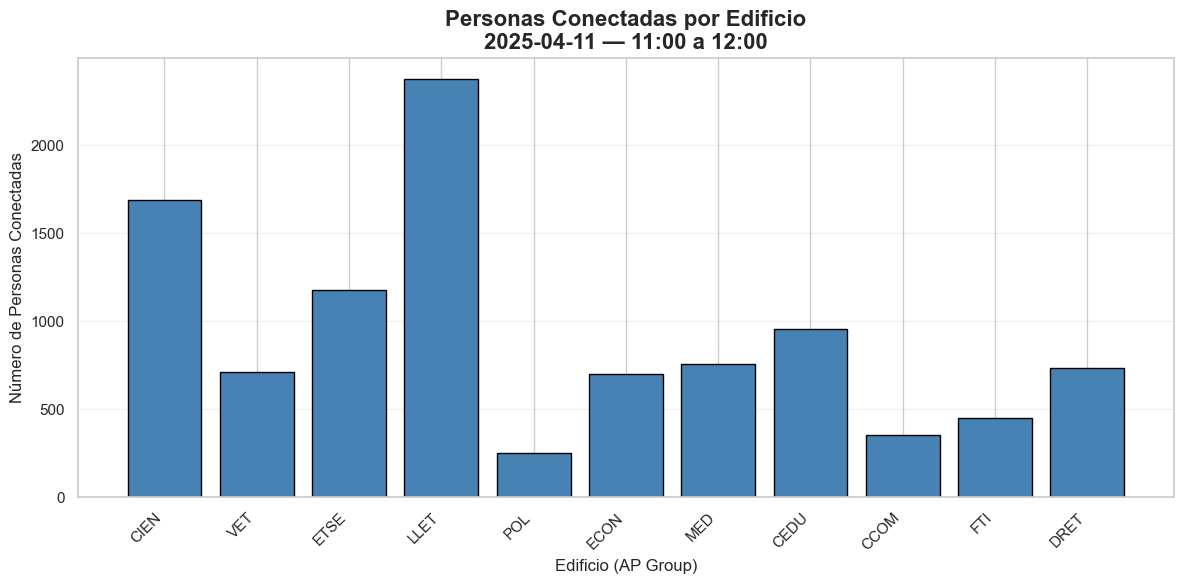

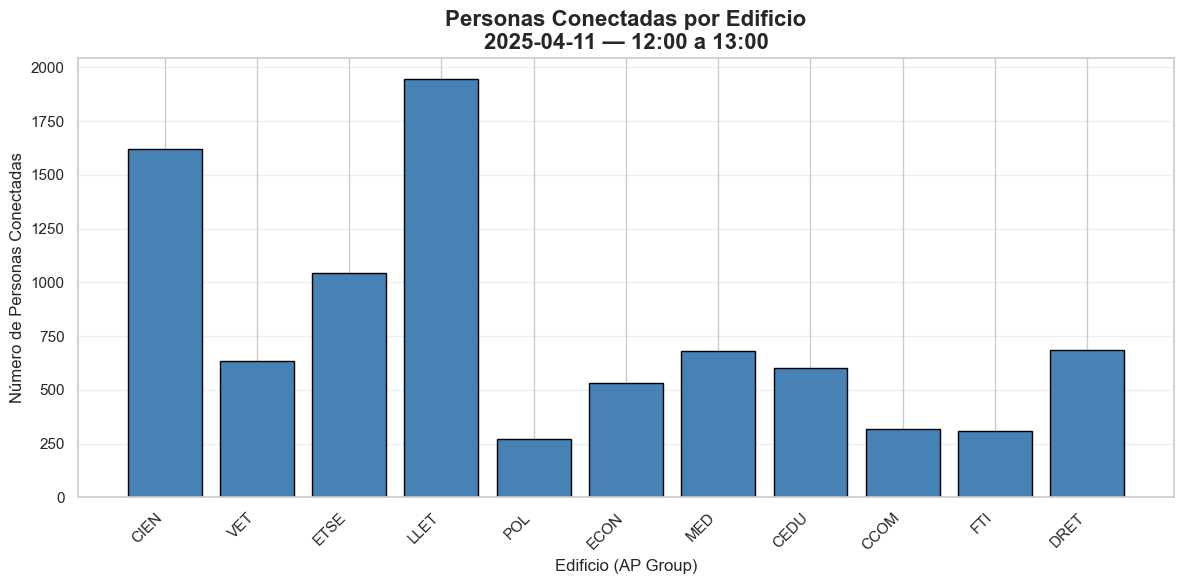

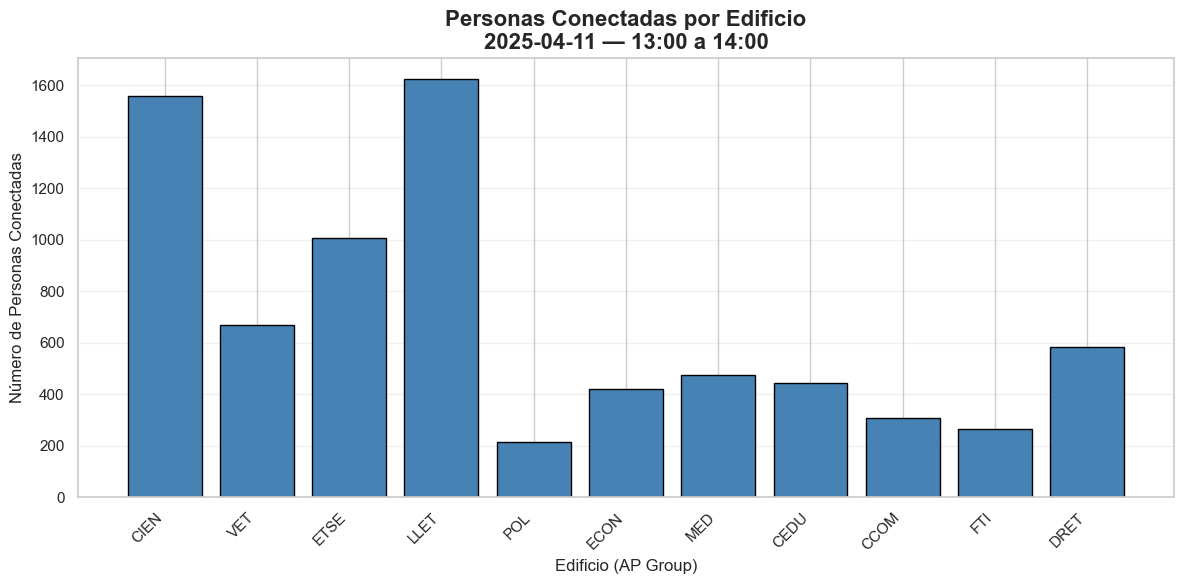

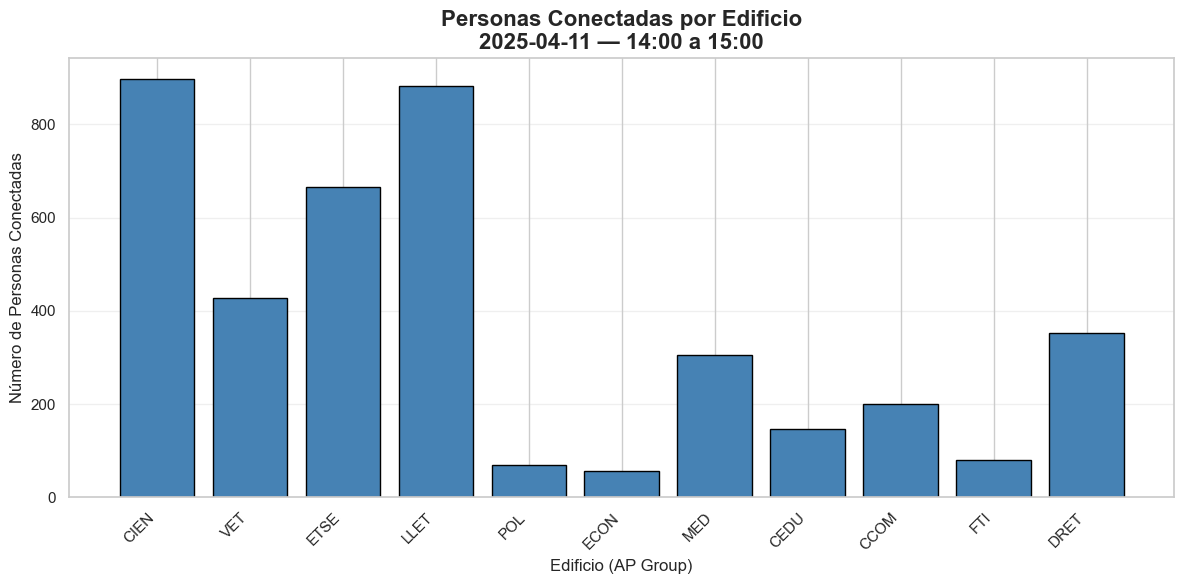

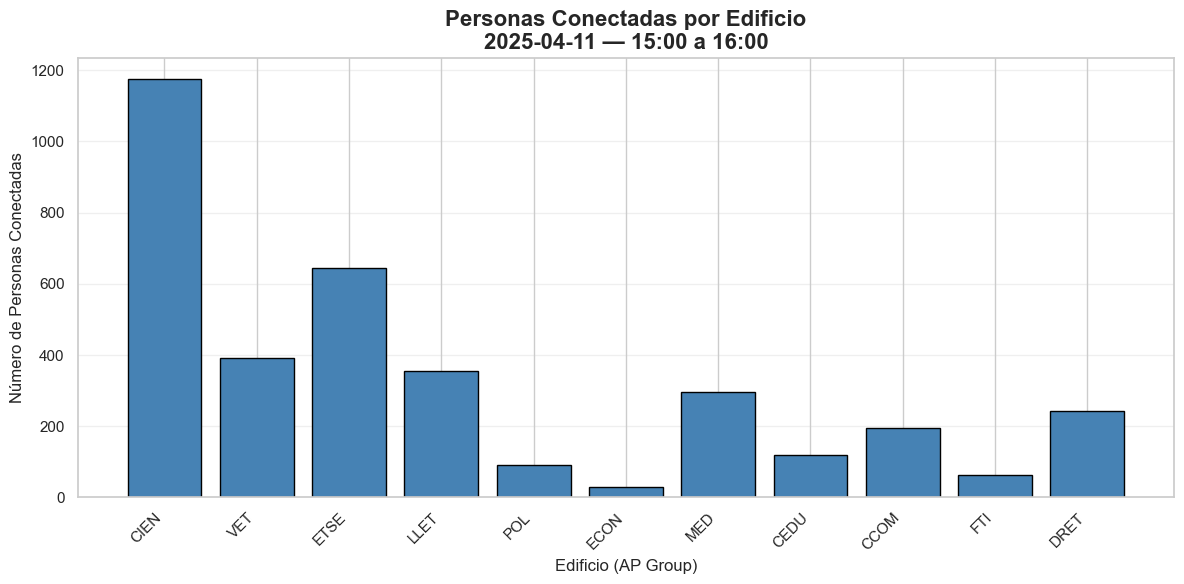

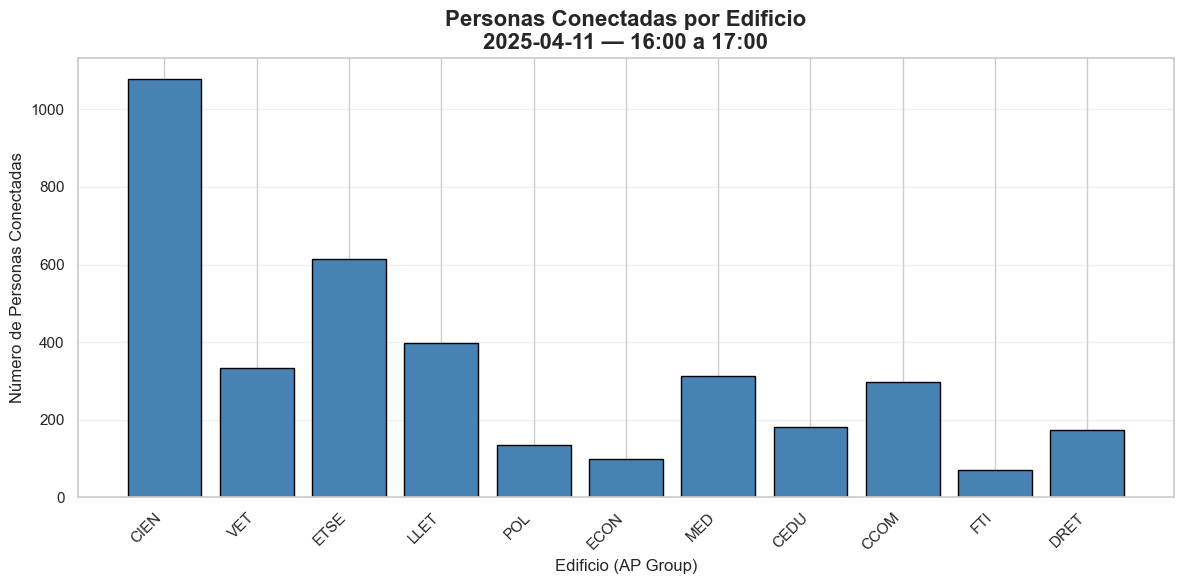

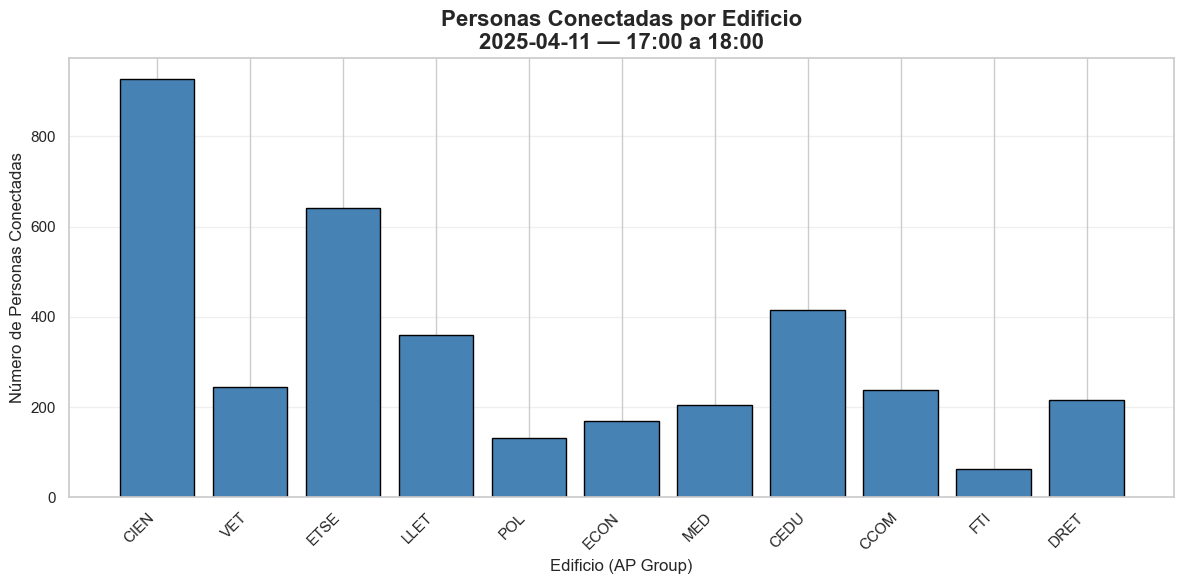

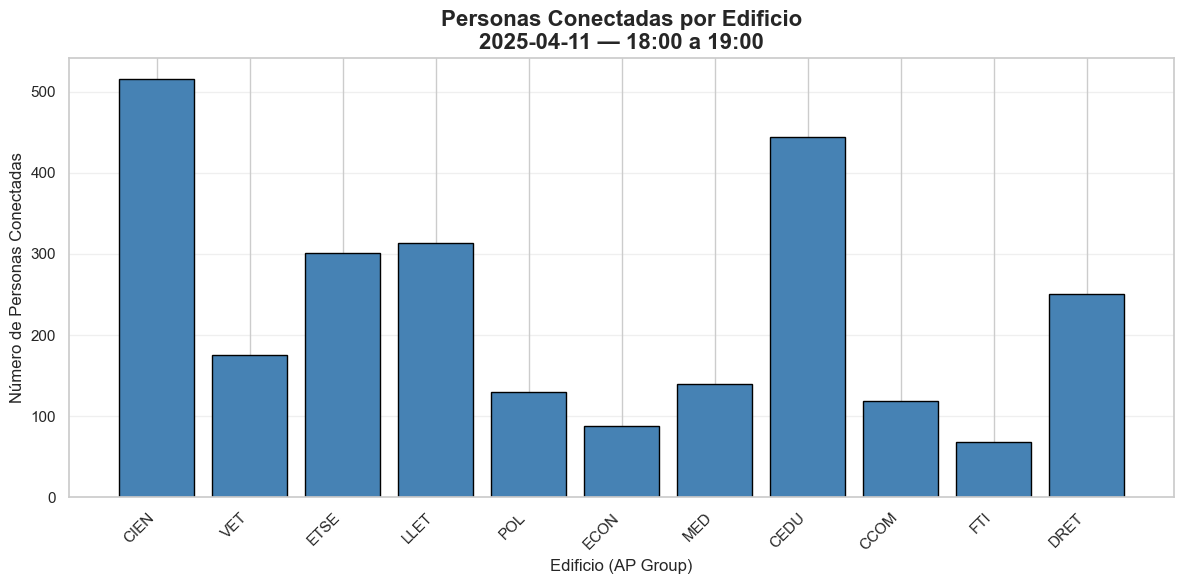

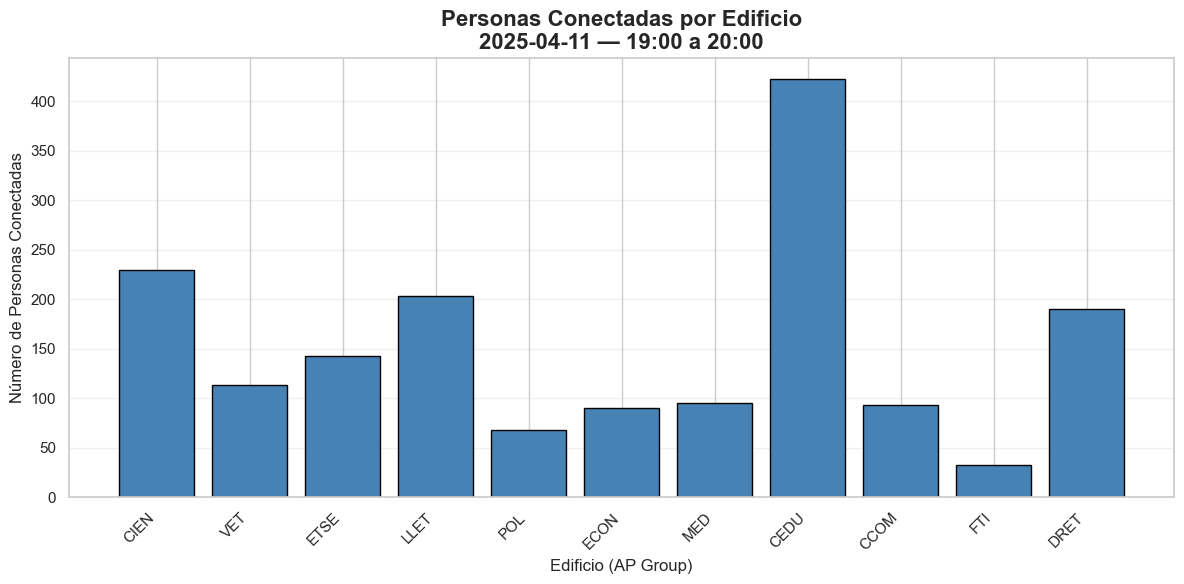

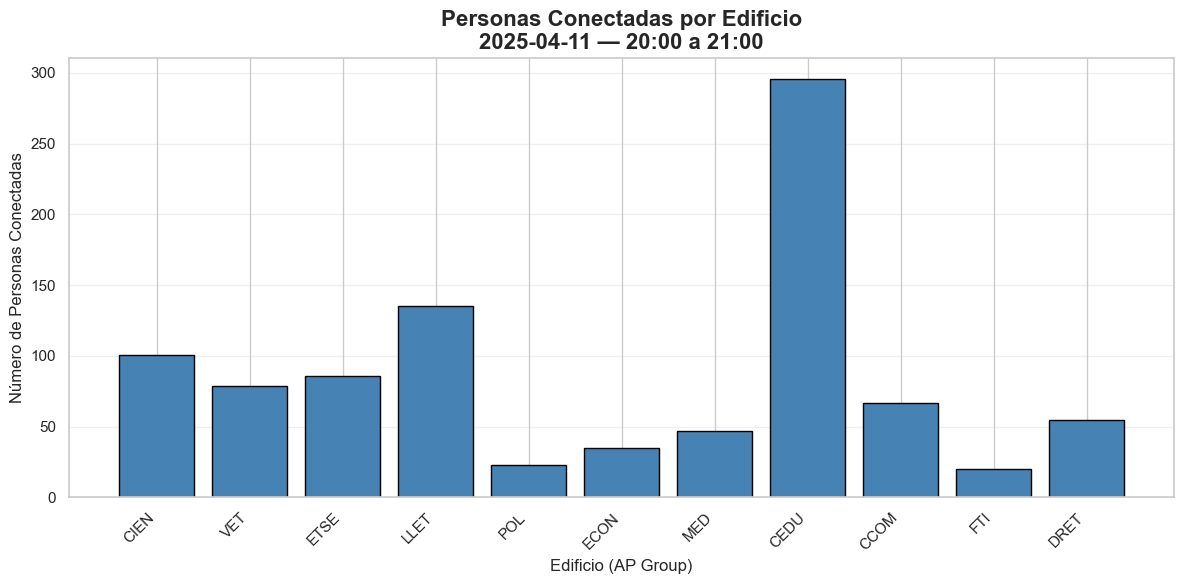

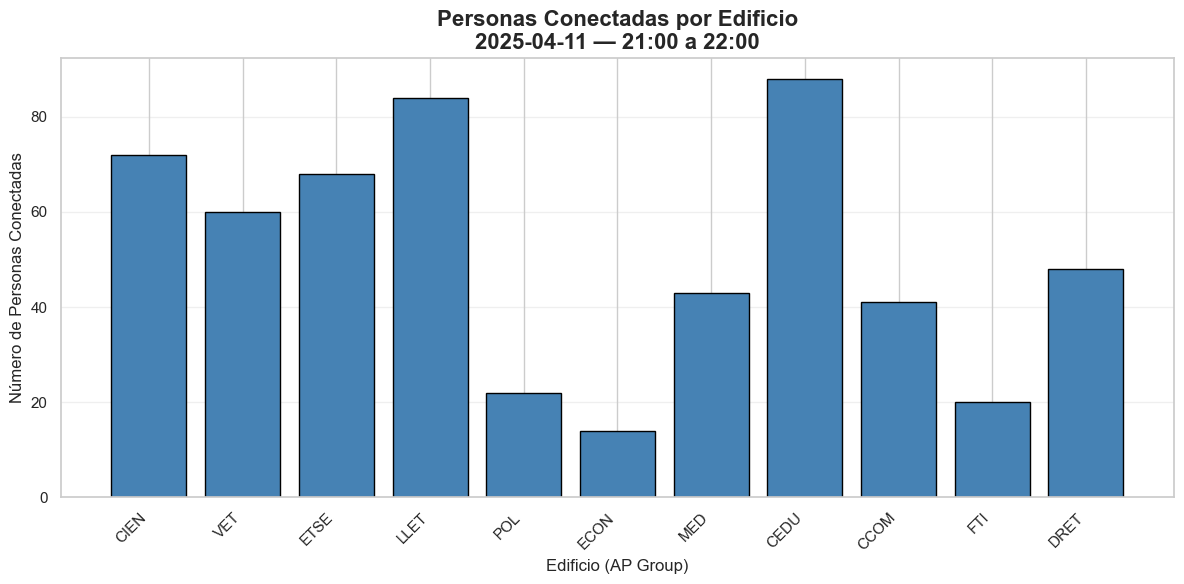

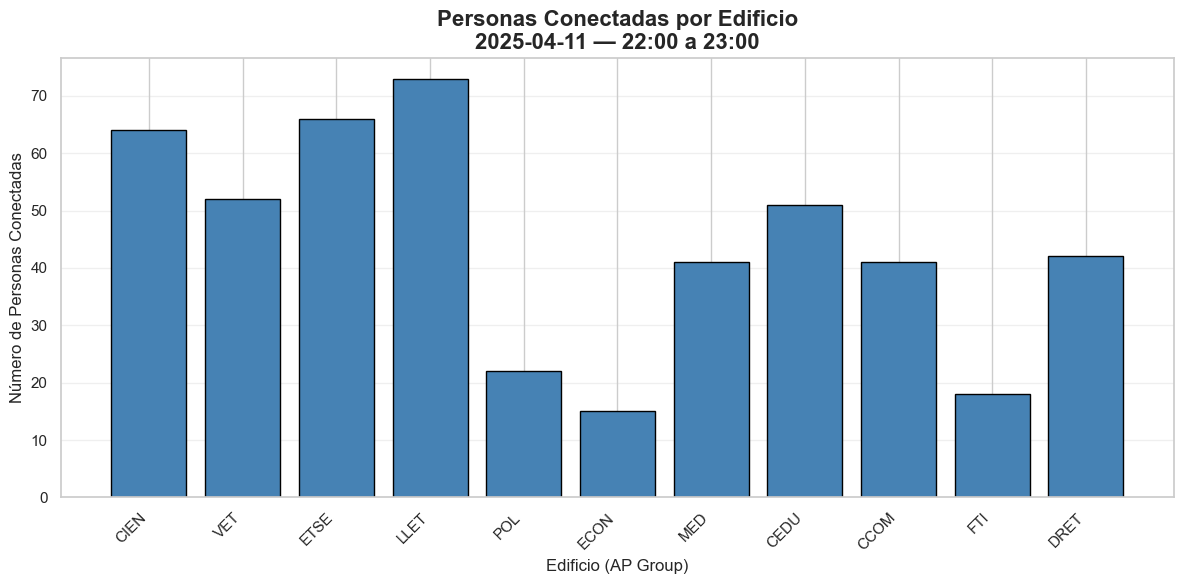

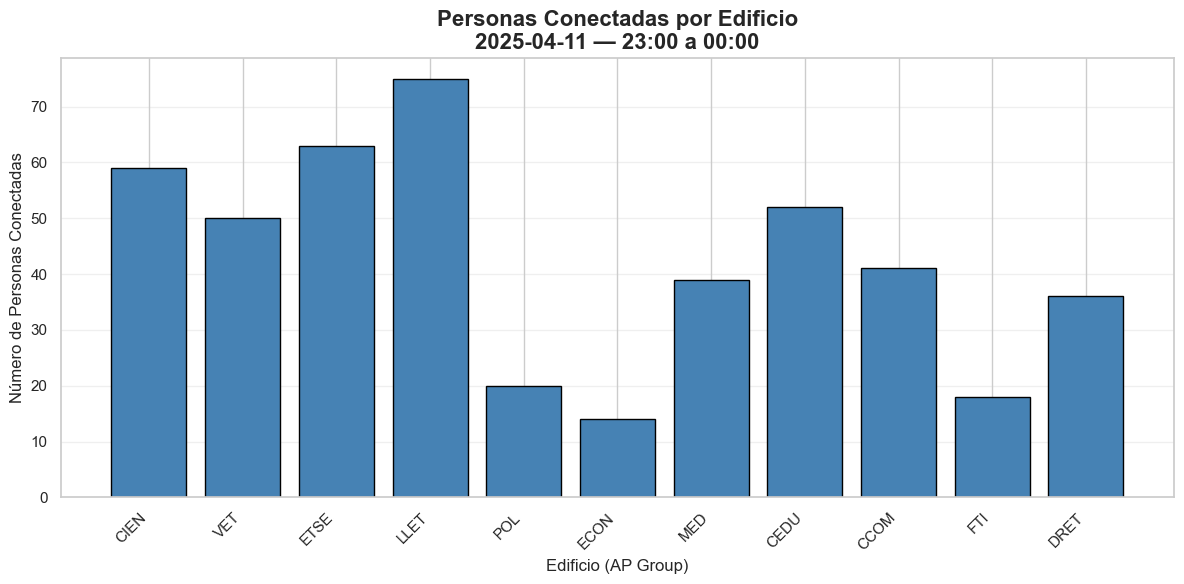

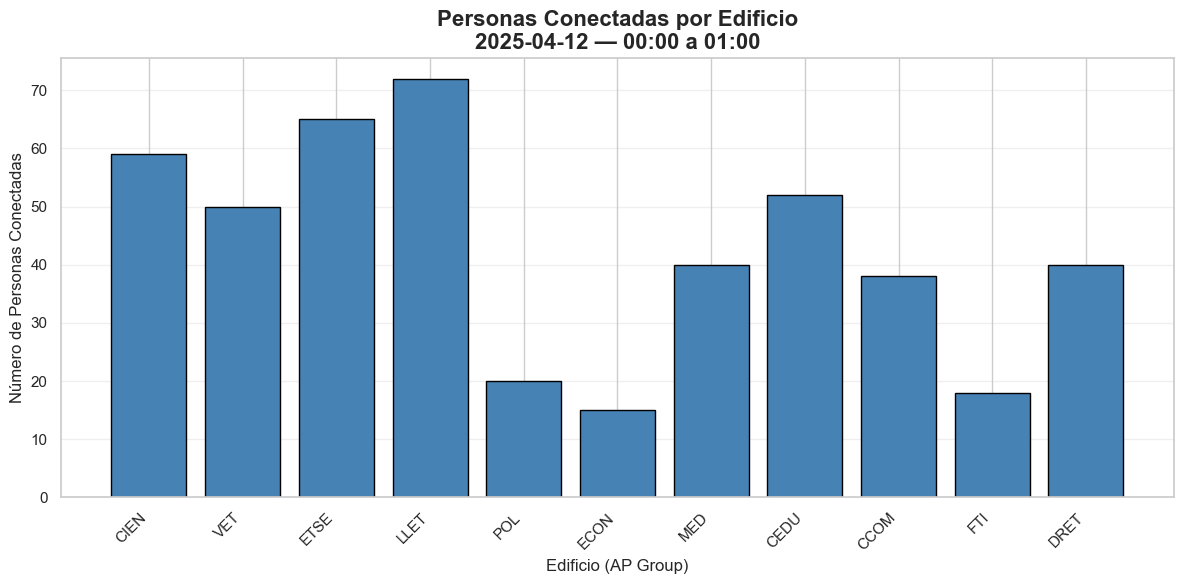

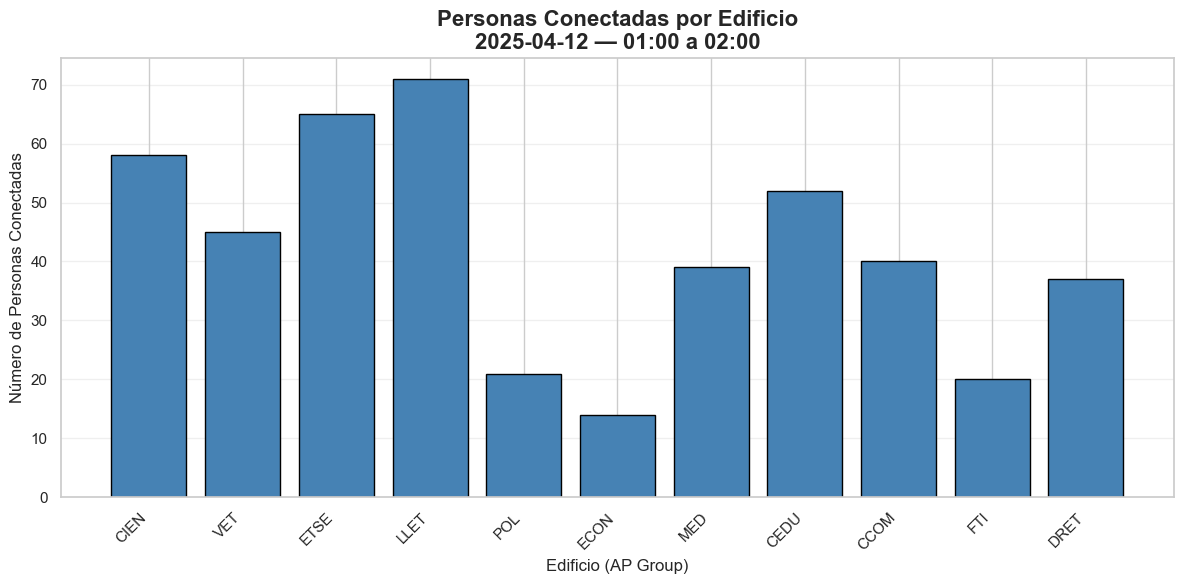

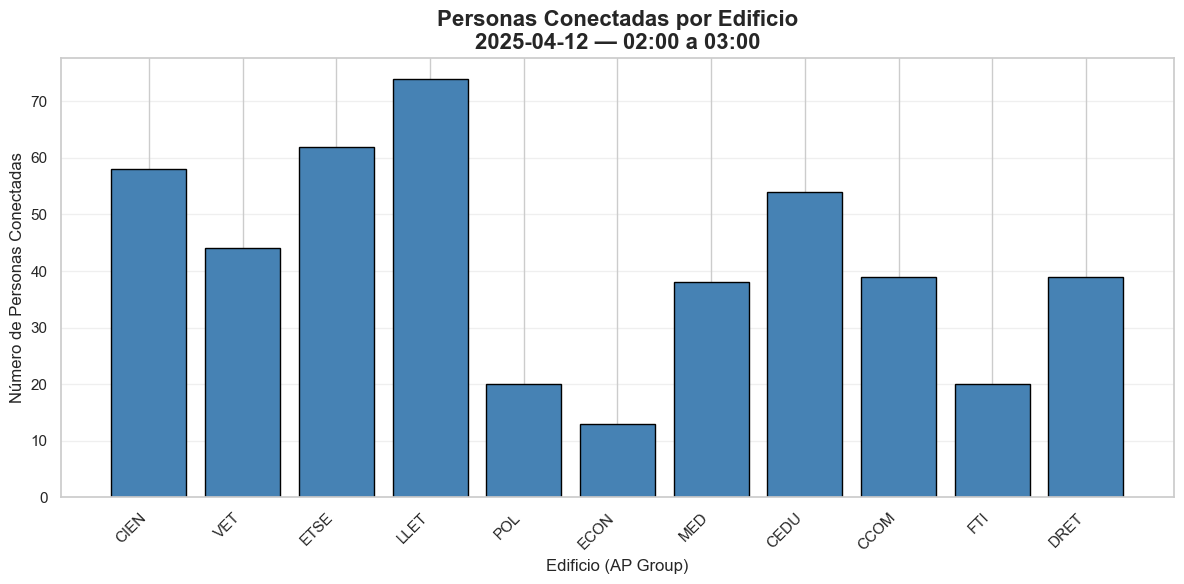

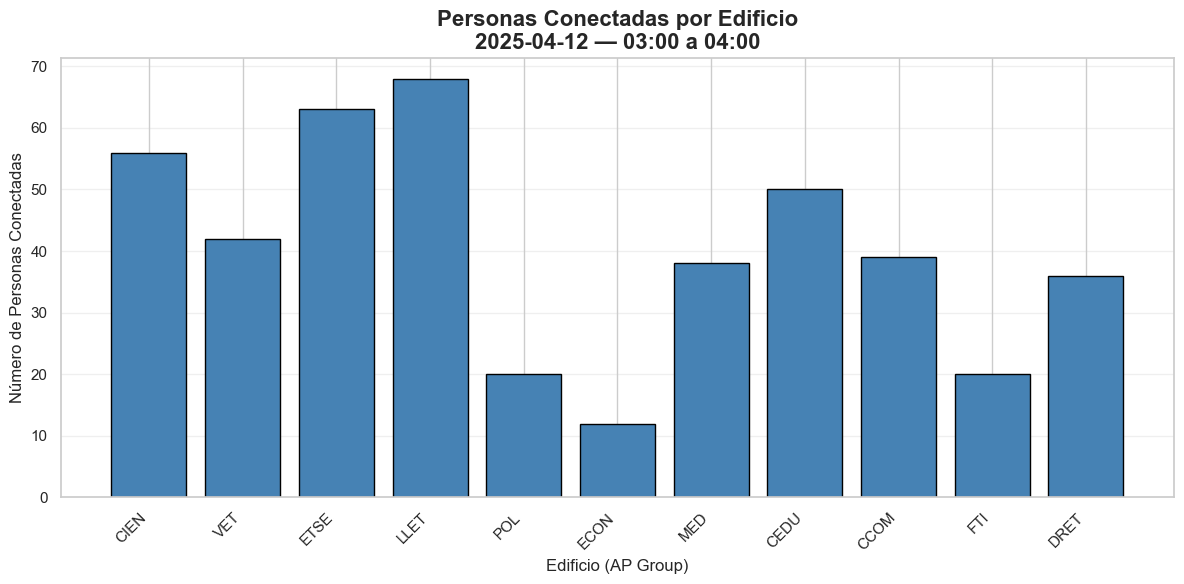

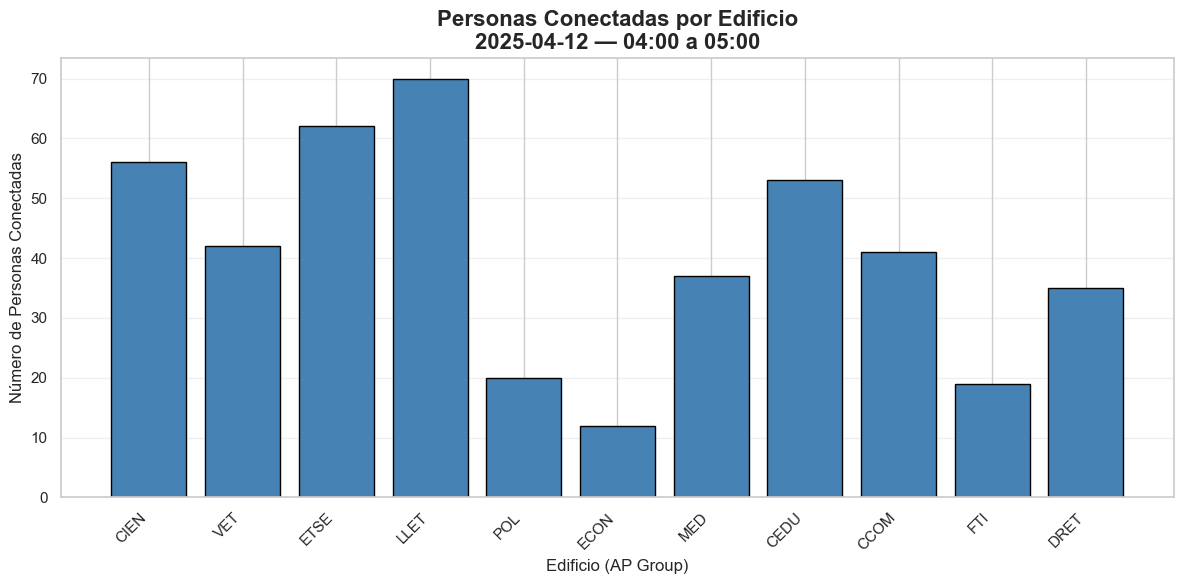

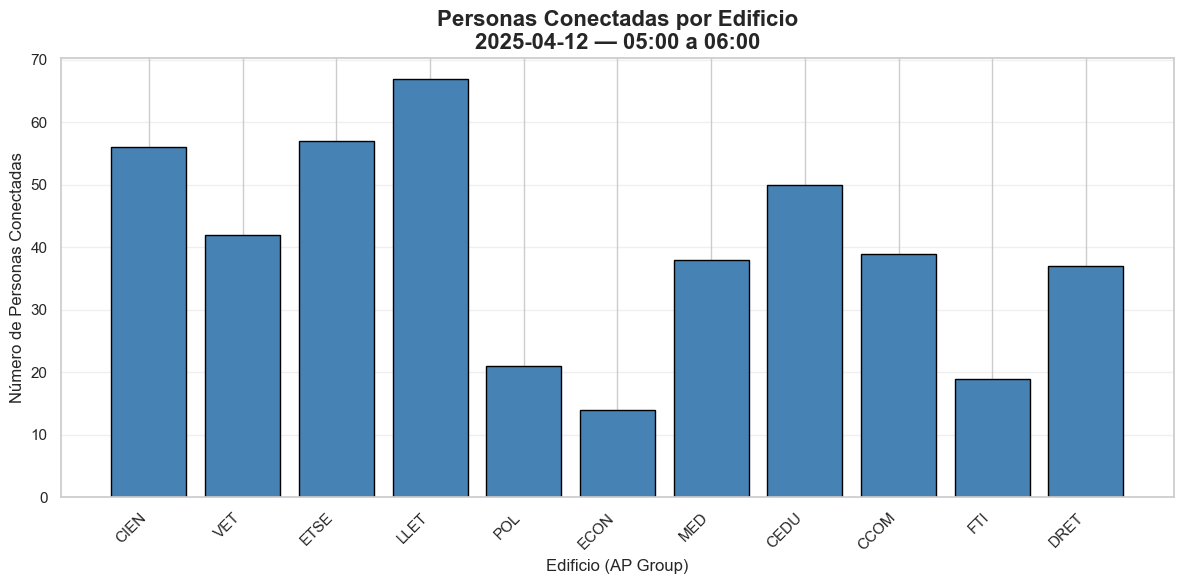

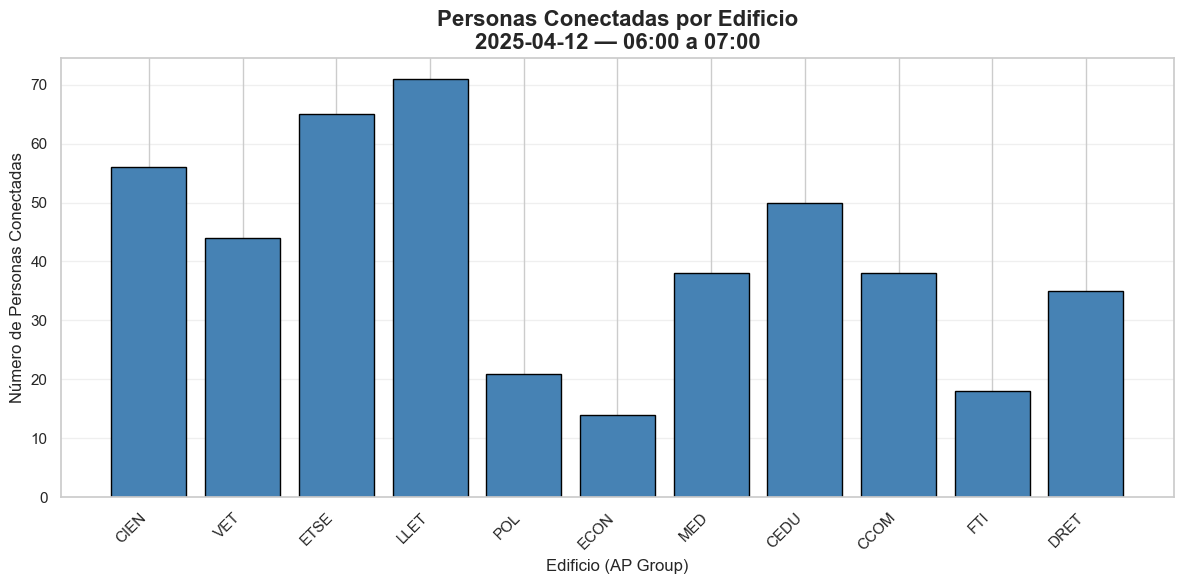

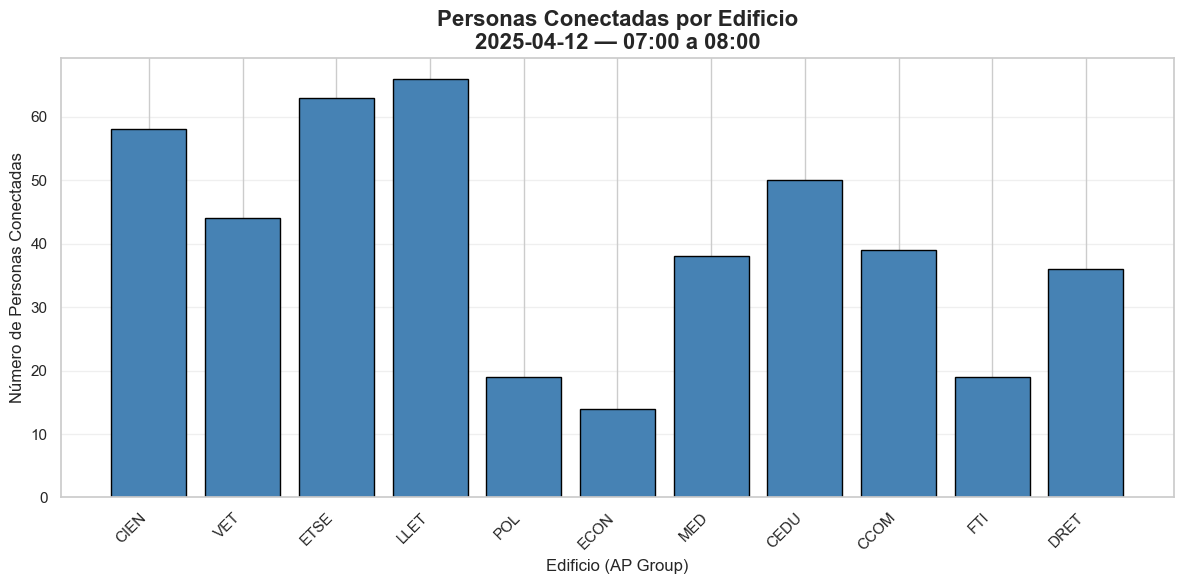

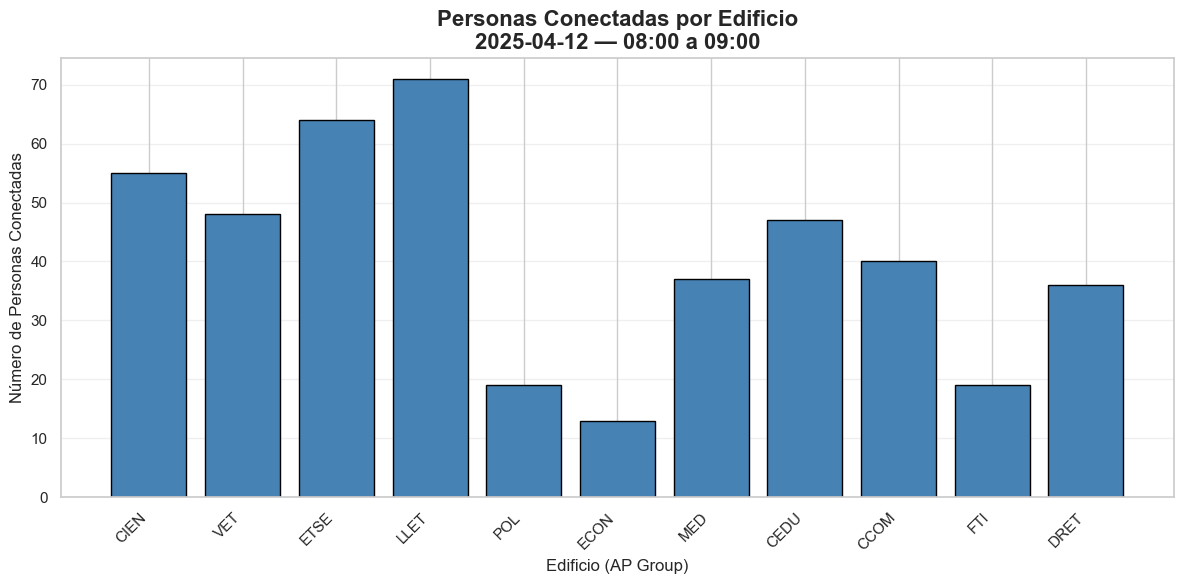

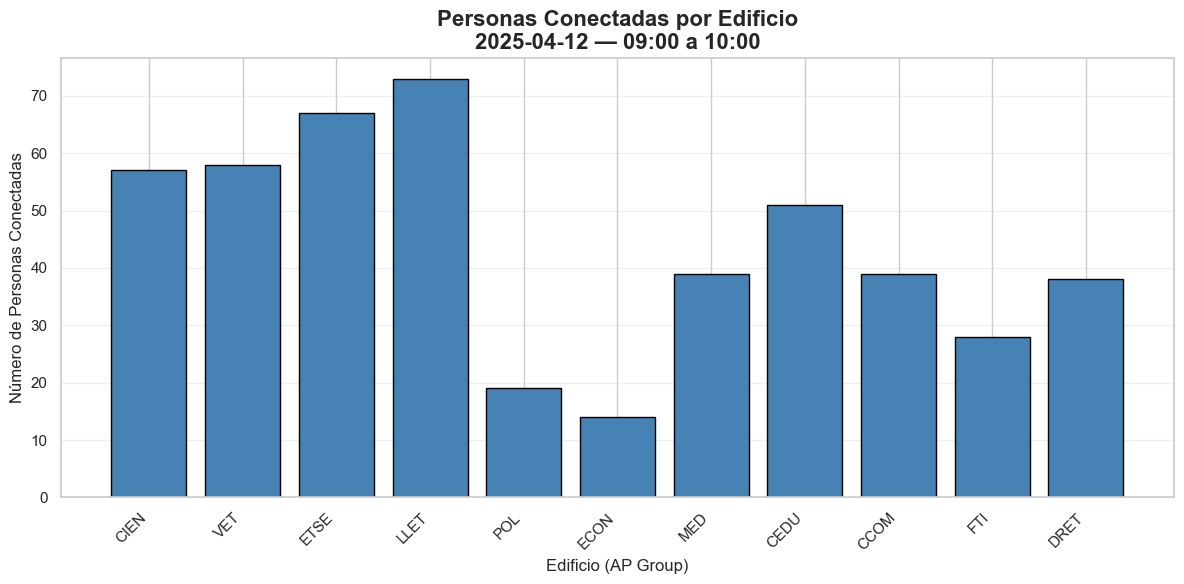

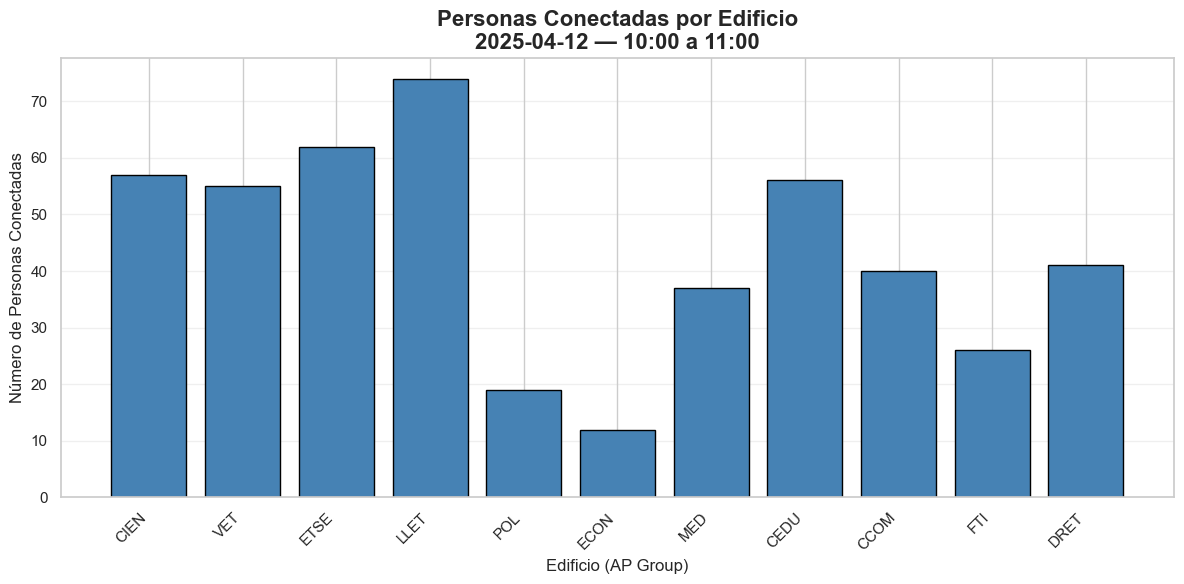

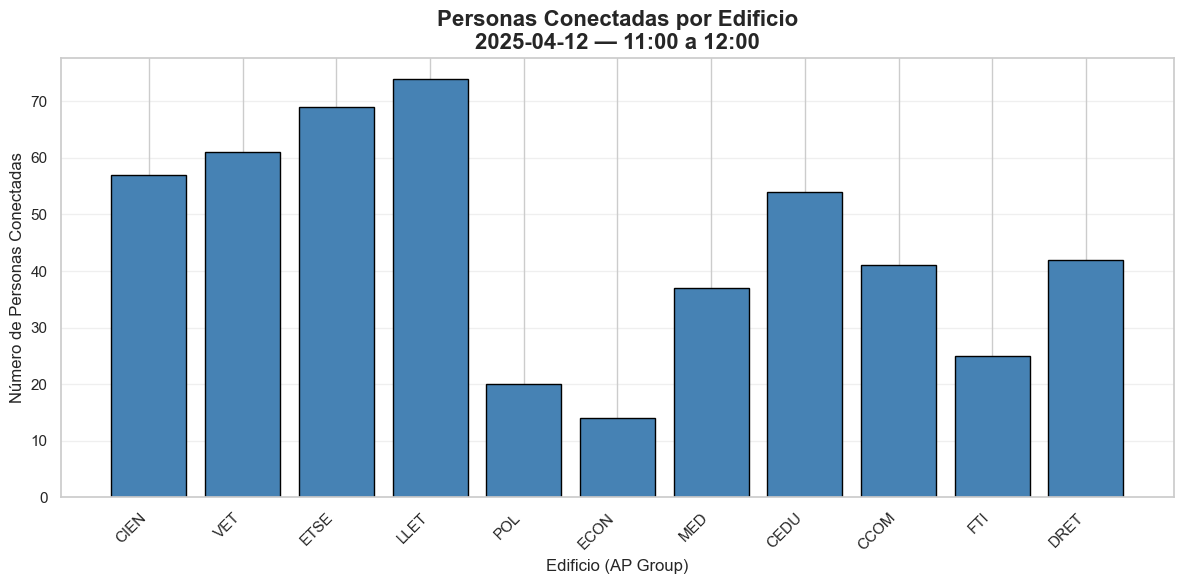

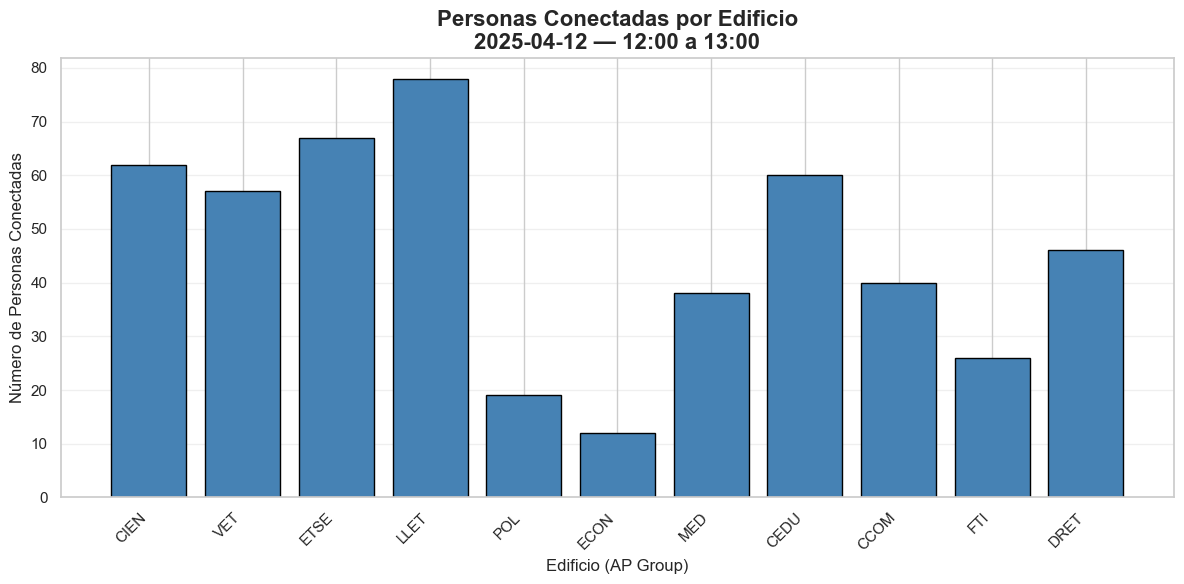

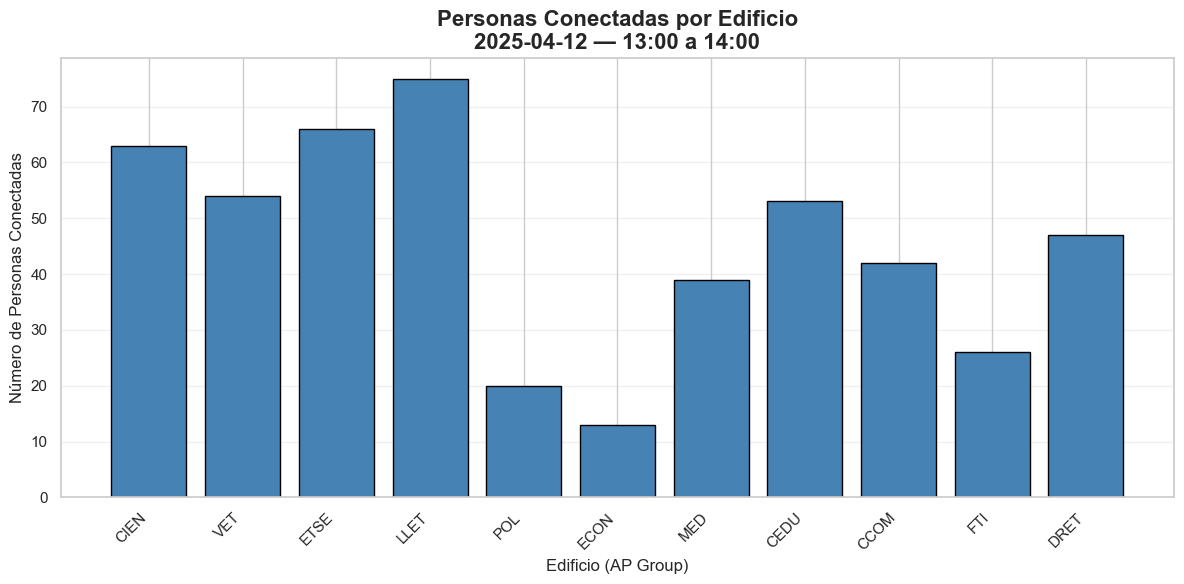

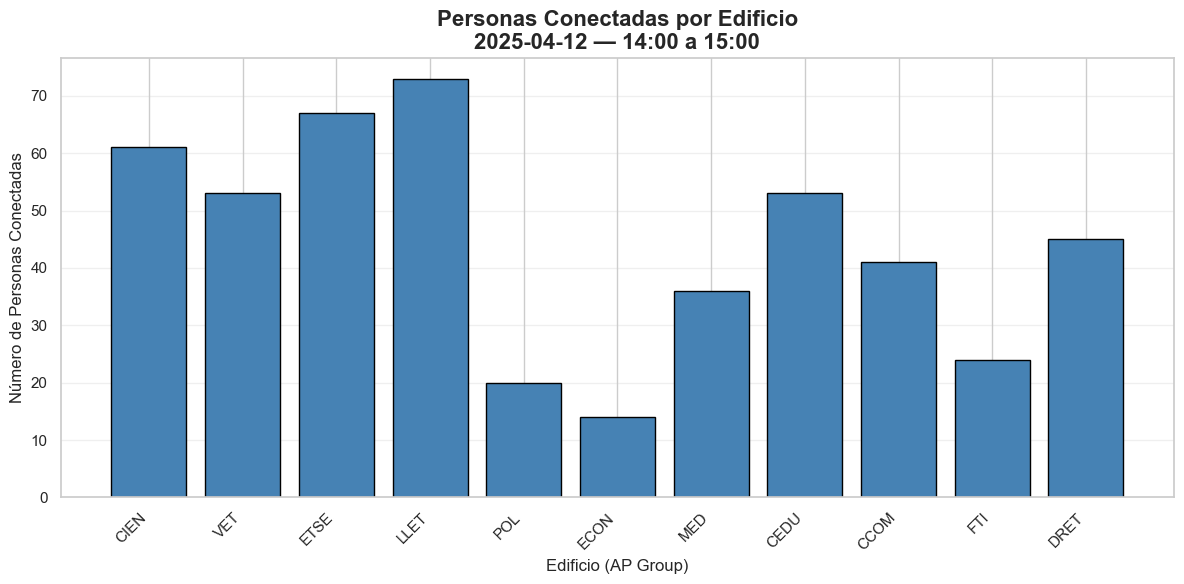

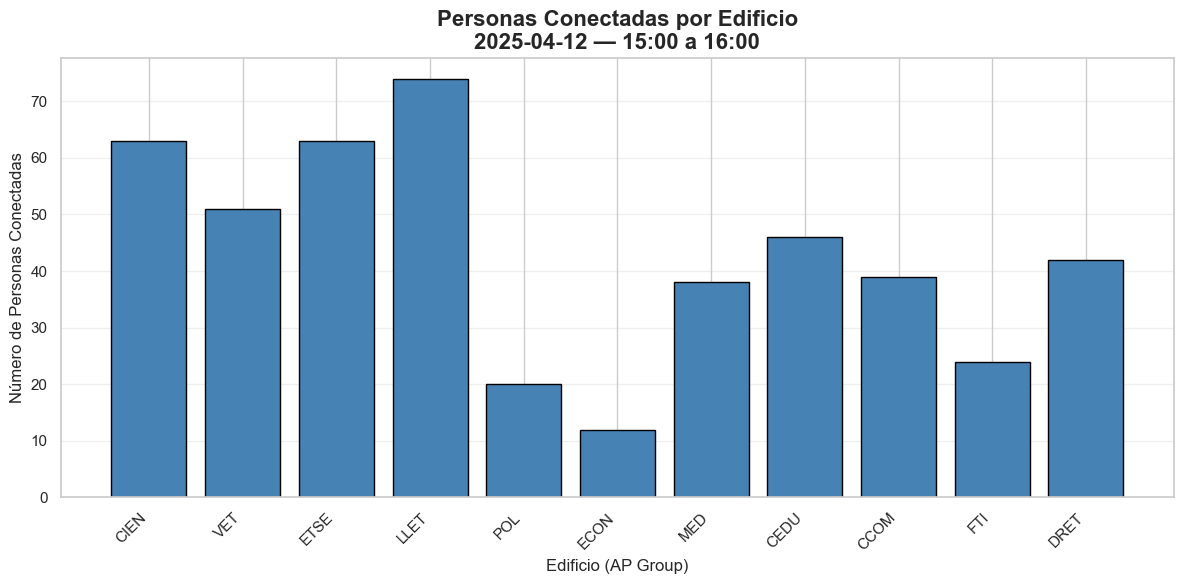

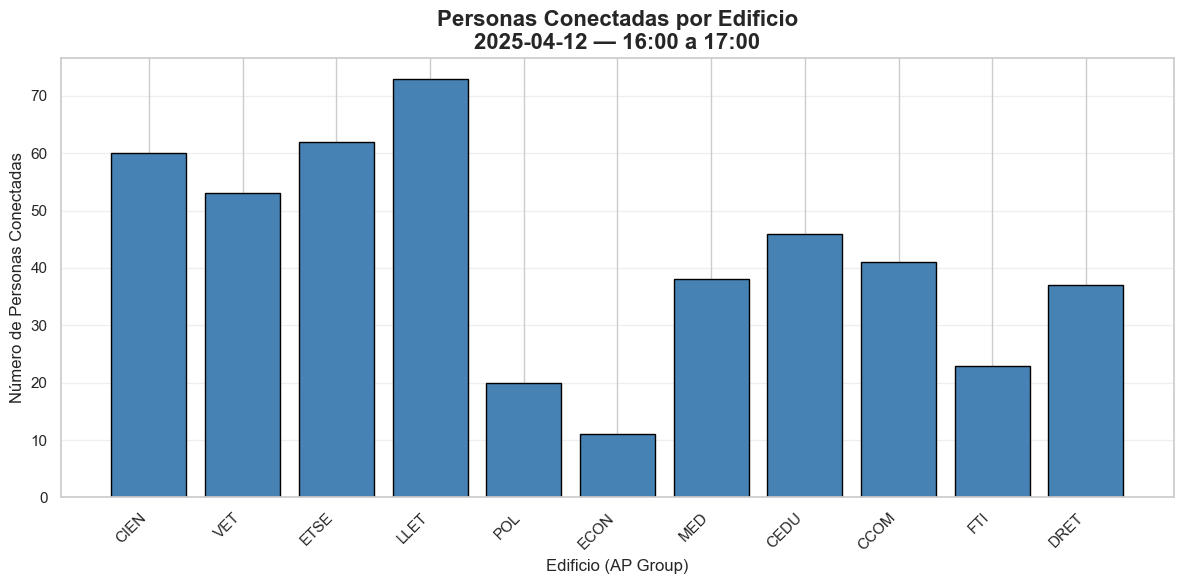

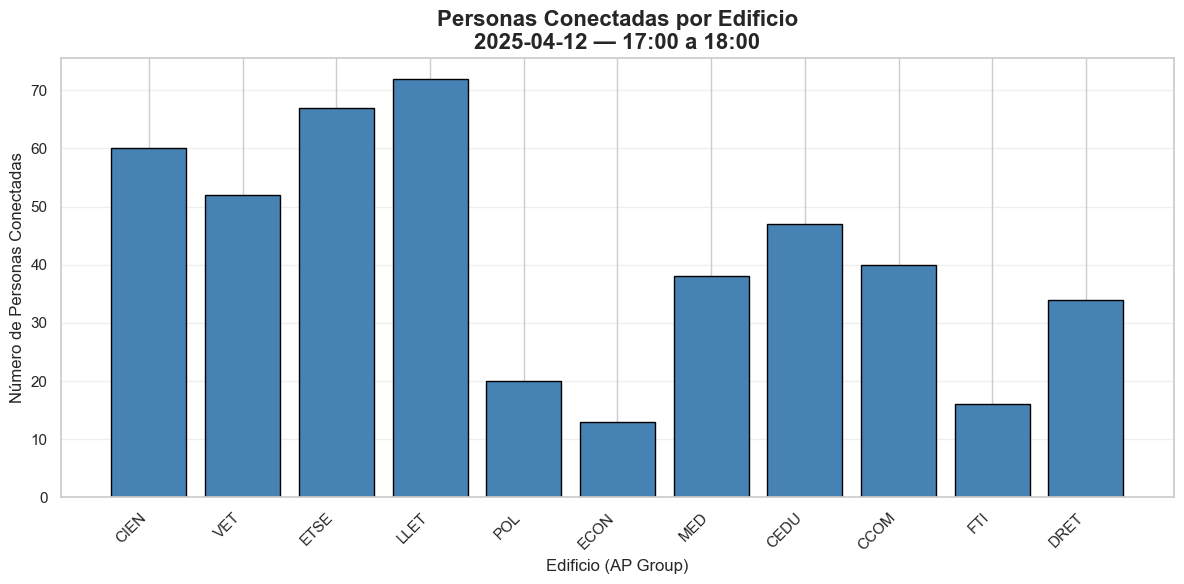

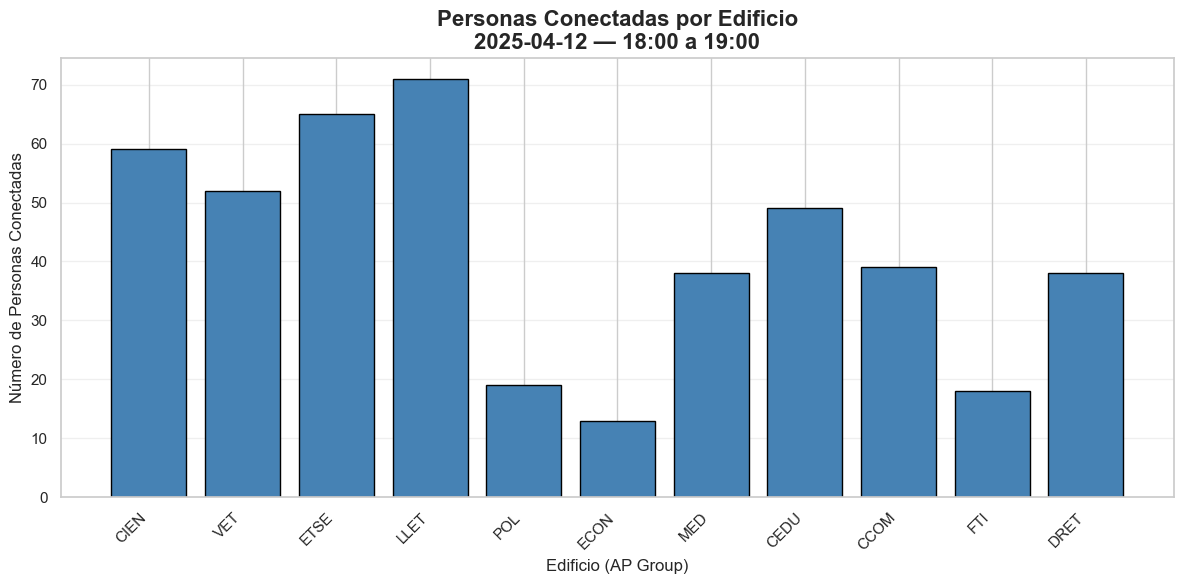

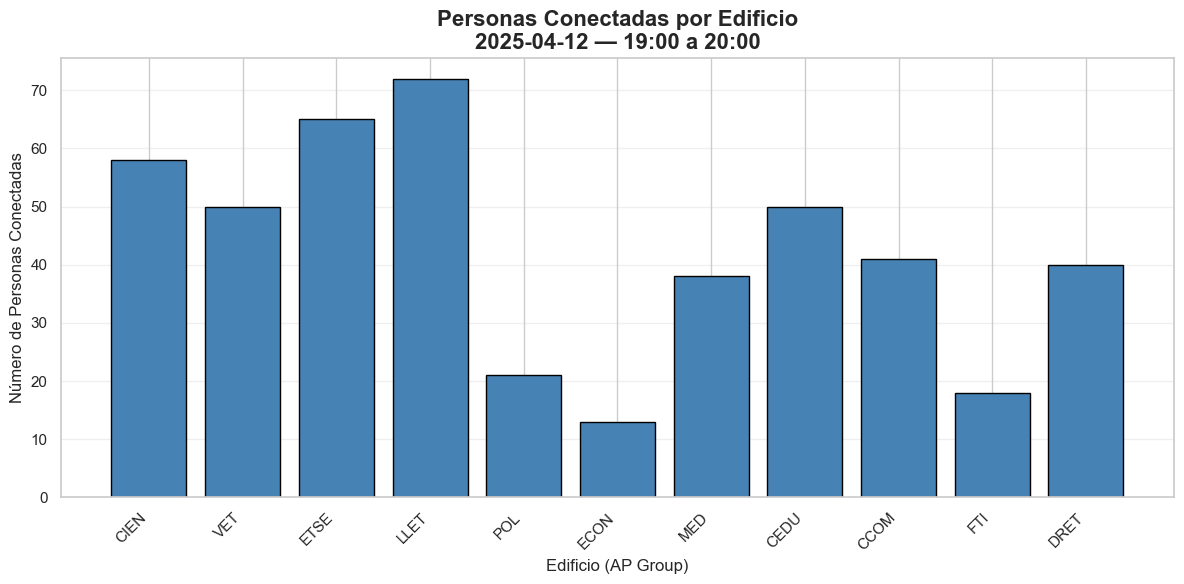

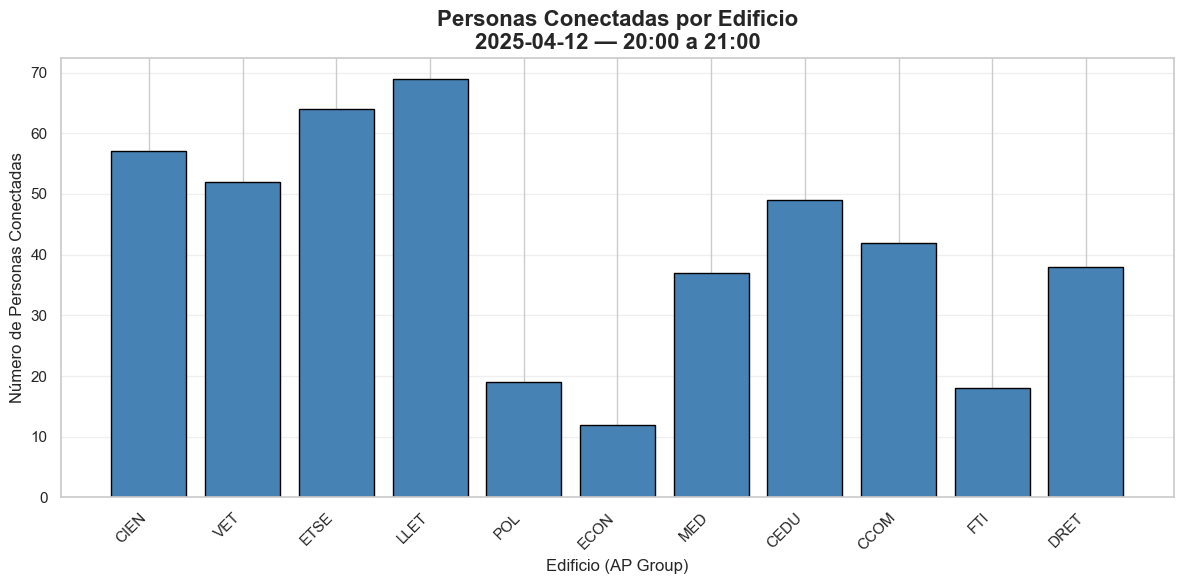

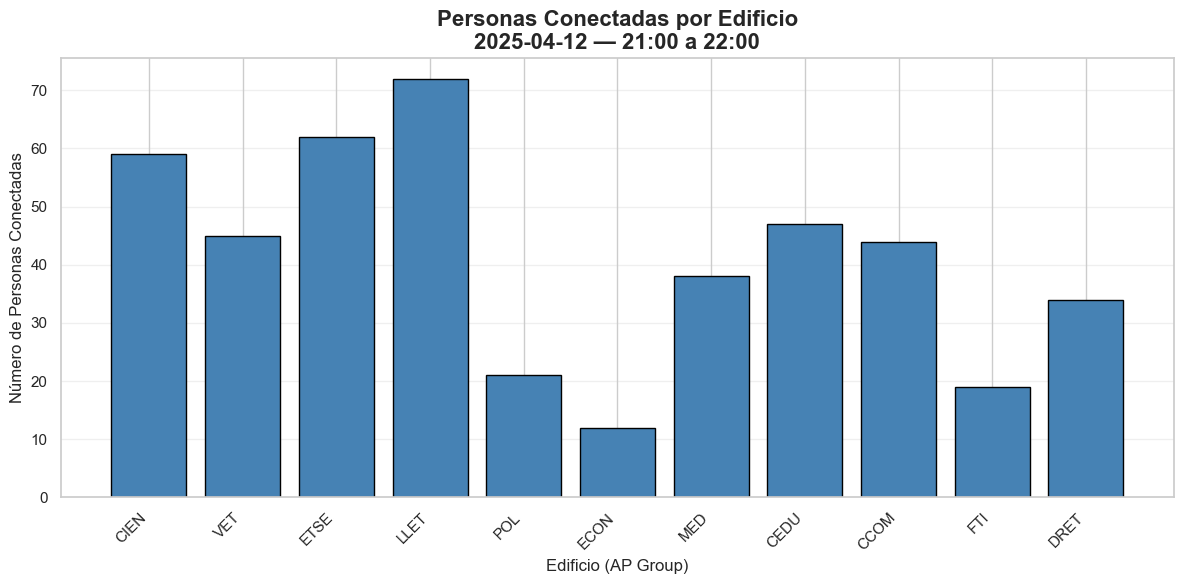

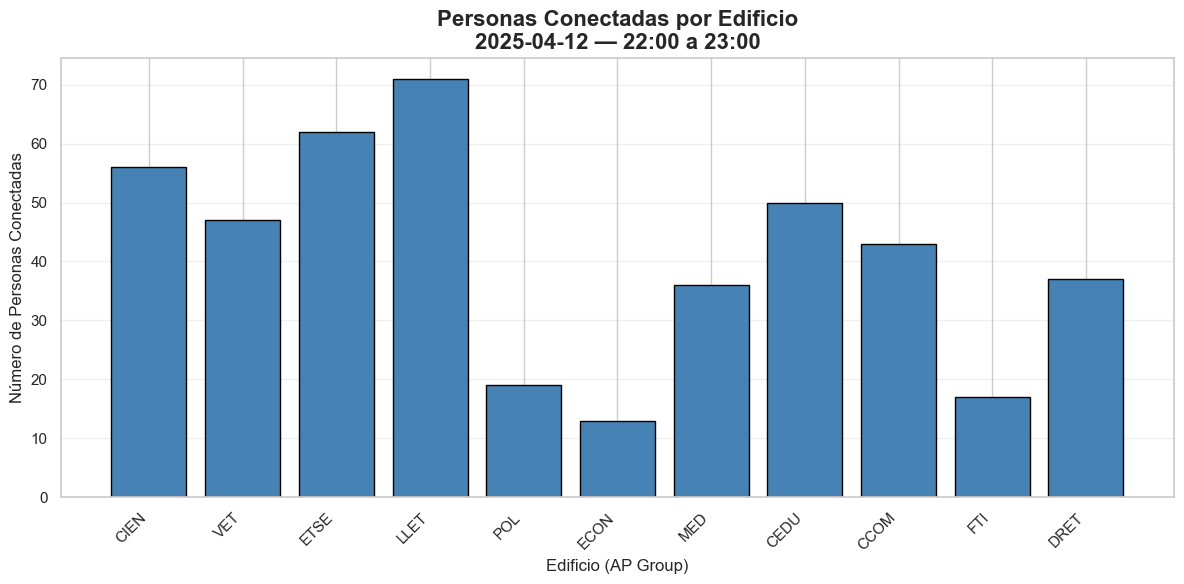

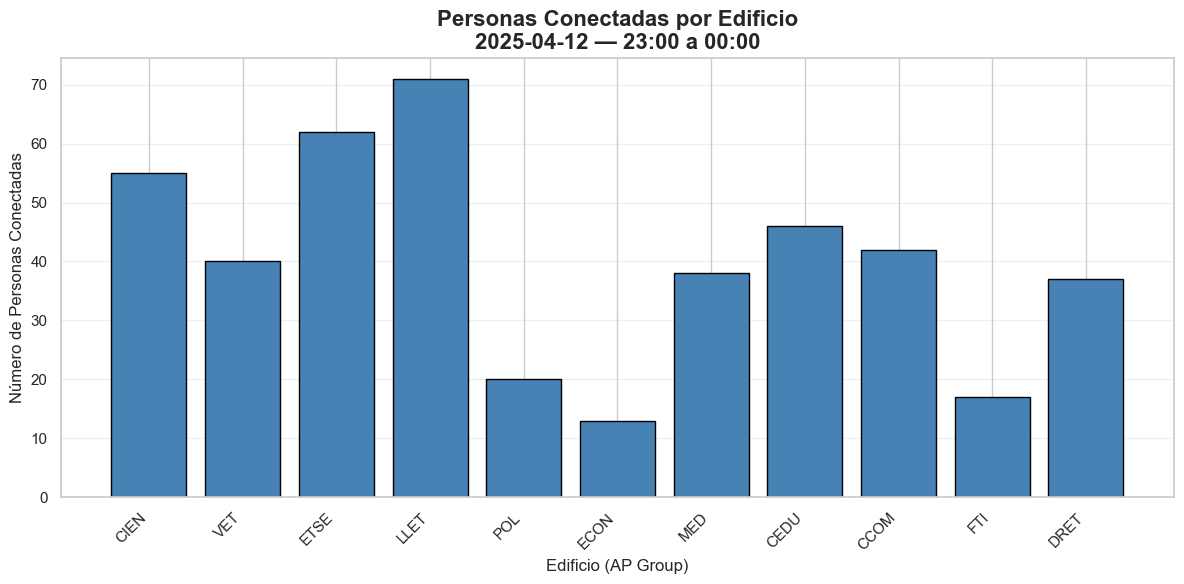

📊 MÁXIMOS HISTÓRICOS DE PERSONAS CONECTADAS POR EDIFICIO
🏛️  CIEN            → 2480 personas (📅 2025-04-08 11:00)
🏛️  VET             → 951 personas (📅 2025-04-07 11:00)
🏛️  ETSE            → 1494 personas (📅 2025-04-10 11:00)
🏛️  LLET            → 3899 personas (📅 2025-04-08 11:00)
🏛️  POL             → 481 personas (📅 2025-04-08 11:00)
🏛️  ECON            → 1042 personas (📅 2025-04-07 11:00)
🏛️  MED             → 867 personas (📅 2025-04-11 10:00)
🏛️  CEDU            → 1213 personas (📅 2025-04-08 11:00)
🏛️  CCOM            → 595 personas (📅 2025-04-07 12:00)
🏛️  FTI             → 821 personas (📅 2025-04-10 11:00)
🏛️  DRET            → 1183 personas (📅 2025-04-10 11:00)


In [5]:
max_connections = {building: 0 for building in top_buildings}
max_timestamps = {building: None for building in top_buildings}
df_clients_all['_file_timestamp'] = pd.to_datetime(df_clients_all['_file_timestamp'])

# Definir rango de fechas y edificios
start_date = pd.Timestamp('2025-04-06')
end_date = pd.Timestamp('2025-04-12')
top_buildings = ['CIEN', 'VET', 'ETSE', 'LLET', 'POL',
                 'ECON', 'MED', 'CEDU',
                 'CCOM', 'FTI', 'DRET']

# Crear columna con el grupo de edificio (AP agrupado)
df_clients_all['building'] = df_clients_all['associated_device_name'].apply(ap_to_building)

# Filtrar solo los top_buildings y fechas del rango
mask = (
    (df_clients_all['building'].isin(top_buildings)) &
    (df_clients_all['_file_timestamp'].dt.date >= start_date.date()) &
    (df_clients_all['_file_timestamp'].dt.date <= end_date.date())
)
df_filtered = df_clients_all[mask].copy()

# Iterar por cada día y hora
dates = pd.date_range(start=start_date, end=end_date, freq='D')
hours = range(0, 24)

for current_date in dates:
    for hour in hours:
        next_hour = (hour + 1) % 24
        if next_hour == 0:
            next_date = current_date + pd.Timedelta(days=1)
        else:
            next_date = current_date

        # Seleccionar registros entre esa hora y la siguiente
        mask_time = (
            (df_filtered['_file_timestamp'].dt.tz_localize(None) >= pd.Timestamp(current_date).replace(hour=hour, minute=0, second=0)) &
            (df_filtered['_file_timestamp'].dt.tz_localize(None) < pd.Timestamp(next_date).replace(hour=next_hour, minute=0, second=0))
        )

        df_hour = df_filtered[mask_time]

        if df_hour.empty:
            continue

        # Contar personas únicas por edificio
        building_counts = df_hour.groupby('building')['macaddr'].nunique().reindex(top_buildings, fill_value=0)

        # Actualizar máximos
        for building in top_buildings:
            current_count = building_counts[building]
            current_max = max_connections[building]
            
            if current_count > current_max:
                max_connections[building] = current_count
                max_timestamps[building] = f"{current_date.date()} {hour:02d}:00"
                
        # Crear gráfico
        plt.figure(figsize=(12, 6))
        plt.bar(building_counts.index, building_counts.values, color='steelblue', edgecolor='black')
        plt.title(f"Personas Conectadas por Edificio\n{current_date.date()} — {hour:02d}:00 a {next_hour:02d}:00", fontsize=16, fontweight='bold')
        plt.xlabel('Edificio (AP Group)', fontsize=12)
        plt.ylabel('Número de Personas Conectadas', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Print final con todos los máximos
print("=" * 70)
print("📊 MÁXIMOS HISTÓRICOS DE PERSONAS CONECTADAS POR EDIFICIO")
print("=" * 70)
for building in top_buildings:
    print(f"🏛️  {building:15} → {max_connections[building]:3d} personas (📅 {max_timestamps[building]})")
print("=" * 70)